# Auswertung der modellierten Textzeugen und der extrahierten Textstufen 

In [1]:
import lxml
from lxml import etree
import pandas as pd
import re
import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [2]:
ns = {"t": "http://www.tei-c.org/ns/1.0"}
xml = "{http://www.w3.org/XML/1998/namespace}"

In [3]:
poem = "aptrm"

In [4]:
tree = etree.parse(f"C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/extrahiert_{poem}.xml")

## Auswertung der Eingriffe und Revisionen in den Textzeugen.
Alle divs mit type="witness" und einer xml:id im xml werden untersucht.

#### Funktion extractallinterferences zur Erfassung und Auswertung aller vorhandenen Tags, deren Attribute und Values sowie den einzelnen Kombinationen. Als CSV-Dokumente gespeichert, inkl. Visualisierungen.

In [5]:
# Erfassung aller vorhandenen Tags
def extractallinterferences(poem):
    divs = tree.xpath(f"//t:div[@type='poem' and @xml:id='{poem}']//t:div[@type='witness']", namespaces=ns)
    foldername = f"{poem}_Eingrifftags+Attribute_csvs" # Foldername mit Poemname bestimmen
#    os.makedirs(f"C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{foldername}") # Folder kreiern

    # seaborn Farbenpalette für Visualisierung
    sns.set_style("whitegrid")
    palette = "hls"
    
    for div in divs: # pro div einen divname kreieren
        divtype = div.attrib.get('type')
        divid = div.attrib.get(f'{xml}id')
        divname = f"{divtype}_{divid}"
        print(divname)
    
        allcombinations = tree.xpath(f"//t:div[@type='{divtype}' and @xml:id='{divid}']//t:l//@* | //t:div[@type='{divtype}' and @xml:id='{divid}']//t:l//*", namespaces=ns) # alle Tags und Attribute herausnehmen
        
        allcombinations_list = [] # Liste für alle Tag-Attribute-Value-Kombinationen
        
        for element in allcombinations: 
            if isinstance(element, etree._Element):  # ist es ein Tag, dann wird der Name extrahiert 
                elementname = etree.QName(element).localname
                
                for attr_name, attr_value in element.attrib.items():  # pro Element/Tag wird der Attributname und Attributwert geholt 
                    allcombinations_list.append((elementname, attr_name, attr_value)) # als Kombinationen speichern

    
        alltags = tree.xpath(f"//t:div[@type='{divtype}' and @xml:id='{divid}']//t:l//*", namespaces=ns) # alle Tags
            
        alltags_list = [] # Liste nur für die Tags/Elemente
        onlyattr_list = [] # Liste nur für die Attribute
        onlyval_list = [] # Liste nur für die Attributevalues
    
        for element in alltags: 
            if isinstance(element, etree._Element):  # ist es ein Tag, dann wird es normalisiert
                elementname = etree.QName(element).localname
                alltags_list.append(elementname) # nur Tag/Element

                for attr_name, attr_value in element.attrib.items():  # pro Element/Tag wird der Attributname und Attributwert geholt 
                    onlyattr_list.append(attr_name) # nur Attribute
                    onlyval_list.append(attr_value) # nur Values

        # DF für KOMBINATIONEN
        allcombinations_counter = f"allattributes_counter_{divname}" # Countername pro div und Allattributes-Liste (Tag-Attribute-Value) erstellen
        allcombinations_counter = Counter(allcombinations_list)
        
        df = f"allcombinations_{divname}" # df für das div mit den Tags erstellen
        df = pd.DataFrame.from_dict(allcombinations_counter, orient='index').reset_index()
        df = df.rename(columns={'index':'tag - attribute - value', 0:'count'})
        df.to_csv(f'{foldername}/allcombinations_{divname}_df.csv', index=False)
        print(df)

        # VISUALISIERUNG
        ax = df.plot(x='tag - attribute - value', y='count', kind='bar', color=sns.color_palette(palette), figsize=(8, 4))
        plt.xlabel('Kombinationen')
        plt.ylabel('Häufigkeit')
        plt.title(f'Tag-Attribute-Value-Kombinationen ({divname})')
        containers = ax.containers
        plt.bar_label(containers[0], label_type='edge')
        plt.xticks(rotation=45, ha='right')
        ax.legend().set_visible(False)
        plt.tight_layout()
        plt.savefig(f'{foldername}/allcombinations_{divname}_df.png')
        plt.show()

        # stacked bar chart
        stacked_df = df.set_index('tag - attribute - value').T
        ax = stacked_df.plot(kind='bar', stacked=True, color=sns.color_palette(palette), figsize=(8, 8))
        plt.xlabel(divname)
        plt.ylabel('Häufigkeit')
        plt.title(f'Tag-Attribute-Value-Kombinationen ({divname})')
        for container in ax.containers:
            ax.bar_label(container, label_type='center')
        plt.xticks(rotation=45, ha='right')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'{foldername}/allcombinations_stacked_{divname}_df.png')
        plt.show()
        
        # DF für ALLE TAGS
        alltags_counter = f"alltags_counter_{divname}"       # Countername pro div und Alltags-Liste erstellen
        alltags_counter = Counter(alltags_list) # den Counter über die bereinigte Tag-Liste laufen lassen
            
        df = f"alltags_{divname}" # df für das div mit den Tags erstellen
        df = pd.DataFrame.from_dict(alltags_counter, orient='index').reset_index()
        df = df.rename(columns={'index':'tag', 0:'count'})
        df.to_csv(f'{foldername}/alltags_{divname}_df.csv', index=False)
        print(df)

         # VISUALISIERUNG
        ax = df.plot(x='tag', y='count', kind='bar', color=sns.color_palette(palette), figsize=(8, 4))
        plt.xlabel('Tags')
        plt.ylabel('Häufigkeit')
        plt.title(f'Tags ({divname})')
        containers = ax.containers
        plt.bar_label(containers[0], label_type='edge')
        plt.xticks(rotation=45, ha='right')
        ax.legend().set_visible(False)
        plt.tight_layout()
        plt.savefig(f'{foldername}/alltags_{divname}_df.png')
        plt.show()

        # stacked bar chart
        stacked_df = df.set_index('tag').T
        ax = stacked_df.plot(kind='bar', stacked=True, color=sns.color_palette(palette), figsize=(8, 8))
        plt.xlabel(divname)
        plt.ylabel('Häufigkeit')
        plt.title(f'Tags ({divname})')
        for container in ax.containers:
            ax.bar_label(container, label_type='center')
        plt.xticks(rotation=45, ha='right')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'{foldername}/alltags_stacked_{divname}_df.png')
        plt.show()

        # DF für ALLE ATTRIBUTE
        onlyattributes_counter = f"onlyattributes_counter_{divname}" # Countername pro div und onlyattr-Liste erstellen
        onlyattributes_counter = Counter(onlyattr_list)
    
        df = f"onlyattributes_{divname}" # df für das div mit den Attributen erstellen
        df = pd.DataFrame.from_dict(onlyattributes_counter, orient='index').reset_index()
        df = df.rename(columns={'index':'attribute', 0:'count'})
        df.to_csv(f'{foldername}/onlyattributes_{divname}_df.csv', index=False)
        print(df)

        # VISUALISIERUNG
        ax = df.plot(x='attribute', y='count', kind='bar', color=sns.color_palette(palette), figsize=(8, 4))
        plt.xlabel('Attribute')
        plt.ylabel('Häufigkeit')
        plt.title(f'Attribute ({divname})')
        containers = ax.containers
        plt.bar_label(containers[0], label_type='edge')
        plt.xticks(rotation=45, ha='right')
        ax.legend().set_visible(False)
        plt.tight_layout()
        plt.savefig(f'{foldername}/onlyattributes_{divname}_df.png')
        plt.show()

        # stacked bar chart
        stacked_df = df.set_index('attribute').T
        ax = stacked_df.plot(kind='bar', stacked=True, color=sns.color_palette(palette), figsize=(8, 8))
        plt.xlabel(divname)
        plt.ylabel('Häufigkeit')
        plt.title(f'Attribute ({divname})')
        for container in ax.containers:
            ax.bar_label(container, label_type='center')
        plt.xticks(rotation=45, ha='right')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'{foldername}/onlyattributes_stacked_{divname}_df.png')
        plt.show()

        # DF für ALLE VALUES
        onlyvalues_counter = f"onlyattributes_counter_{divname}" # Countername pro div und onlyattr-Liste erstellen
        onlyvalues_counter = Counter(onlyval_list)
    
        df = f"onlyvalues_{divname}" # df für das div mit den Attributwerten erstellen
        df = pd.DataFrame.from_dict(onlyvalues_counter, orient='index').reset_index()
        df = df.rename(columns={'index':'attribute-value', 0:'count'})
        df.to_csv(f'{foldername}/onlyvalues_{divname}_df.csv', index=False)
        print(df)

        # VISUALISIERUNG
        ax = df.plot(x='attribute-value', y='count', kind='bar', color=sns.color_palette(palette), figsize=(8, 4))
        plt.xlabel('Attributwert')
        plt.ylabel('Häufigkeit')
        plt.title(f'Attributwerte ({divname})')
        containers = ax.containers
        plt.bar_label(containers[0], label_type='edge')
        plt.xticks(rotation=45, ha='right')
        ax.legend().set_visible(False)
        plt.tight_layout()
        plt.savefig(f'{foldername}/onlyvalues_{divname}_df.png')
        plt.show()

        # stacked bar chart
        stacked_df = df.set_index('attribute-value').T
        ax = stacked_df.plot(kind='bar', stacked=True, color=sns.color_palette(palette), figsize=(8, 8))
        plt.xlabel(divname)
        plt.ylabel('Häufigkeit')
        plt.title(f'Attributwerte ({divname})')
        for container in ax.containers:
            ax.bar_label(container, label_type='center')
        plt.xticks(rotation=45, ha='right')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'{foldername}/onlyvalues_stacked_{divname}_df.png')
        plt.show()



witness_nr.1
    tag - attribute - value  count
0  (add, change, #blue_pen)      5
1  (del, change, #blue_pen)      6
2  (reg, change, #blue_pen)      4


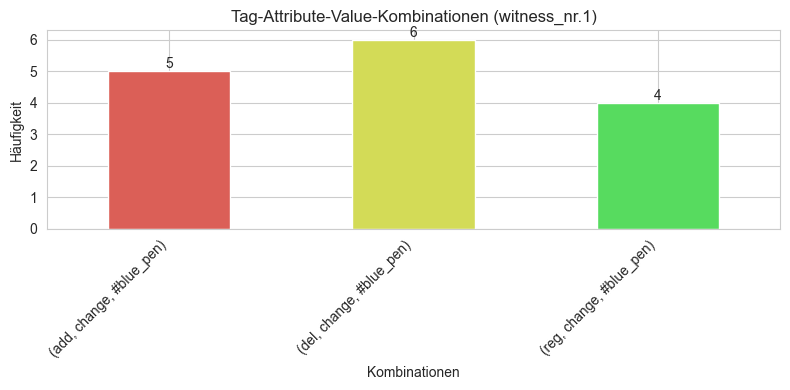

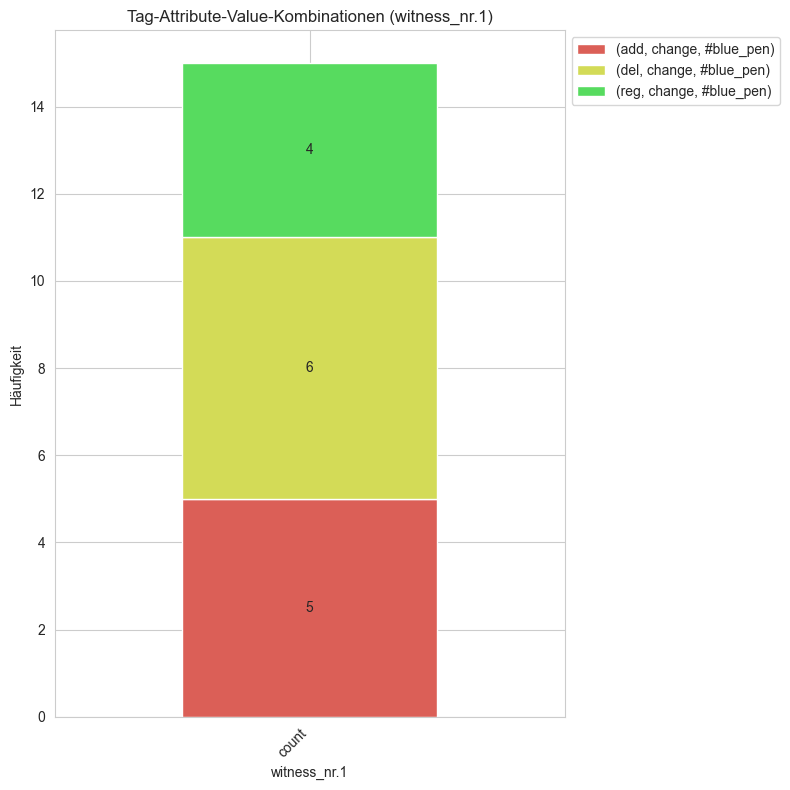

      tag  count
0     add      5
1     del      6
2  choice      4
3    orig      4
4     reg      4


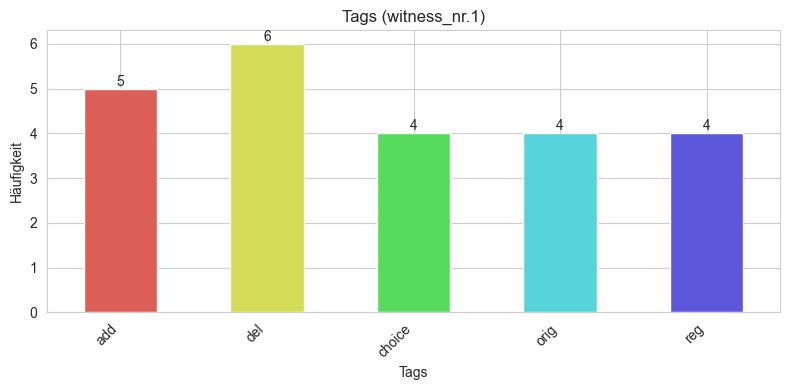

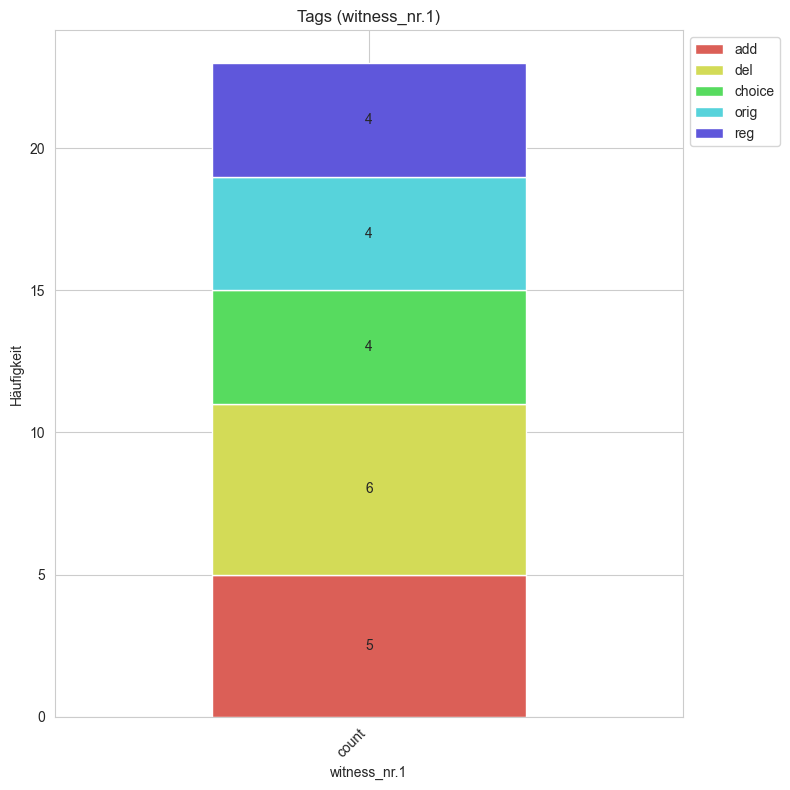

  attribute  count
0    change     15


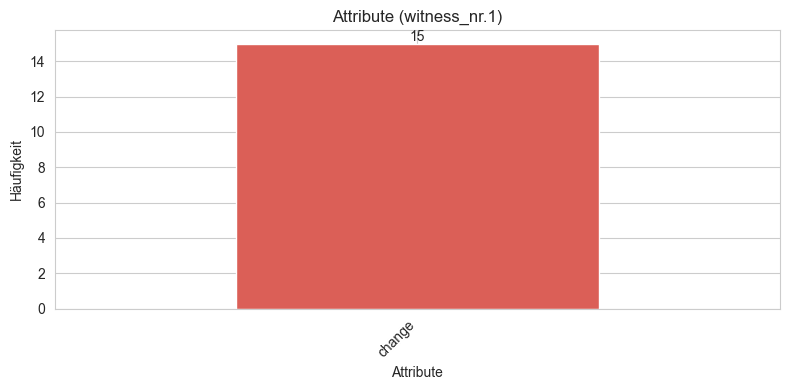

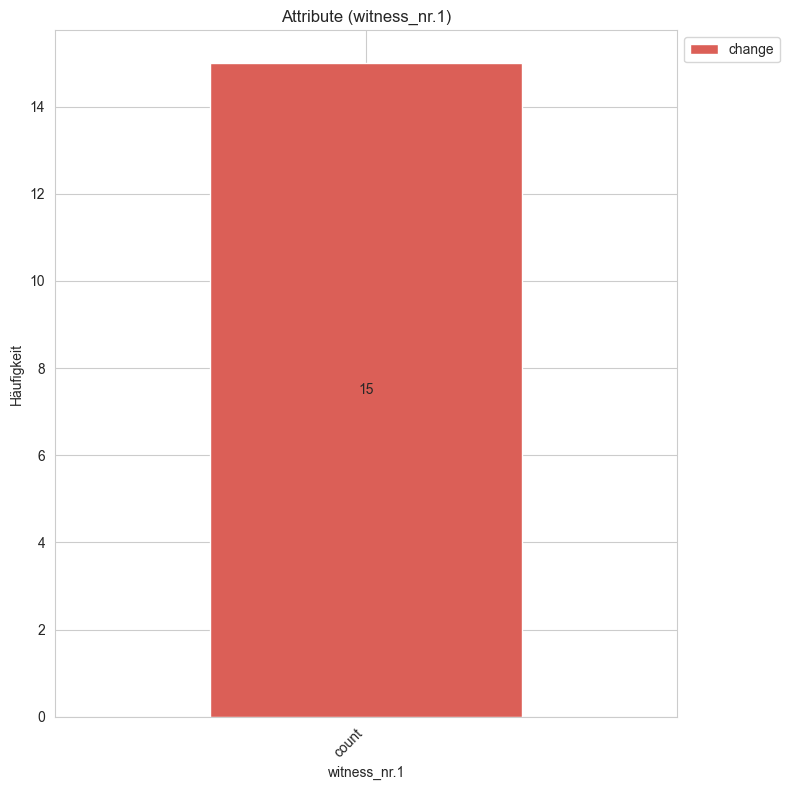

  attribute-value  count
0       #blue_pen     15


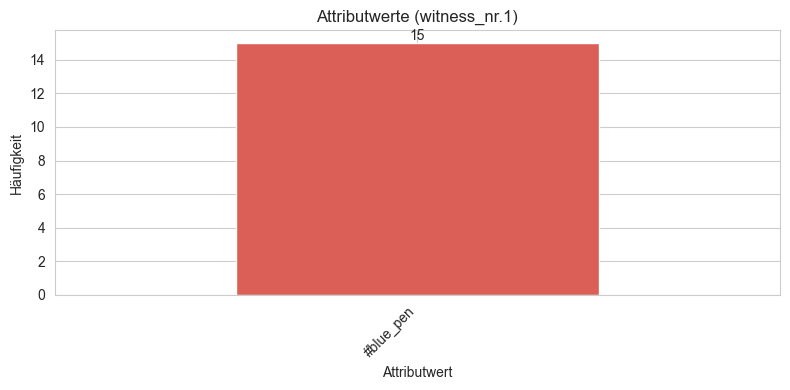

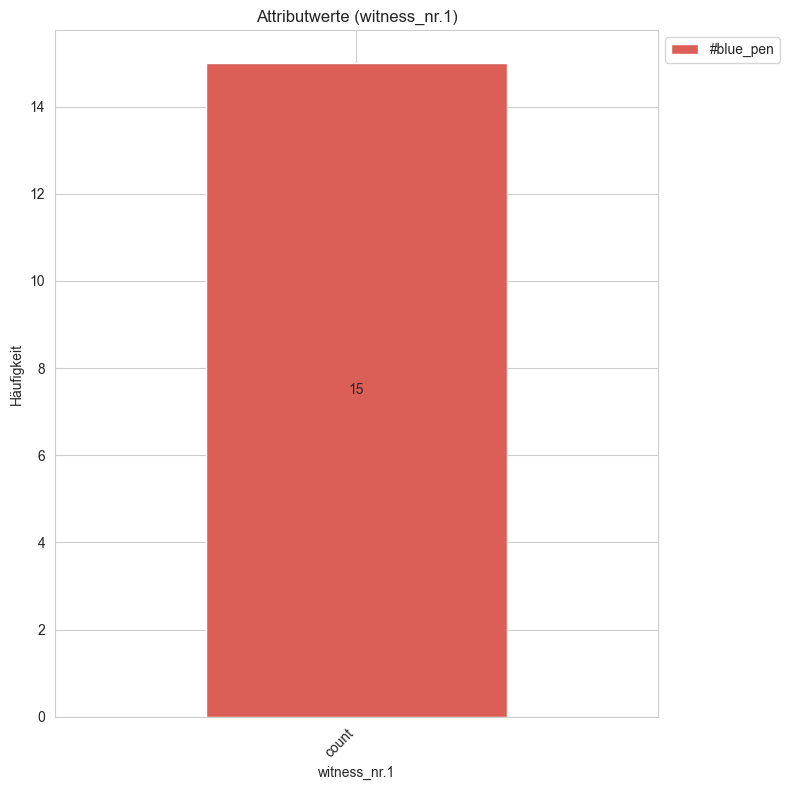

witness_nr.2
    tag - attribute - value  count
0  (del, change, #blue_pen)      4
1  (add, change, #blue_pen)      3
2  (reg, change, #blue_pen)      3


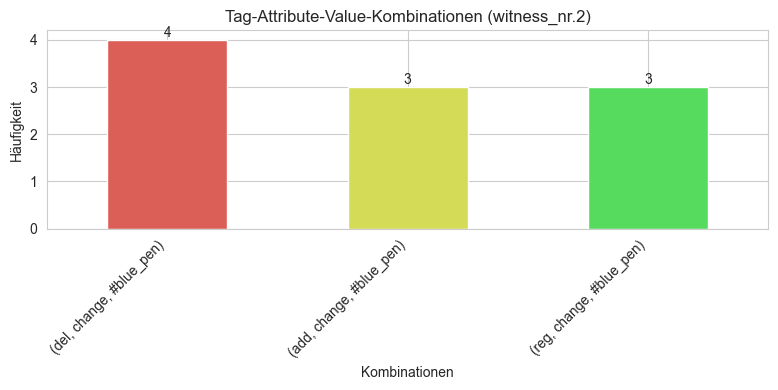

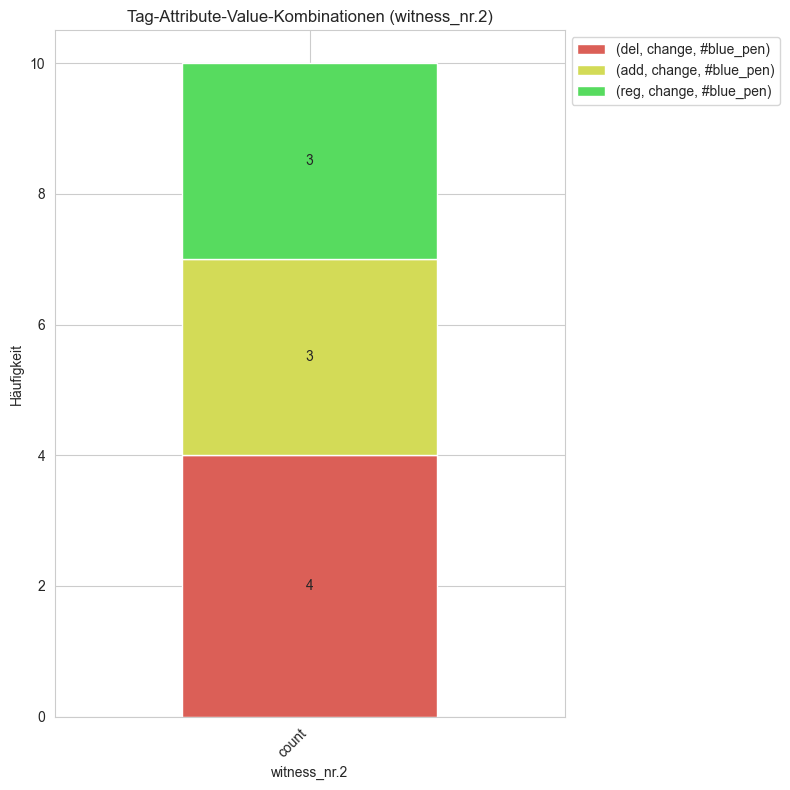

      tag  count
0     del      4
1     add      3
2  choice      3
3    orig      3
4     reg      3


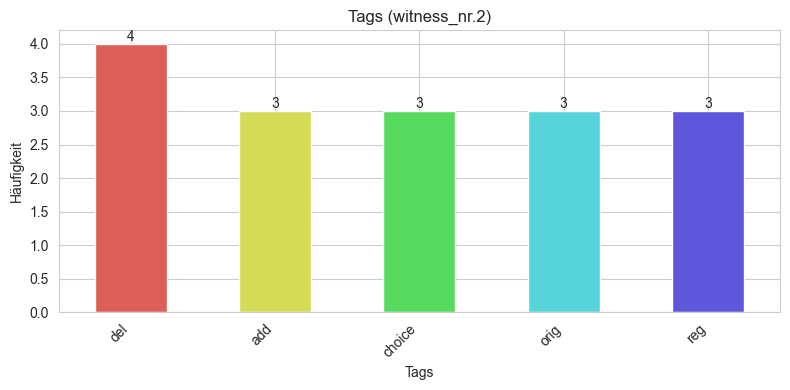

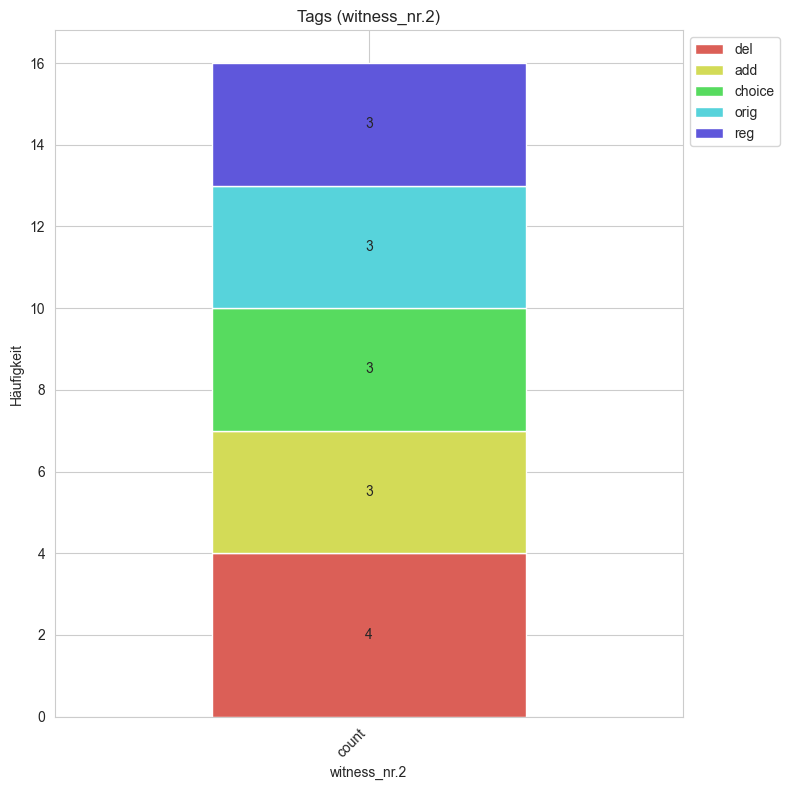

  attribute  count
0    change     10


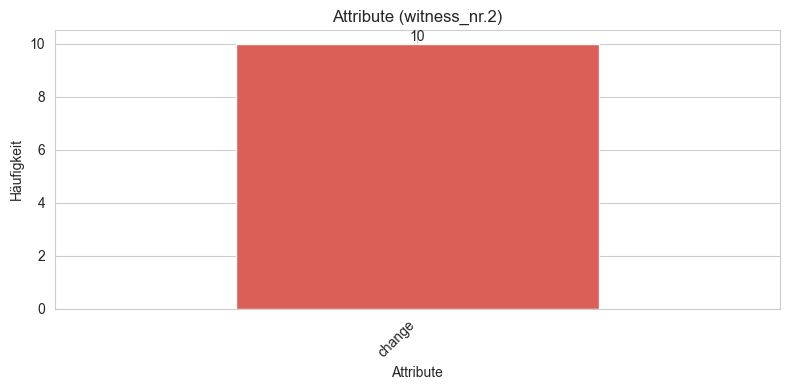

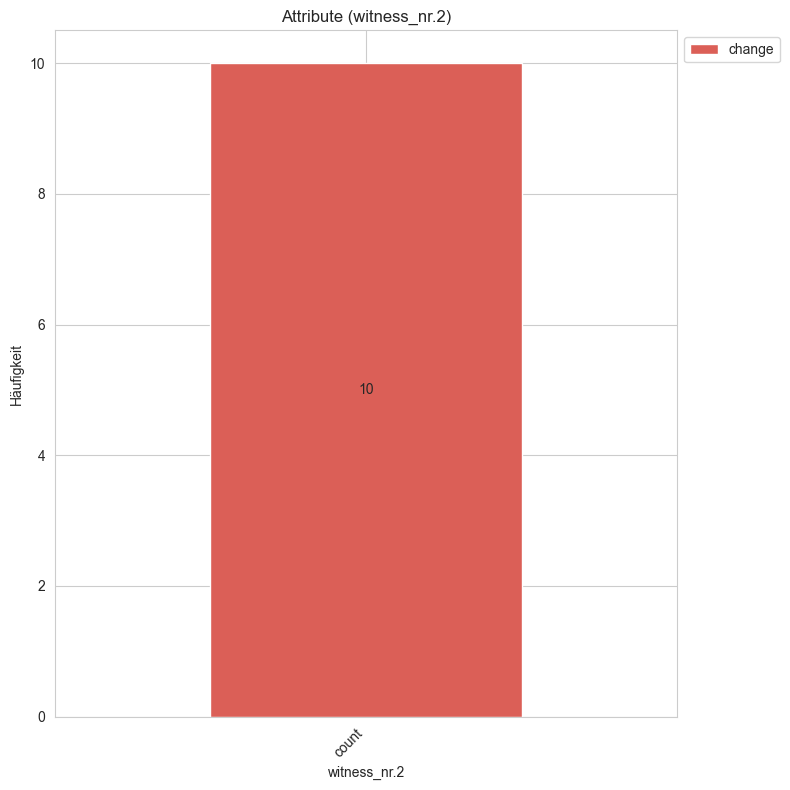

  attribute-value  count
0       #blue_pen     10


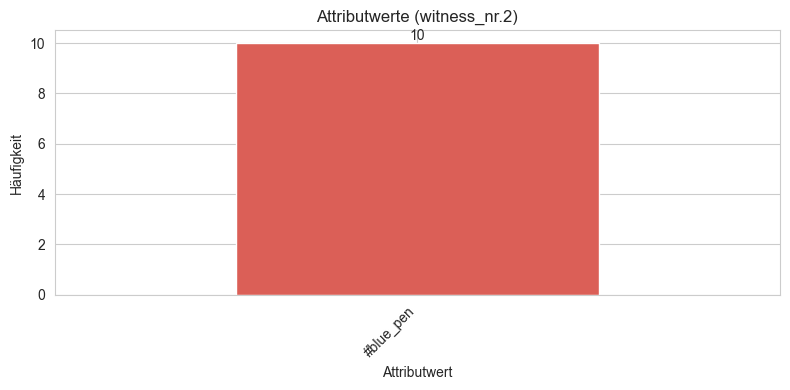

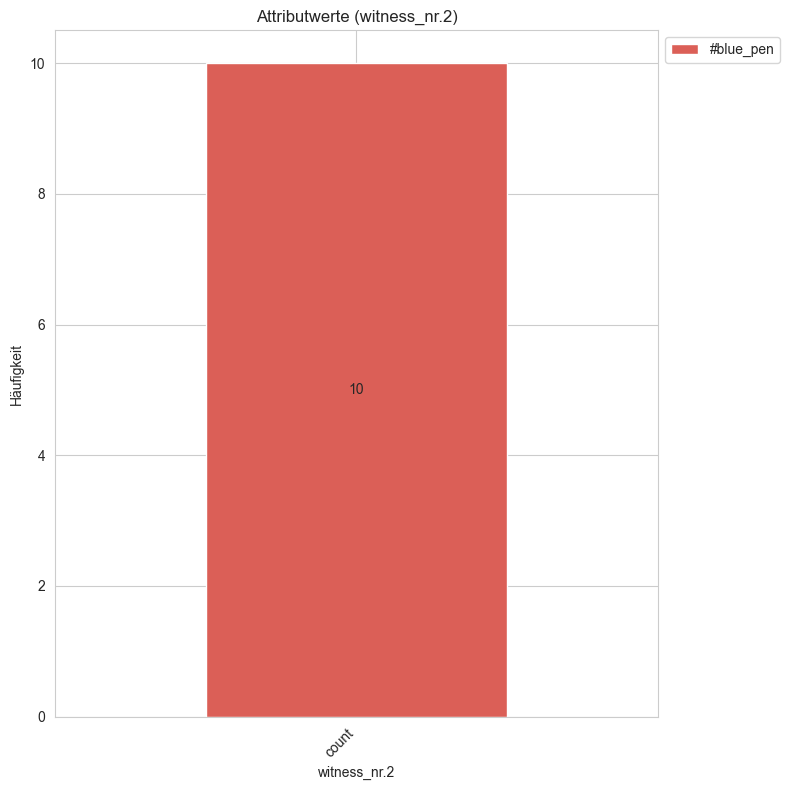

witness_nr.3
    tag - attribute - value  count
0  (add, change, #blue_pen)      6
1  (del, change, #blue_pen)      3
2  (reg, change, #blue_pen)      1


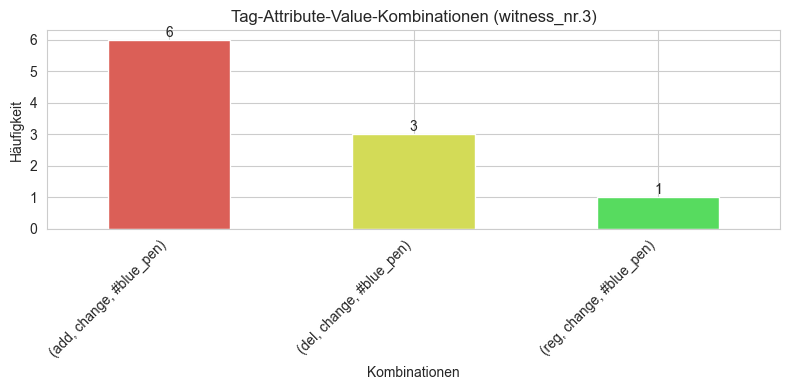

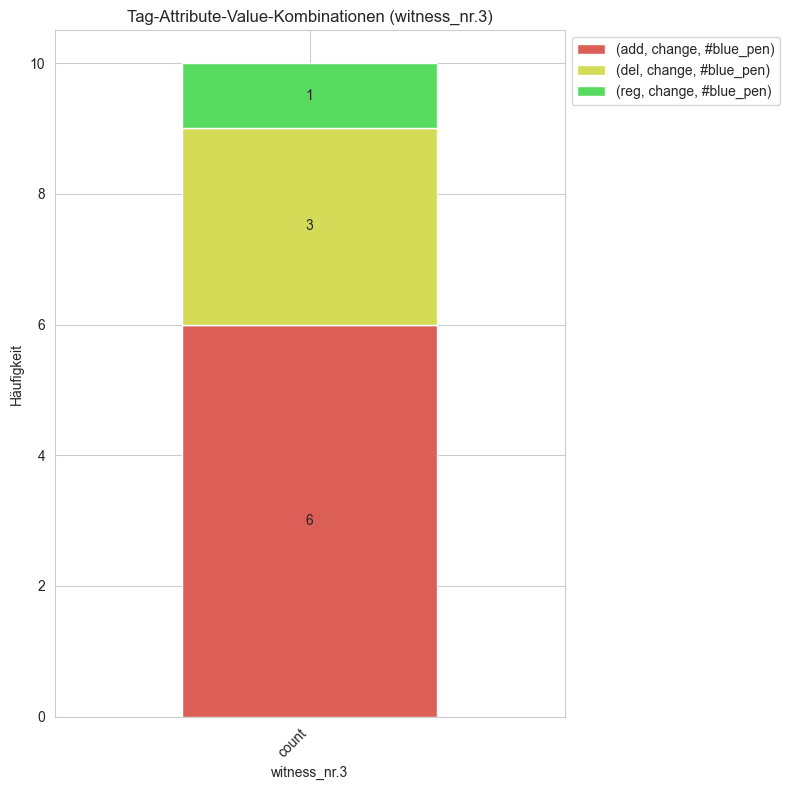

      tag  count
0     add      6
1     del      3
2  choice      1
3    orig      1
4     reg      1


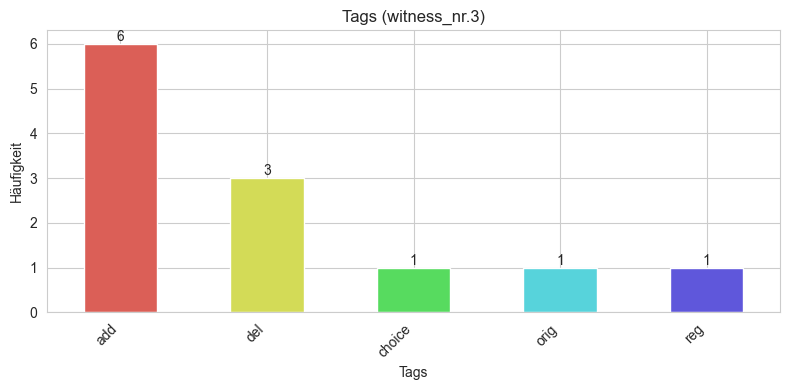

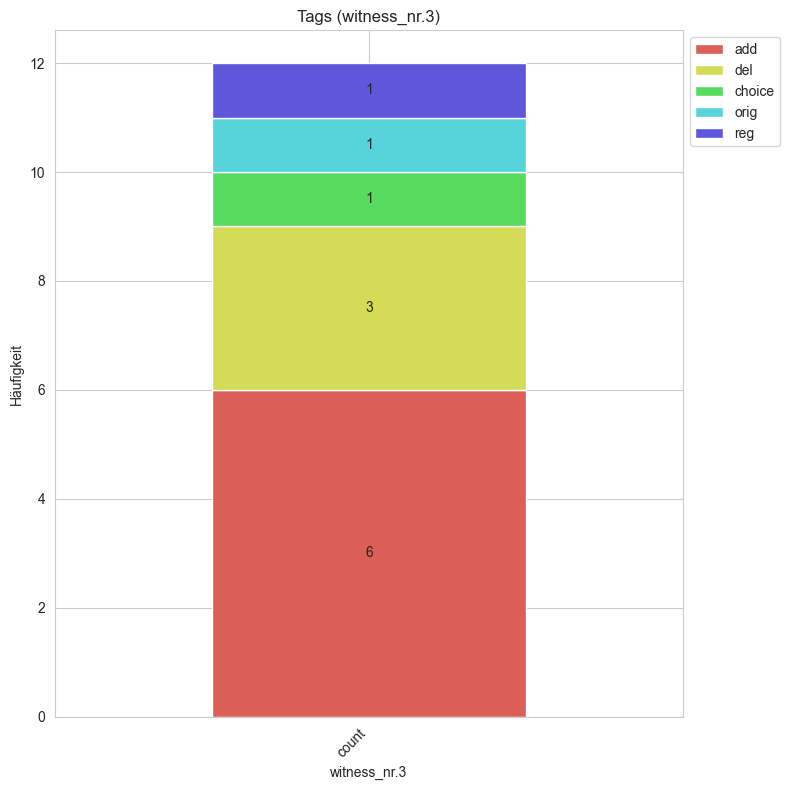

  attribute  count
0    change     10


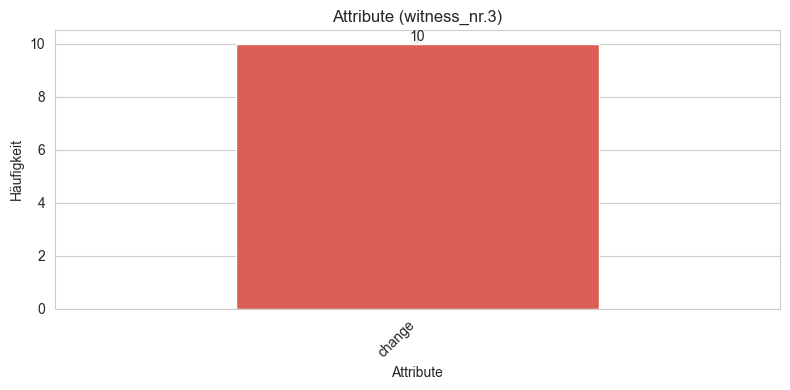

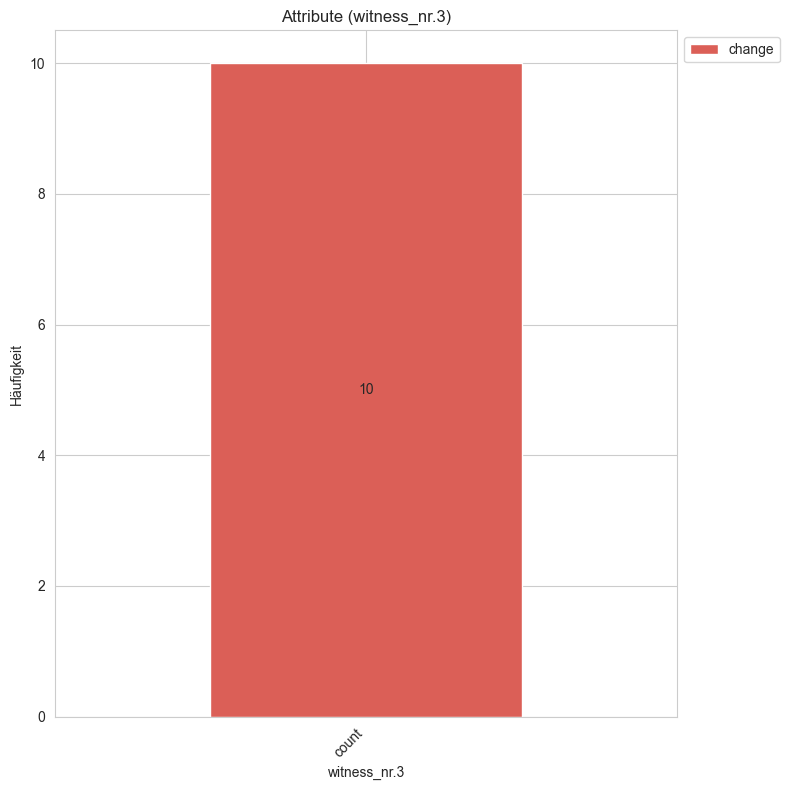

  attribute-value  count
0       #blue_pen     10


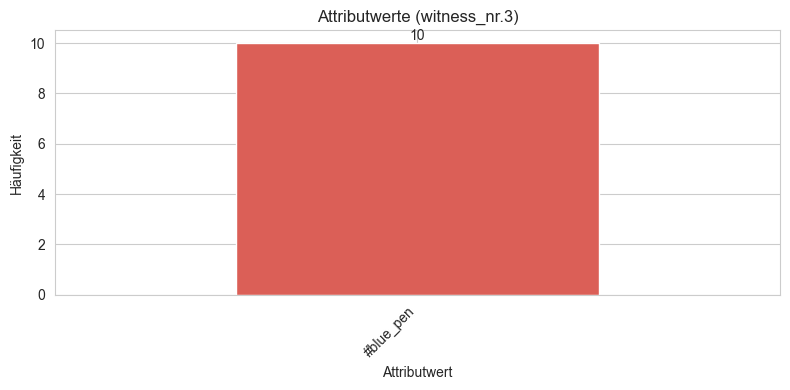

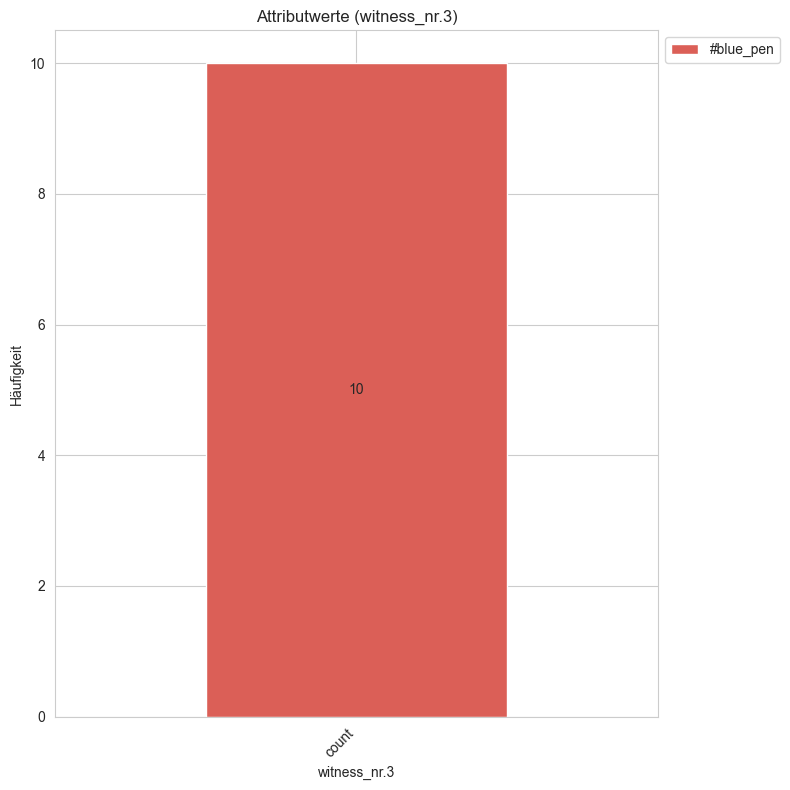

witness_nr.4
    tag - attribute - value  count
0  (del, change, #blue_pen)      1
1  (add, change, #blue_pen)      1


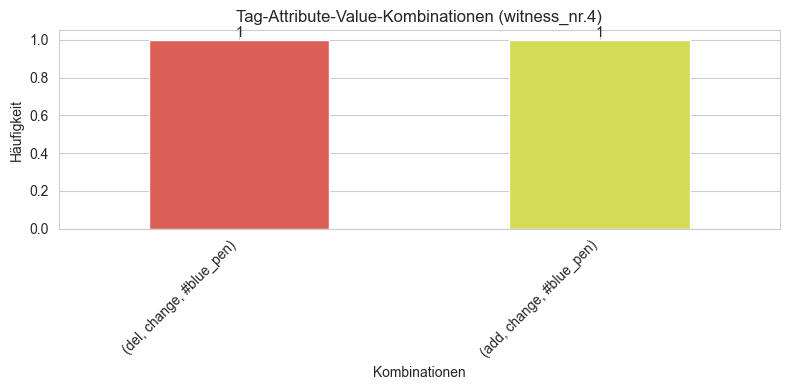

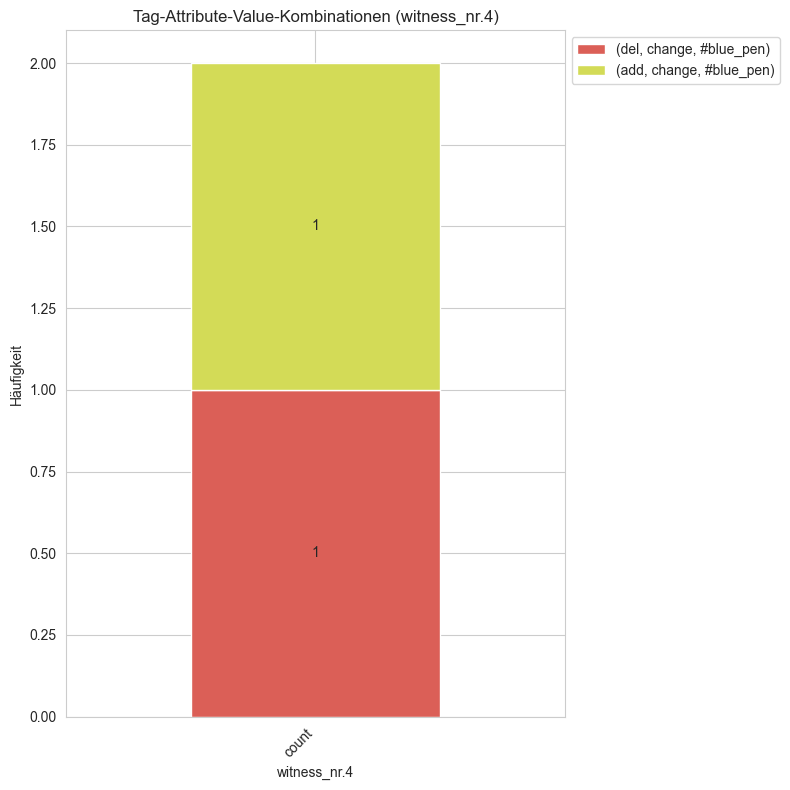

   tag  count
0  del      1
1  add      1


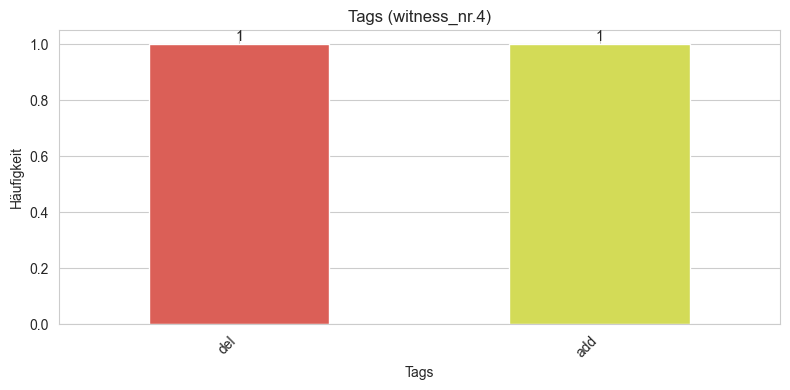

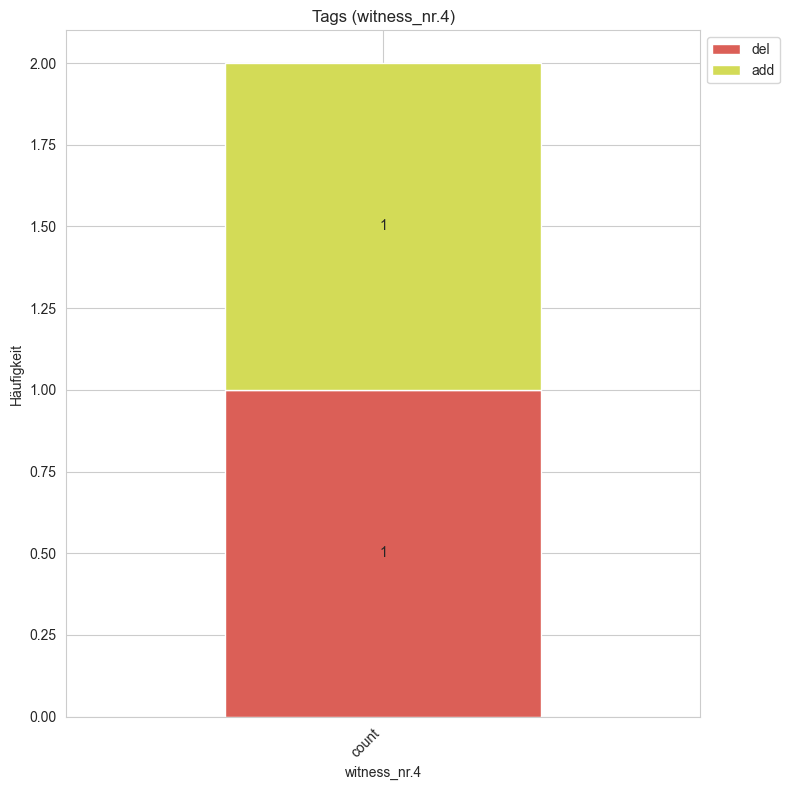

  attribute  count
0    change      2


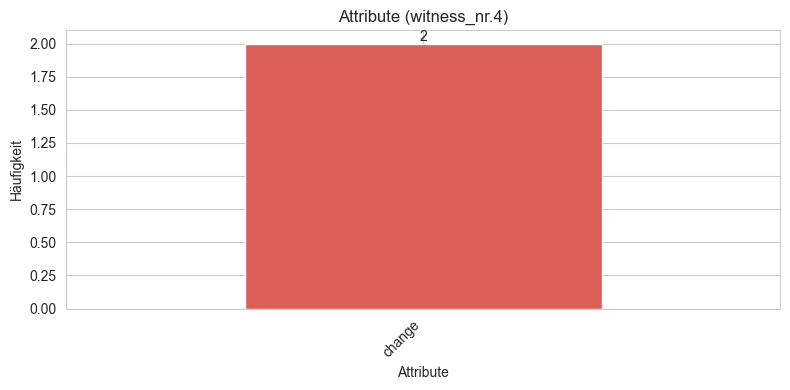

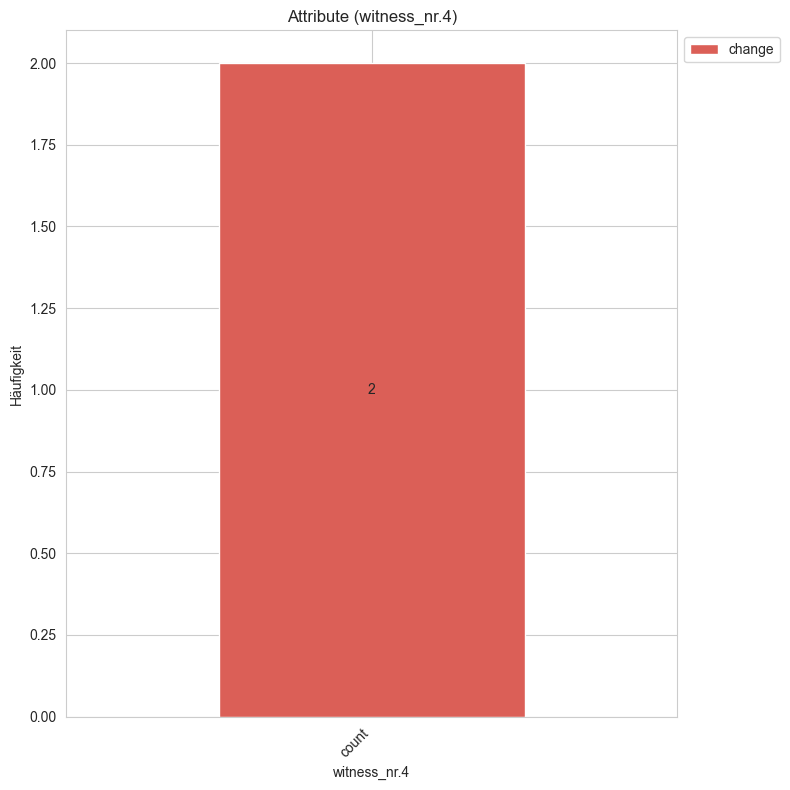

  attribute-value  count
0       #blue_pen      2


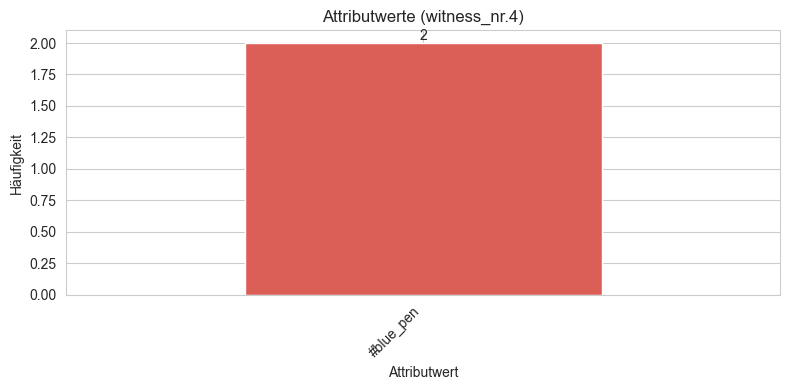

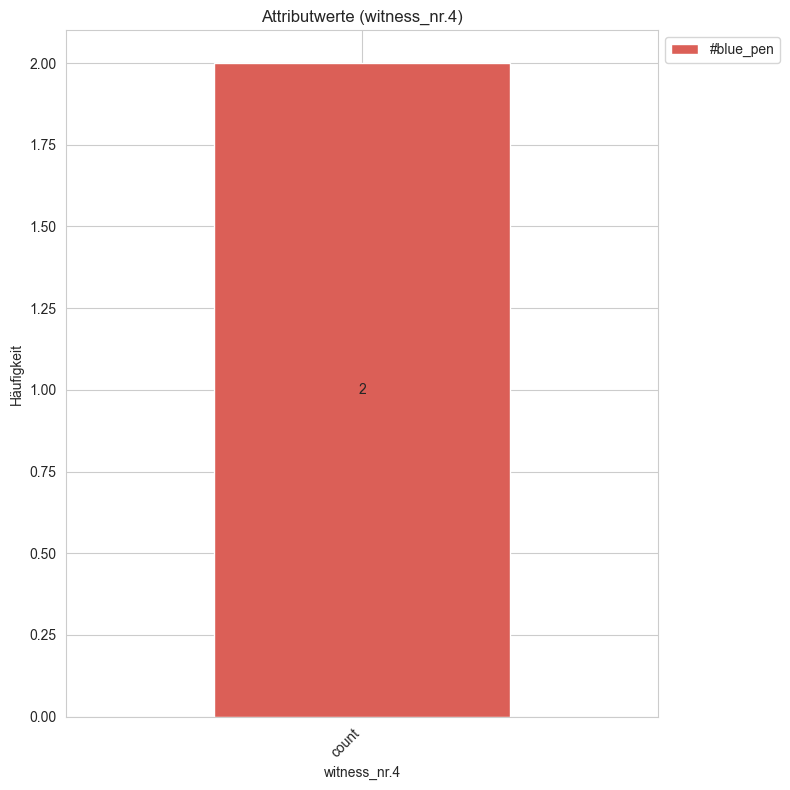

In [6]:
extractallinterferences(poem)

### Visualisierungen im Vergleich

##### Alle Kombinationen (nicht unbedingt sinnvoll bei vielen unterschiedlichen Kombinationen)

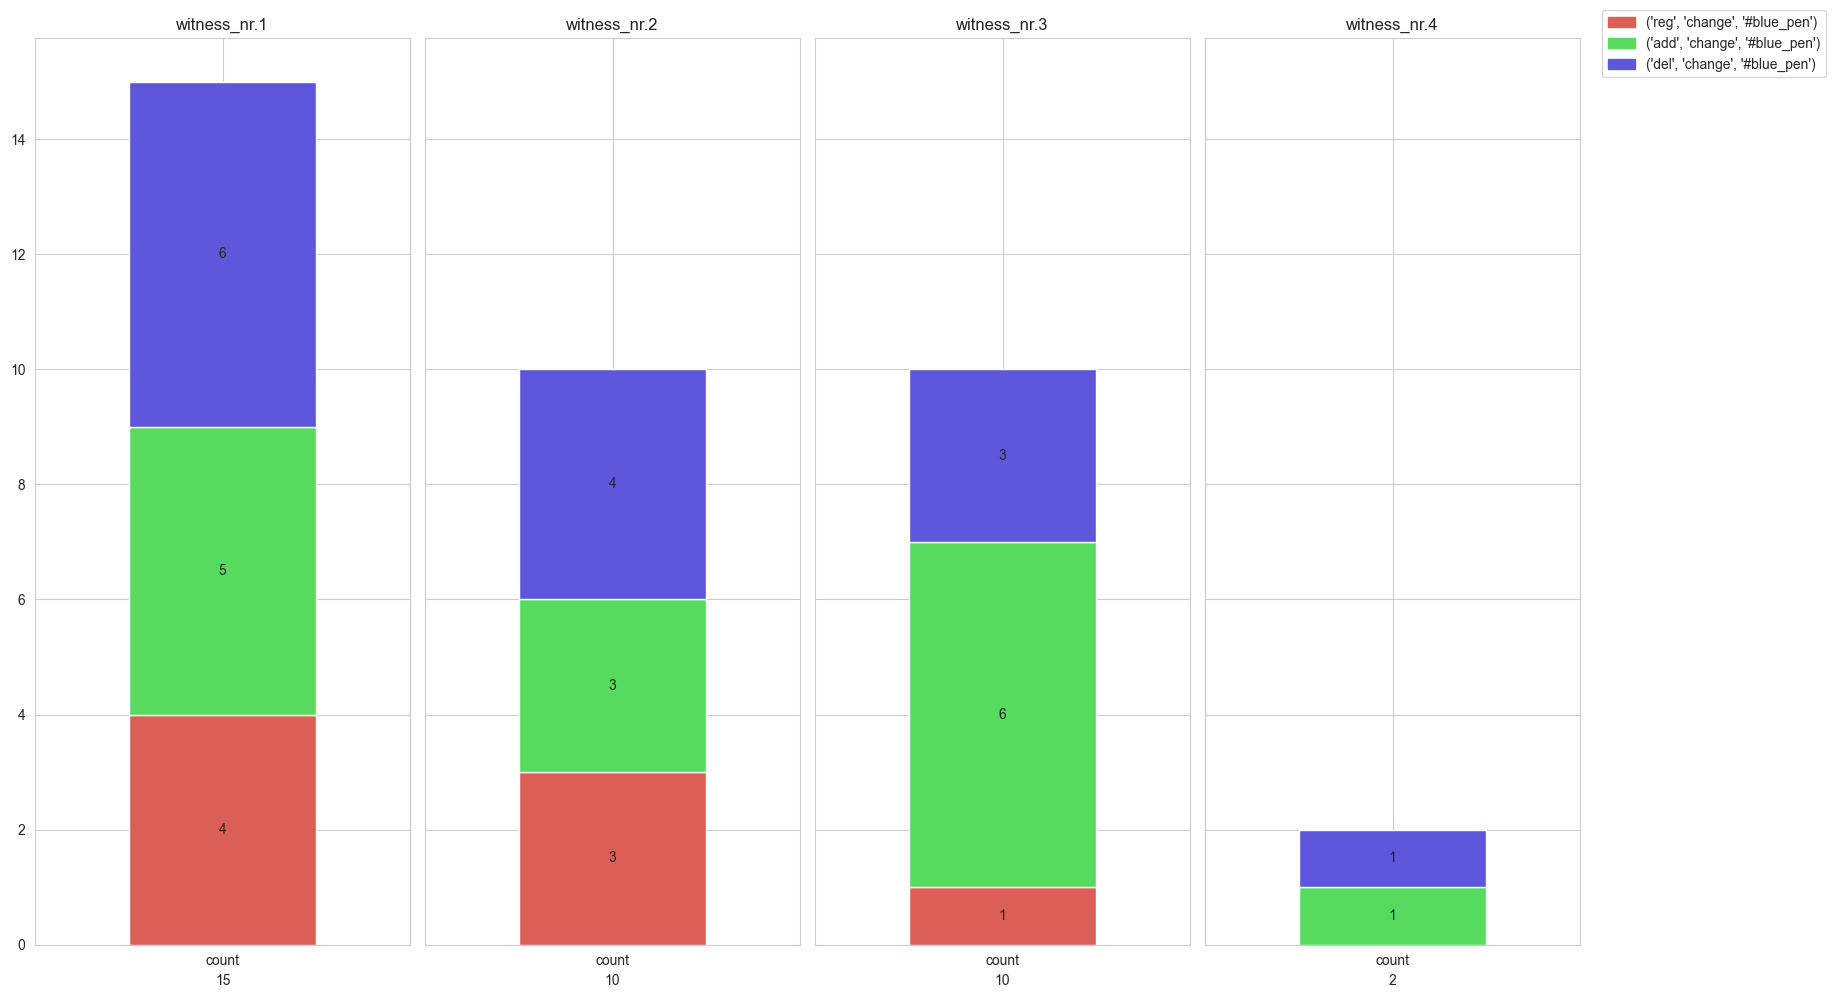

In [7]:
# Directory
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Eingrifftags+Attribute_csvs/'

# Filtern der CSV-Dokumente
csv_files = [filename for filename in os.listdir(directory) if filename.startswith('allcombinations') and filename.endswith('.csv')]

# CSVs als dfs laden
dfs = {}
for csv_file in csv_files:
    # Name für df extrahieren aus dem Filename
    df_name = csv_file.split('allcombinations_')[-1].split('_df.csv')[0]
    
    # read_csv
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    # Name zuweisen
    dfs[df_name] = df

# Visualisierung
# Alle einzigartigen Kategorien sammeln
all_categories = set()
for df in dfs.values():
    all_categories.update(df['tag - attribute - value'])

# Farbpalette
palette = sns.color_palette("hls", n_colors=len(all_categories))

# Kategorien und Palette mappen
category_color_map = dict(zip(all_categories, palette))

# Kategorien und Labels mappen
label_map = {category: category.split("-")[0] for category in all_categories}

# 1 Plot mit 1 Reihe und Spalten nach Anzahl der Dfs
num_dfs = len(dfs)
fig, axes = plt.subplots(1, num_dfs, figsize=(16, 10), sharey=True)

# handles und labels
legend_handles = []
legend_labels = set()  # einzigartige Legendenlabels

# Threshold für Vorkommnisse von Kategorien
threshold = 0

# Subplots: stacked bar charts für jeden Df
for idx, (df_name, df) in enumerate(dfs.items()):
    ax = axes[idx] if num_dfs > 1 else axes 
    total = df['count'].sum()
    # df für stacked bar chart
    stacked_df = df.set_index('tag - attribute - value').T

    # fehlende Kategorien hinzufügen und auf 0 setzen
    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0  

    # Reordern
    stacked_df = stacked_df.reindex(columns=all_categories)
    
    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None)

    # xlabel, Titel und ticks
    ax.set_xlabel(total, fontsize=10, rotation=0)
    ax.set_title(f'{df_name}')
    ax.tick_params(axis='x', rotation=0)

    # Labels für die Kategorien
    for container in ax.containers:
        labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues]  # nur Kategorien über dem Threshold ( also != 0)
        ax.bar_label(container, labels=labels, label_type='center')
    
    unique_categories = set(stacked_df.columns)
    for category in unique_categories:
        if category not in legend_labels: 
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category)

# Legende
fig.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper left')

# Layout
plt.tight_layout()

# Speichern
plt.savefig(f'VisVergleich_allcombinations_{poem}_revisioninterferences.png')

# Show
plt.show()


### Alle Tags, die vorkommen

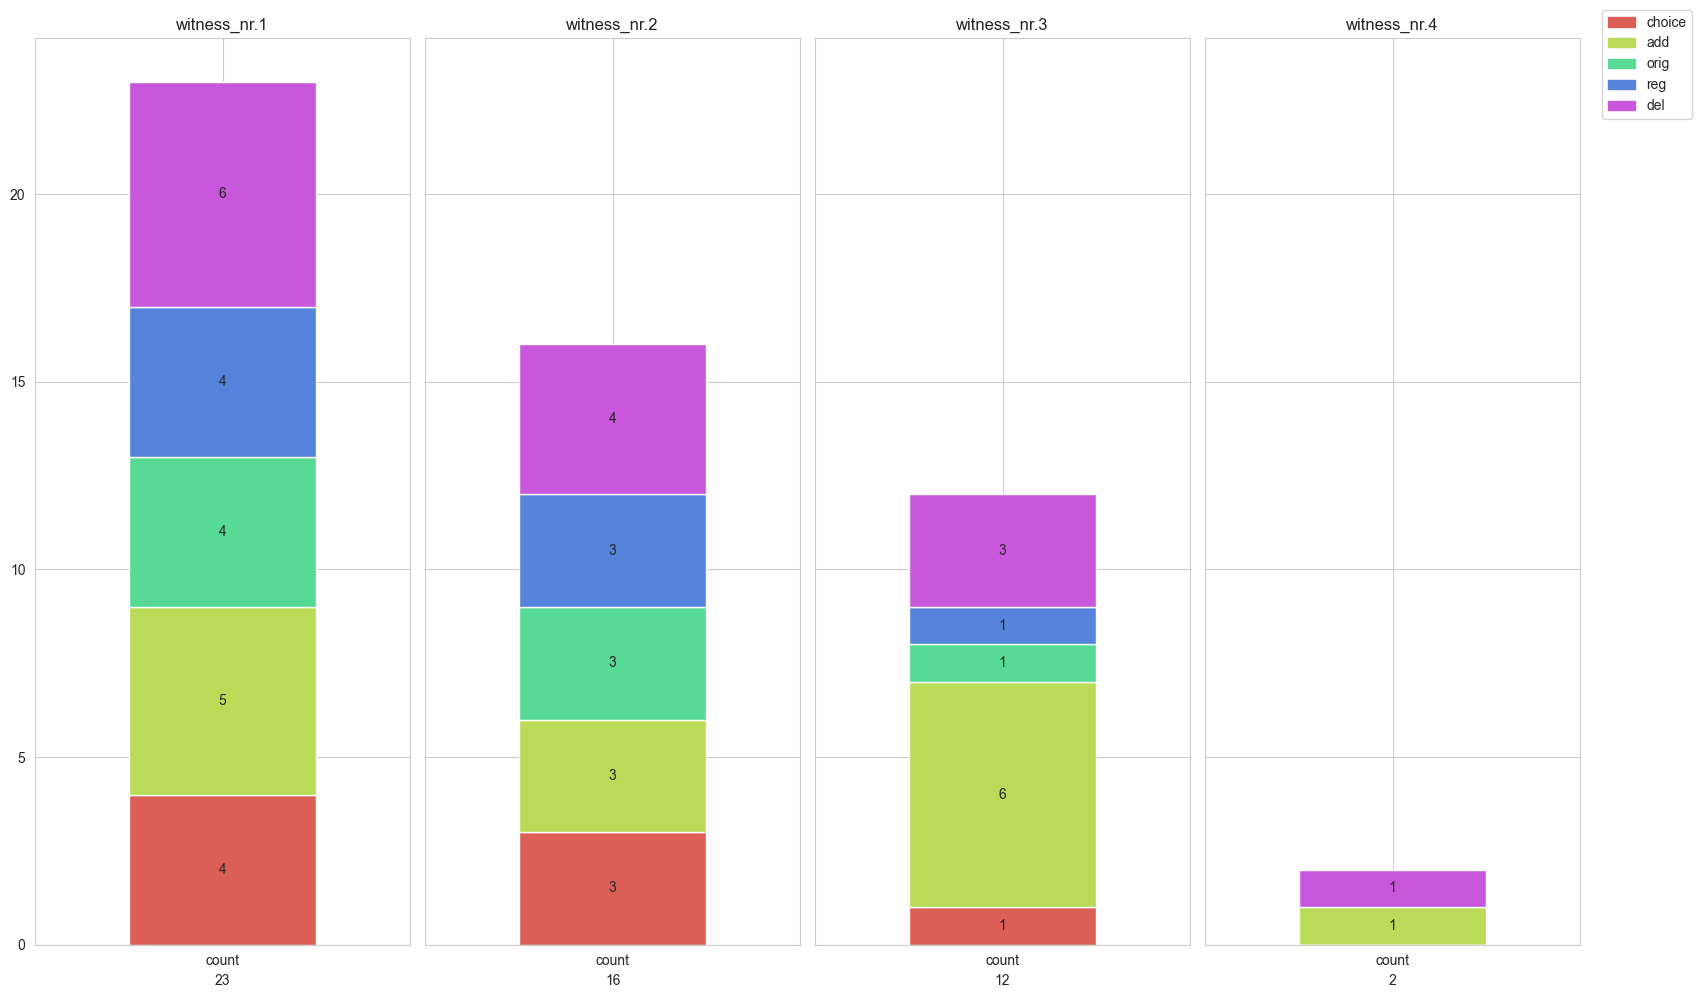

In [8]:

# Directory
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Eingrifftags+Attribute_csvs/'

# Filtern der CSV-files
csv_files = [filename for filename in os.listdir(directory) if filename.startswith('alltags') and filename.endswith('.csv')]

# CSV-files als DataFrames laden
dfs = {}
for csv_file in csv_files:
    # Name für Df
    df_name = csv_file.split('alltags_')[-1].split('_df.csv')[0]
    
    # read_csv
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    # Name dem df zuordnen
    dfs[df_name] = df


# Visualisierung

# Kategorien sammeln
all_categories = set()
for df in dfs.values():
    all_categories.update(df['tag'])

# Farbpalette
palette = sns.color_palette("hls", n_colors=len(all_categories))

# Kategorien + Palette
category_color_map = dict(zip(all_categories, palette))

# Kategorien => Labels
label_map = {category: category.split("-")[0] for category in all_categories}

# Plot, 1 Reihe, Spalten nach Anzahl von dfs
num_dfs = len(dfs)
fig, axes = plt.subplots(1, num_dfs, figsize=(16, 10), sharey=True)

# handles und labels
legend_handles = []
legend_labels = set() 

# Threshold 
threshold = 0

# Plot stacked bar charts pro df
for idx, (df_name, df) in enumerate(dfs.items()):
    ax = axes[idx] if num_dfs > 1 else axes 
    total = df['count'].sum()
    stacked_df = df.set_index('tag').T

    # fehlende Kategorien auf 0 setzen
    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0

     # Reordering
    stacked_df = stacked_df.reindex(columns=all_categories)
    
    # Plot
    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None)

    ax.set_xlabel(total, fontsize=10, rotation=0)
    ax.set_title(f'{df_name}')
    ax.tick_params(axis='x', rotation=0)

    # Labels innerhalb der Bars
    for container in ax.containers:
        labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues]  # Filter labels based on threshold
        ax.bar_label(container, labels=labels, label_type='center')
    
    # handles für Legende
    unique_categories = set(stacked_df.columns)
    for category in unique_categories:
        if category not in legend_labels:  
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category)  

# Legende
fig.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper left')

# Layout
plt.tight_layout()

# Save
plt.savefig(f'VisVergleich_alltags_{poem}_revisioninterferences.png')

# Show
plt.show()


### Alle Attribute, die vorkommen

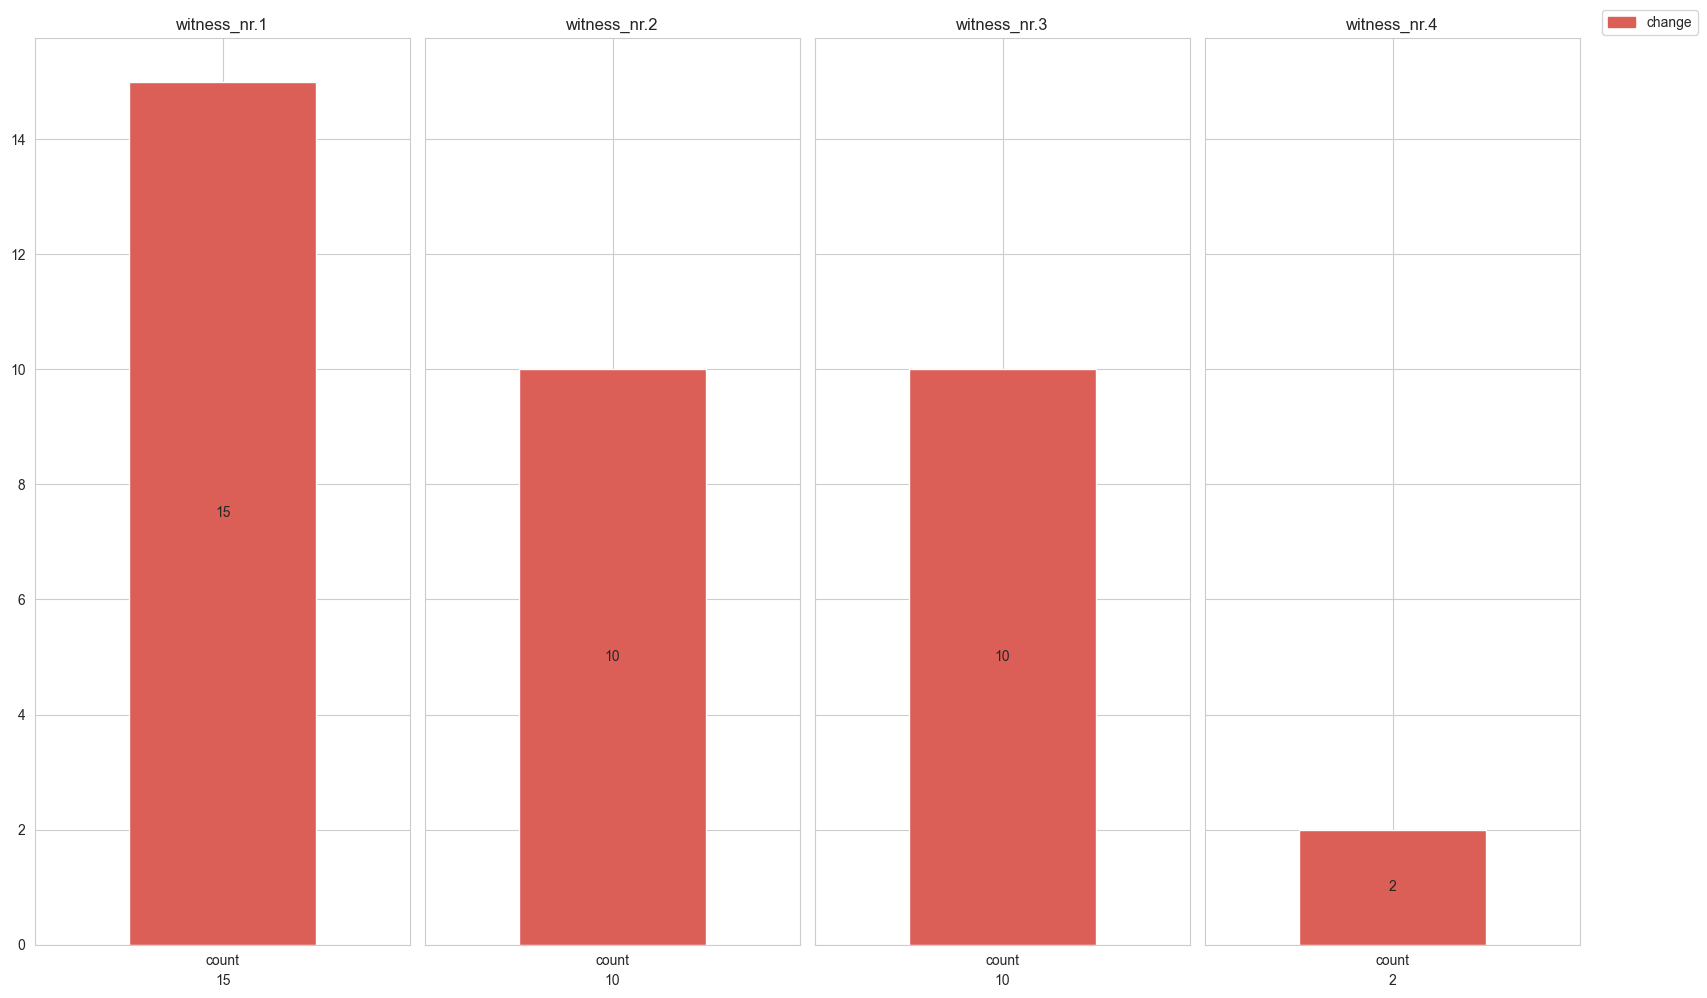

In [9]:
# Directory 
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Eingrifftags+Attribute_csvs/'

# Filtern nach CSV-files
csv_files = [filename for filename in os.listdir(directory) if filename.startswith('onlyattributes') and filename.endswith('.csv')]

dfs = {}
for csv_file in csv_files:
    # Name
    df_name = csv_file.split('onlyattributes_')[-1].split('_df.csv')[0]
    
    # CSV als df einlesen
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    # Name dem df zuweisen
    dfs[df_name] = df


# Visualisierung

# Kategorien
all_categories = set()
for df in dfs.values():
    all_categories.update(df['attribute'])

# Farbpalette
palette = sns.color_palette("hls", n_colors=len(all_categories))

# Kategorien + Farben
category_color_map = dict(zip(all_categories, palette))

# Kategorien + Labels
label_map = {category: category.split("-")[0] for category in all_categories}

# 1 Plot, 1 Reihe, num_dfs Spalten
num_dfs = len(dfs)
fig, axes = plt.subplots(1, num_dfs, figsize=(16, 10), sharey=True)

# Handles und Labels
legend_handles = []
legend_labels = set()

# Threshold 
threshold = 0

# Plot stacked bar charts pro DF
for idx, (df_name, df) in enumerate(dfs.items()):
    total = df['count'].sum()
    ax = axes[idx] if num_dfs > 1 else axes 
    stacked_df = df.set_index('attribute').T

    # fehlende Kategorien auf 0 setzen
    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0

     # Reordern
    stacked_df = stacked_df.reindex(columns=all_categories)
    
    # Plot
    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None)

    ax.set_xlabel(total, fontsize=10, rotation=0)
    ax.set_title(f'{df_name}')
    ax.tick_params(axis='x', rotation=0)

    # Labels für die bars
    for container in ax.containers:
        labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues]  # Filter labels based on threshold
        ax.bar_label(container, labels=labels, label_type='center')
    
    unique_categories = set(stacked_df.columns)
    for category in unique_categories:
        if category not in legend_labels: 
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category) 

# Legende
fig.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

# Speichern
plt.savefig(f'VisVergleich_onlyattributes_{poem}_revisioninterferences.png')

# Show
plt.show()


### Attributwerte

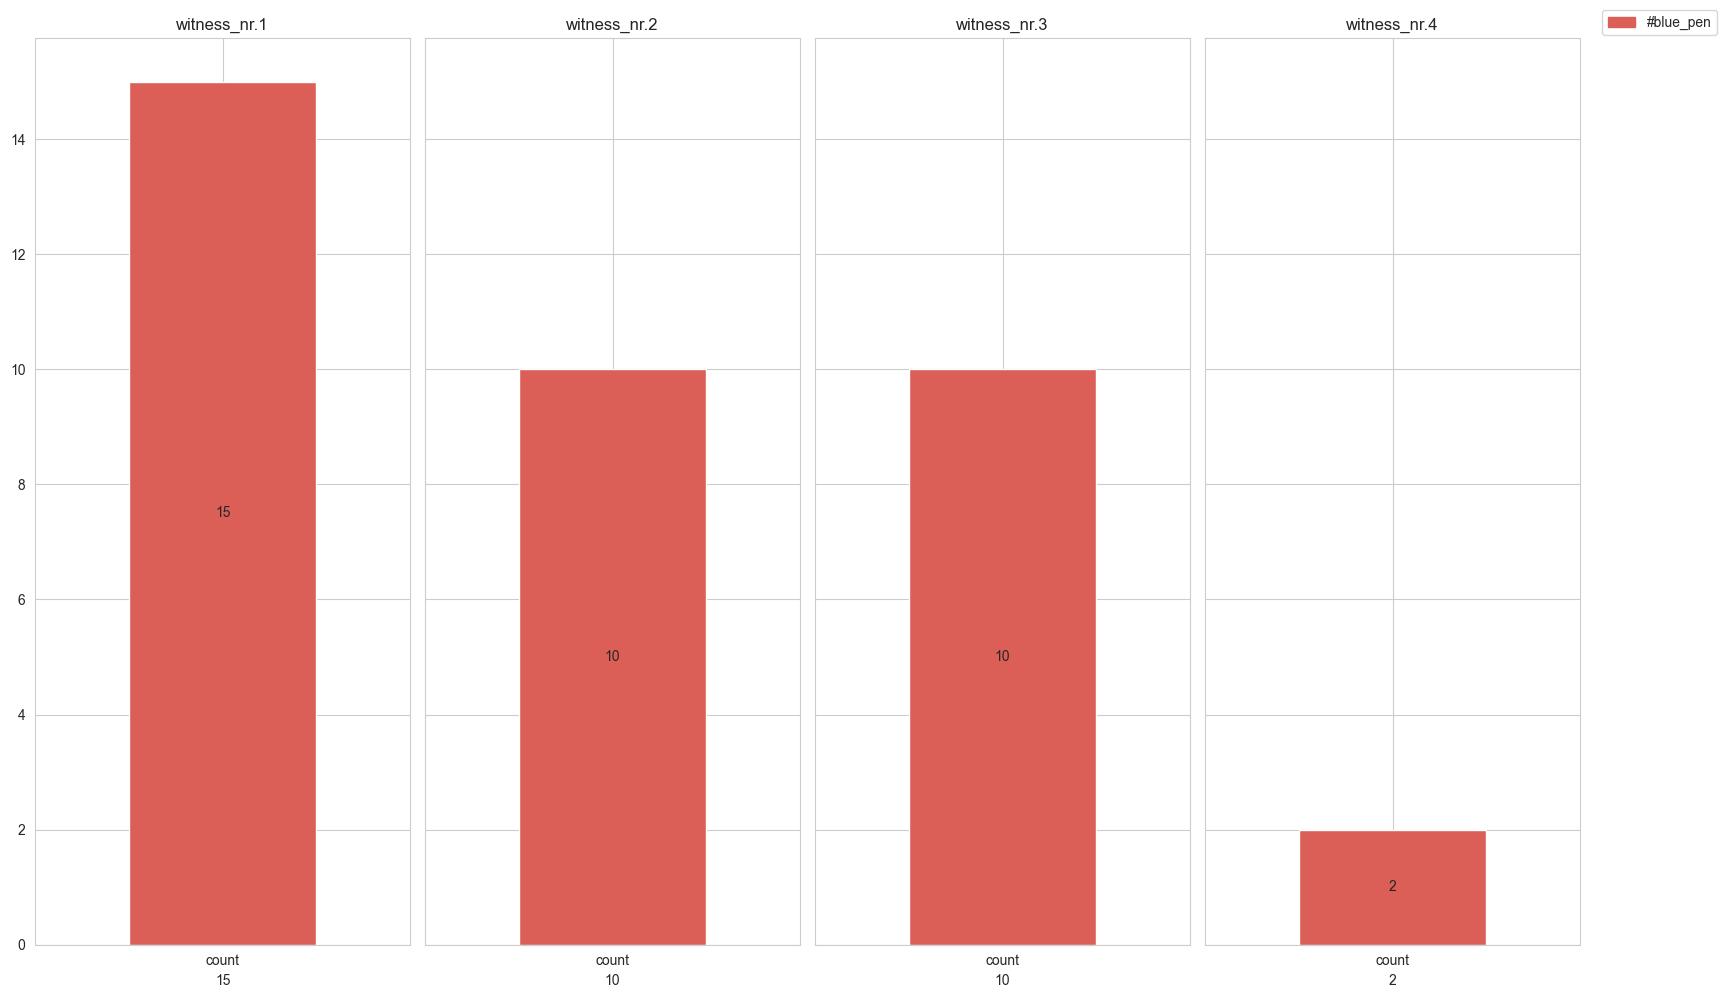

In [10]:
# Directory
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Eingrifftags+Attribute_csvs/'

# Filtern
csv_files = [filename for filename in os.listdir(directory) if filename.startswith('onlyvalues') and filename.endswith('.csv')]

# Laden der CSV-files
dfs = {}
for csv_file in csv_files:
    # Name
    df_name = csv_file.split('onlyvalues_')[-1].split('_df.csv')[0]
    df = pd.read_csv(os.path.join(directory, csv_file))
    dfs[df_name] = df


# Visualisierung

# Kategorien
all_categories = set()
for df in dfs.values():
    all_categories.update(df['attribute-value'])

# Palette
palette = sns.color_palette("hls", n_colors=len(all_categories))

# Kategorien X Palette
category_color_map = dict(zip(all_categories, palette))

# Kategorien X Labels
label_map = {category: category.split("-")[0] for category in all_categories}

# 1 Plot, 1 Reihe, num_dfs Spalten
num_dfs = len(dfs)
fig, axes = plt.subplots(1, num_dfs, figsize=(16, 10), sharey=True)

legend_handles = []
legend_labels = set()  

# Threshold
threshold = 0

# Plot 
for idx, (df_name, df) in enumerate(dfs.items()):
    ax = axes[idx] if num_dfs > 1 else axes  
    total = df['count'].sum()
    stacked_df = df.set_index('attribute-value').T

    # fehlende Kategorien = 0
    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0 

    stacked_df = stacked_df.reindex(columns=all_categories)
    
    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None)

    ax.set_xlabel(total, fontsize=10, rotation=0)
    ax.set_title(f'{df_name}')
    ax.tick_params(axis='x', rotation=0)

    for container in ax.containers:
        labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues]  # Filter labels based on threshold
        ax.bar_label(container, labels=labels, label_type='center')
        
    unique_categories = set(stacked_df.columns)
    for category in unique_categories:
        if category not in legend_labels:  # Avoid redundant labels
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category)  # Add category to the set of legend labels

# Legende
fig.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper left')

# Layout
plt.tight_layout()

# Save
plt.savefig(f'VisVergleich_onlyvalues_{poem}_revisioninterferences.png')

# Show
plt.show()




## Analyse der POS-Verteilung in den Textzeugen und extrahierten Textstufen

Zuerst aus den csvs einlesen und als Dictionaries speichern, um sie gemeinsam in einem Plot zu visualisieren.

In [11]:
foldername = f"{poem}_VisVergleich_POS-Verteilung" # Foldername mit Poemname bestimmen
#os.makedirs(f"C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{foldername}") # Folder kreiern

In [12]:
# Directory 
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_text_pos_csvs'

# CSV-Dokumente filtern
csv_files = [filename for filename in os.listdir(directory) if filename.startswith('Token-POS_extrahierte_revision_') and filename.endswith('.csv')]

 
pos_dfs = {} # dictionary, um alle dfs zu speichern
rel_pos_dfs = {} # dictionary, um alle dfs mit relativen counts zu speichern

for csv_file in csv_files:
    # Name aus dem Dateiname rausnehmen nach "revision" aber vor "df.csv"
    df_name = csv_file.split('Token-POS_extrahierte_revision_')[-1].split('_df.csv')[0]
    
    if df_name != 'published': # published wird rausgenommen, um als letztes hinzugefügt zu werden (später letzte Stelle bei Visualisierungen)
        
        # dann jede csv-Datei als Dataframe laden
        file_path = os.path.join(directory, csv_file)
        df = pd.read_csv(file_path, sep=';')

        # für absolute counts:
        df = df["pos"].value_counts().reset_index() # die Vorkommnisse von POS zählen mit .value_counts()
        df.columns = ['pos', 'count'] # im df die neuen Spalten "pos" und "count" definieren
        pos_dfs[df_name] = df #df zum dictionary hinzufügen
        
        # für relative counts:
        rel_df = df.copy()
        total_count = df['count'].sum()
        rel_df['count'] = rel_df['count'] / total_count
        rel_pos_dfs[df_name] = rel_df #df zum dictionary hinzufügen mit relativen counts

# als 'letztes' das csvfile "published" hinzufügen
for csv_file in csv_files:
    # Name aus dem Dateiname rausnehmen nach "revision" aber vor "df.csv"
    df_name = csv_file.split('Token-POS_extrahierte_revision_')[-1].split('_df.csv')[0]
    if df_name == 'published':
        file_path = os.path.join(directory, csv_file)
        df = pd.read_csv(file_path, sep=';')
        df = df["pos"].value_counts().reset_index() # die Vorkommnisse von POS zählen mit .value_counts()
        df.columns = ['pos', 'count'] # im df die neuen Spalten "pos" und "count" definieren
        pos_dfs[df_name] = df

        # für relative counts:
        rel_df = df.copy()
        total_count = df['count'].sum()
        rel_df['count'] = rel_df['count'] / total_count
        rel_pos_dfs[df_name] = rel_df #df zum dictionary hinzufügen mit relativen counts


print(pos_dfs)

{'witness_nr.1_#blue_pen':      pos  count
0   NOUN     16
1    DET     12
2   VERB     10
3    ADV      8
4    ADP      6
5   PRON      6
6    ADJ      5
7  PUNCT      4
8    AUX      3
9  SCONJ      1, 'witness_nr.1_original':      pos  count
0   NOUN     16
1    DET     14
2   VERB     10
3    ADP      8
4    ADV      8
5   PRON      5
6  PUNCT      4
7    ADJ      4
8    AUX      3, 'witness_nr.2_#blue_pen':       pos  count
0    NOUN     19
1     DET     13
2    VERB     12
3     ADP      8
4    PRON      8
5     ADV      8
6     ADJ      6
7   PUNCT      2
8   CCONJ      2
9     AUX      1
10   PART      1, 'witness_nr.2_original':       pos  count
0    NOUN     19
1     DET     13
2    VERB     12
3    PRON      8
4     ADJ      8
5     ADP      7
6     ADV      7
7   PUNCT      2
8   CCONJ      2
9     AUX      1
10   PART      1, 'witness_nr.3_#blue_pen':       pos  count
0    NOUN     18
1    VERB     13
2     DET     12
3     ADV     10
4     ADP      9
5    PRON      8
6   

Korrekte Reihenfolge für die Visualisierung:

In [13]:
desired_order = ['witness_nr.1_original', 'witness_nr.1_#blue_pen', 'witness_nr.2_original', 'witness_nr.2_#blue_pen', 'witness_nr.3_original', 'witness_nr.3_#blue_pen', 'witness_nr.4_original', 'witness_nr.4_#blue_pen', 'published']

### Visualisierung (absolute Counts)

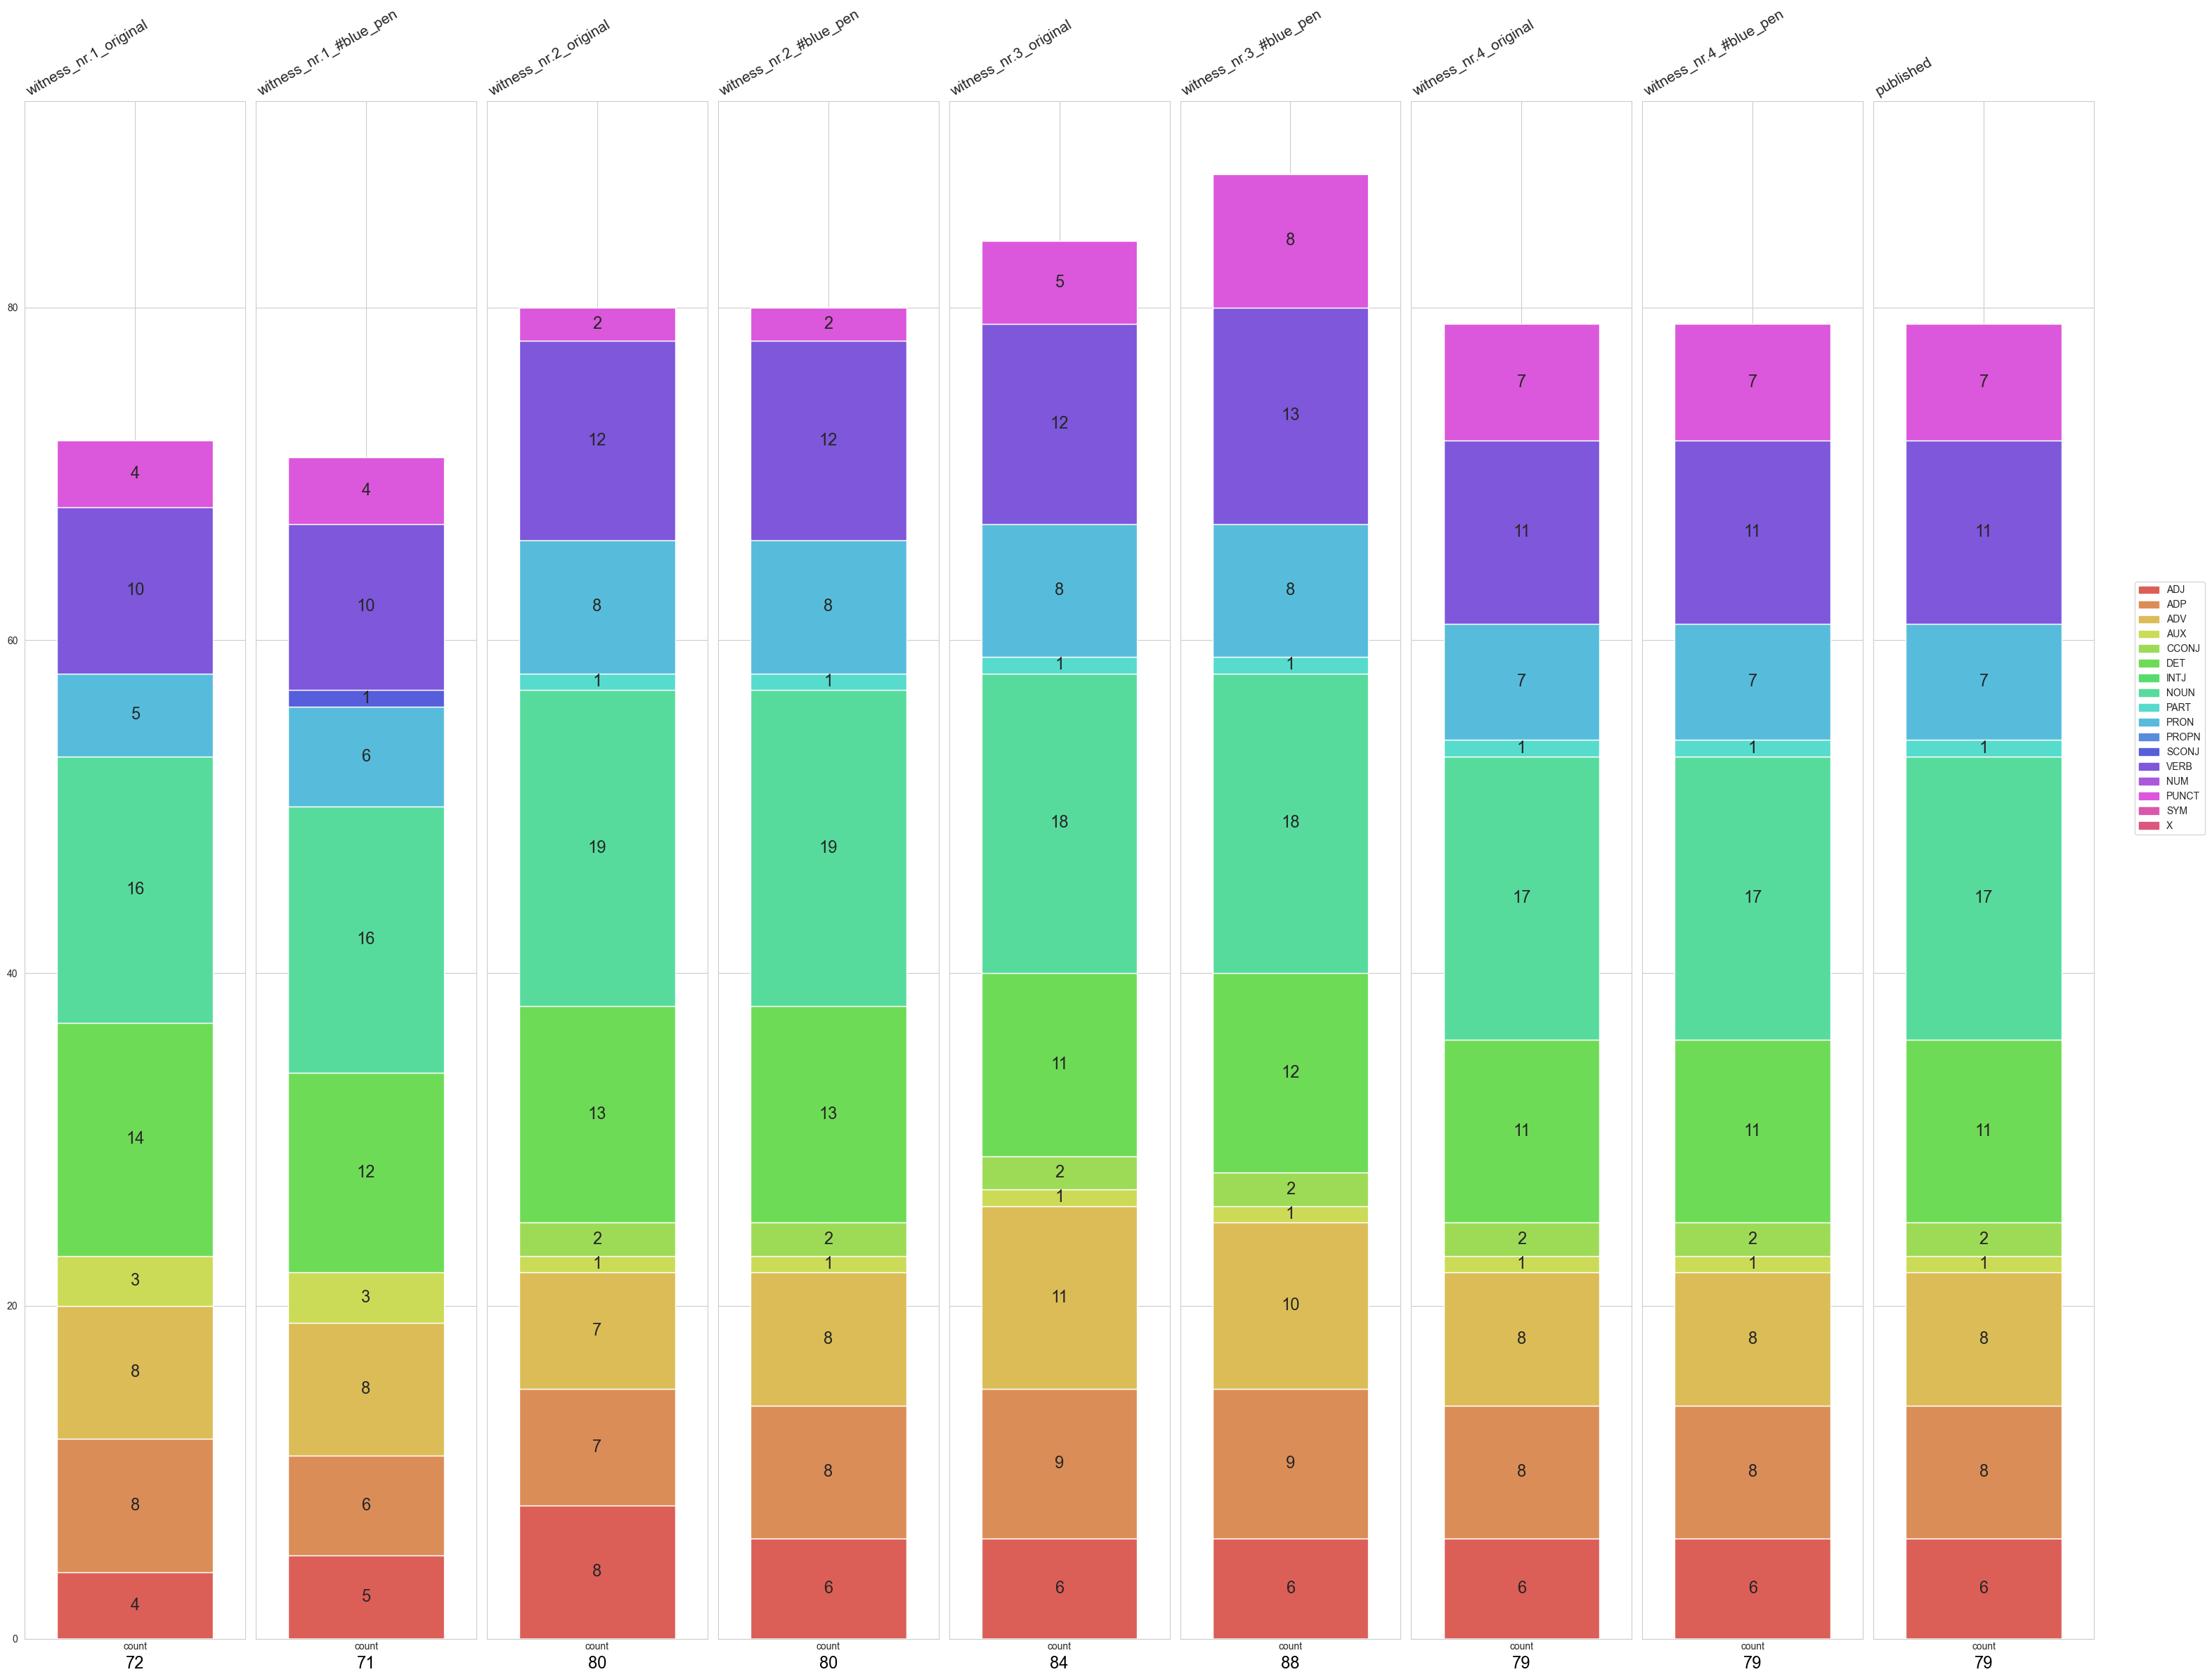

In [14]:
# mit korrekter Reihenfolge: 

# POS-Tags
all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')

# Farbpalette
palette = sns.color_palette("hls", n_colors=len(all_categories))

# Kategorien + Farbpalette
category_color_map = dict(zip(all_categories, palette))

# Kategorien + Labels
label_map = {category: category.split("-")[0] for category in all_categories}

# 1 Plot, 1 Reihe, numdfs Spalten
num_dfs = len(pos_dfs)
fig, axes = plt.subplots(1, num_dfs, figsize=(30, 24), sharey=True)

legend_handles = []
legend_labels = set()

# Threshold
threshold = 0

# Plot stacked bar charts
for idx, df_name in enumerate(desired_order):
    df = pos_dfs[df_name]
    ax = axes[idx] if num_dfs > 1 else axes 
    total = df['count'].sum()
    stacked_df = df.set_index('pos').T

    # fehlende Kategorien auf 0 setzen
    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0 

    stacked_df = stacked_df.reindex(columns=all_categories)
    
    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)

    ax.set_xlabel(total,fontsize=17, rotation=0)
    ax.xaxis.label.set_color('black')
    ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
    ax.tick_params(axis='x', rotation=0, size=0, color='white')

    # Labels für die Kategorien
    for container in ax.containers:
        labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues] 
        ax.bar_label(container, labels=labels, label_type='center', fontsize=17)

    for category in all_categories:
        if category not in legend_labels:  
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category) 

# Legende
fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')

plt.tight_layout()

# Save
plt.savefig(f'{foldername}/VisVergleich_absolut_all_pos_{poem}.png')

# Show
plt.show()



### Visualisierung mit relativen Counts (df in rel_pos_dfs)

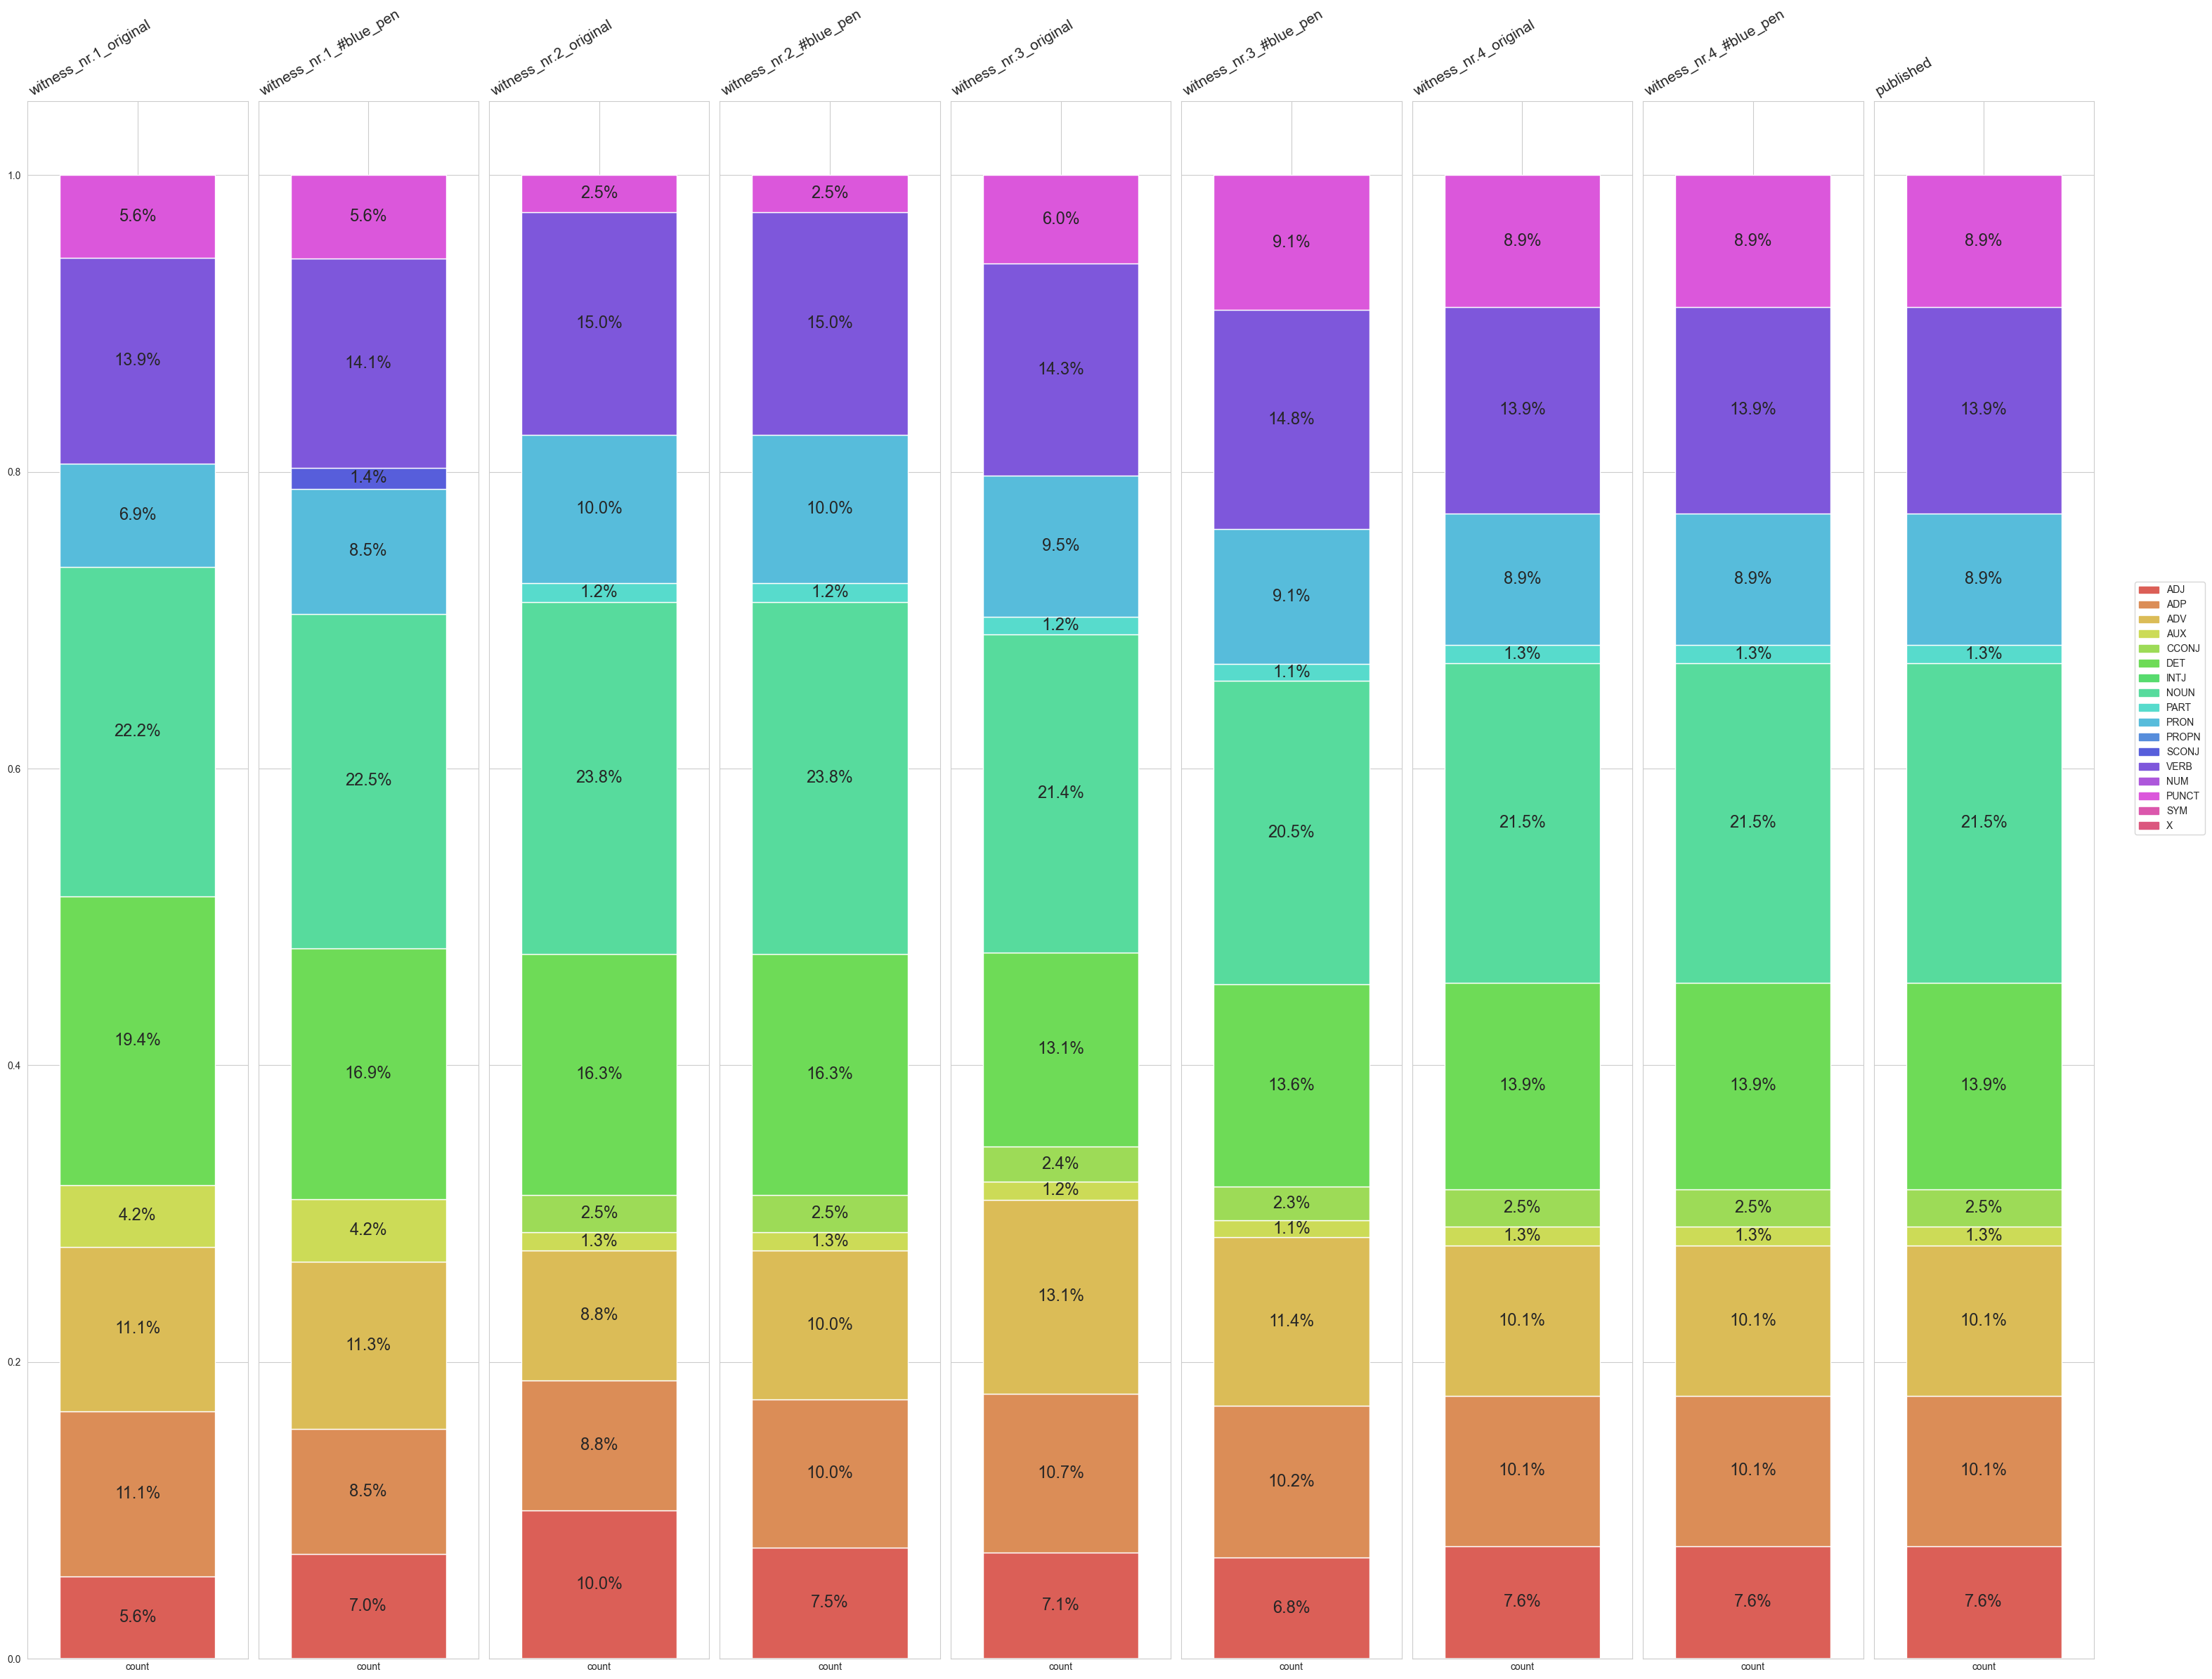

In [15]:
# mit korrekter Reihenfolge: 

# alle Kategorien / POS-Tags
all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')

# Farbpalette mit gleicher Anzahl an Farben wie gefundenen Kategorien/POS
palette = sns.color_palette("hls", n_colors=len(all_categories))

# Dictionary, um Kategorien/POS und Farben zu mappen
category_color_map = dict(zip(all_categories, palette))

# Dictionary, um Kategorien/POS mit Labels zu mappen
label_map = {category: category.split("-")[0] for category in all_categories}

# Plot mit 1 Reihe und so vielen Spalten, wie es dfs gibt
num_dfs = len(rel_pos_dfs)
fig, axes = plt.subplots(1, num_dfs, figsize=(30, 24), sharey=True)

# handles and labels for legend
legend_handles = []
legend_labels = set()

# threshold für Kategorienanzahl pro bar, die angezeigt werden sollen (wenn kategorie == 0, dann scheint sie nicht auf)
threshold = 0

# Plot: für jeden df ein stacked bar 
for idx, df_name in enumerate(desired_order):
    df = rel_pos_dfs[df_name]
    ax = axes[idx] if num_dfs > 1 else axes  
    stacked_df = df.set_index('pos').T

    # alle fehlenden kategorie-values werden auf 0 gestellt 
    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0 

    # Columns ordnen, damit Reihenfolge der Kategorien gleich bleibt
    stacked_df = stacked_df.reindex(columns=all_categories)
    
    # Plot stacked bar chart mit Kategorien nach Farben
    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)

    # Labels
    ax.set_xlabel(f'',fontsize=10, rotation=45)
    ax.xaxis.label.set_color('black')
    ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
    ax.tick_params(axis='x', rotation=0, size=0, color='white')

    # Labels nach Threshold (wenn größer als 0) hinzufügen
    for container in ax.containers:
        labels = [f"{val:.1%}" if val > threshold else "" for val in container.datavalues] 
        ax.bar_label(container, labels=labels, label_type='center', fontsize=17)
    
    # handles für legend hinzufügen
    for category in all_categories:
        if category not in legend_labels:  # keine redundant labels
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category)  

# Legende außerhalb der Subplots
fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')

plt.tight_layout()

# Save VisVergleich_relativ_all_pos_vwdazb
plt.savefig(f'{foldername}/VisVergleich_relativ_all_pos_{poem}.png')

# Show
plt.show()

## Kombination: Tags und ihre enthaltenen Tokens

In [16]:
divs = tree.xpath(f"//t:div[@type='poem' and @xml:id='{poem}']//t:div[@type='witness']", namespaces=ns)
foldername = f"{poem}_Kombination_Eingriffe_Token-POS_csvs" # Foldername mit Poemname bestimmen
#os.makedirs(f"C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{foldername}") # Folder kreiern

#### pro div[@type='witness'] / Textträger: Tags mit ihren Tokens aus dem XML extrahieren und in ein csv-File überführen ("element", "text")

In [17]:

for div in divs: # pro div einen divname kreieren
    divtype = div.attrib.get('type')
    divid = div.attrib.get(f'{xml}id')
    divname = f"{divtype}_{divid}"
    divdict = divname

    alltags = tree.xpath(f"//t:div[@type='{divtype}' and @xml:id='{divid}']//t:l//*", namespaces=ns) # alle Tags
        
    alltags_list = [] # Liste nur für die (Tags/Elemente, Text) Tuples
    alltags_set = set() # Set für die uniquen elemente

    # jedes Element/Tag, das vorkommt, in das set der unique tags geben
    for element in alltags: 
        if isinstance(element, etree._Element): 
            elementname = etree.QName(element).localname
            # die Tags choice, orig und unclear nicht einbeziehen, weil sie keine Eingriffe darstellen
            if elementname not in alltags_set and elementname not in ("choice", "orig", "unclear"): 
                alltags_set.add(elementname)
  #  print(alltags_set)
    
    # pro element, das im set vorhanden ist, eine liste erstellen
    for unique_element in alltags_set: 
        elementlist = unique_element
        elementlist = []
            
        # pro element in allen gefilterten tags, den text herausholen und processen
        for tag_element in alltags: 
            if isinstance(tag_element, etree._Element): 
                tagname = etree.QName(tag_element).localname
                if tagname == unique_element: 
                
                    element_text = tag_element.text 
                    if element_text is not None:
                        element_text = "".join(element_text)
                        element_text = " ".join(element_text.split())
                    else: 
                        element_text = ""
                    # der Text der elementlist hinzufügen        
                    elementlist.append(element_text)

        alltags_list.append((unique_element, " ".join(elementlist))) # elementname, elementlist als tuple zur liste hinzufügen
    
    df = divname
    df = pd.DataFrame(alltags_list, columns=['element', 'token_/pos']) # aus der liste ein df machen
    print(df.head())
    df.to_csv(f'{foldername}/Eingriffe_Token-POS_extrahiert_{divname}_df.csv', index=False)
        
 #   print(df)



  element                                         token_/pos
0     add  als_/SCONJ ich_/PRON zurückkam_/VERB kreuzten_...
1     del  schwanken_/VERB lauten_/ADJ über_/ADP den_/DET...
2     reg  knirschend_/ADV Dachtraufen_/NOUN dräuten_/ADV...
  element                                         token_/pos
0     del  ein_/DET wenig_/PRON zurückgekehrt_/VERB in_/A...
1     add  etwas_/ADV über_/ADP ich_/PRON wanderte_/VERB ...
2     reg  lauthals_/ADV und_/CCONJ lässig_/ADV wie_/ADP ...
  element                                         token_/pos
0     add  über_/ADP das_/DET ,_/PUNCT :_/PUNCT schwankt_...
1     del           durchs_/ADP schwankend_/ADV riesige_/ADJ
2     reg                                 Kirchenplatz_/NOUN
  element       token_/pos
0     del    bedrückt_/ADV
1     add  verdrossen_/ADV


#### Die csv-files weiterverarbeiten: in jeder Reihe row['token_/pos'] mit Text die Tokens von den POS-Tags trennen, in ein separates CSV-File überführen und die absoluten und relativen Häufigkeiten der POS-Tags als eigene CSV-Files speichern.

In [18]:

directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Kombination_Eingriffe_Token-POS_csvs'

# Filter CSV files based on filename pattern
csv_files = [filename for filename in os.listdir(directory) if filename.startswith('Eingriffe_Token-POS_extrahiert') and filename.endswith('.csv')]

abs_pos_dfs = {} # dictionary, um alle dfs zu speichern
rel_pos_dfs = {} # dictionary, um alle dfs mit relativen counts zu speichern

for csv_file in csv_files:
    # Name aus dem Dateiname rausnehmen nach "revision" aber vor "df.csv"
    df_name = csv_file.split('Eingriffe_Token-POS_extrahiert_')[-1].split('_df.csv')[0]
     # dann jede csv-Datei als Dataframe laden
    df = pd.read_csv(os.path.join(directory, csv_file))
  #  print(df.head())

    for index, row in df.iterrows():
   #     print(df['token_/pos'])
        split_token_pos = re.findall(r'([^\s_]+)_/(\b\w+)', row['token_/pos']) # TOKEN_/POS-Name werden gesucht und gesplitet an dem "_/"-Ort
       # print(split_token_pos)
        interfer_type = row['element']
        new_df_name = f"{interfer_type}_{df_name}"
        print(new_df_name)
        new_df = new_df_name
        new_df = pd.DataFrame(split_token_pos, columns=['token', 'pos'])
        new_df.to_csv(f'{foldername}/{new_df_name}_Token-POS_gesplittet_df.csv', index=False)
        print(new_df.head())

         # für absolute counts:
        abs_df = new_df["pos"].value_counts().reset_index() # die Vorkommnisse von POS zählen mit .value_counts()
        abs_df.columns = ['pos', 'count'] # im df die neuen Spalten "pos" und "count" definieren
       # abs_df.sort_values(by='pos', ascending=True)
        abs_pos_dfs[new_df_name] = abs_df #df zum dictionary hinzufügen
        abs_df.to_csv(f'{foldername}/abs_counts_{interfer_type}_POS_{df_name}_df.csv', index=False)
        print(abs_df.head())
        
        # für relative counts:
        rel_df = abs_df.copy()
        total_count = abs_df['count'].sum()
        rel_df['count'] = rel_df['count'] / total_count
      #  rel_df.sort_values(by='pos', ascending=True)
        rel_pos_dfs[new_df_name] = rel_df #df zum dictionary hinzufügen mit relativen counts
        rel_df.to_csv(f'{foldername}/rel_counts_{interfer_type}_POS_{df_name}_df.csv', index=False)
        print(rel_df.head())



add_witness_nr.1
          token    pos
0           als  SCONJ
1           ich   PRON
2     zurückkam   VERB
3      kreuzten   VERB
4  ausgestattet   VERB
     pos  count
0   VERB      3
1    ADJ      2
2   NOUN      2
3  SCONJ      1
4   PRON      1
     pos  count
0   VERB    0.3
1    ADJ    0.2
2   NOUN    0.2
3  SCONJ    0.1
4   PRON    0.1
del_witness_nr.1
       token   pos
0  schwanken  VERB
1     lauten   ADJ
2       über   ADP
3        den   DET
4     Schnee  NOUN
    pos  count
0   DET      3
1  VERB      2
2   ADP      2
3  NOUN      2
4   ADJ      1
    pos     count
0   DET  0.272727
1  VERB  0.181818
2   ADP  0.181818
3  NOUN  0.181818
4   ADJ  0.090909
reg_witness_nr.1
         token   pos
0   knirschend   ADV
1  Dachtraufen  NOUN
2      dräuten   ADV
3      riesige   ADJ
    pos  count
0   ADV      2
1  NOUN      1
2   ADJ      1
    pos  count
0   ADV   0.50
1  NOUN   0.25
2   ADJ   0.25
del_witness_nr.2
           token   pos
0            ein   DET
1          wenig  P

### Visualisierungen

alle POS & Textstufen in einem Plot / absolute Counts:

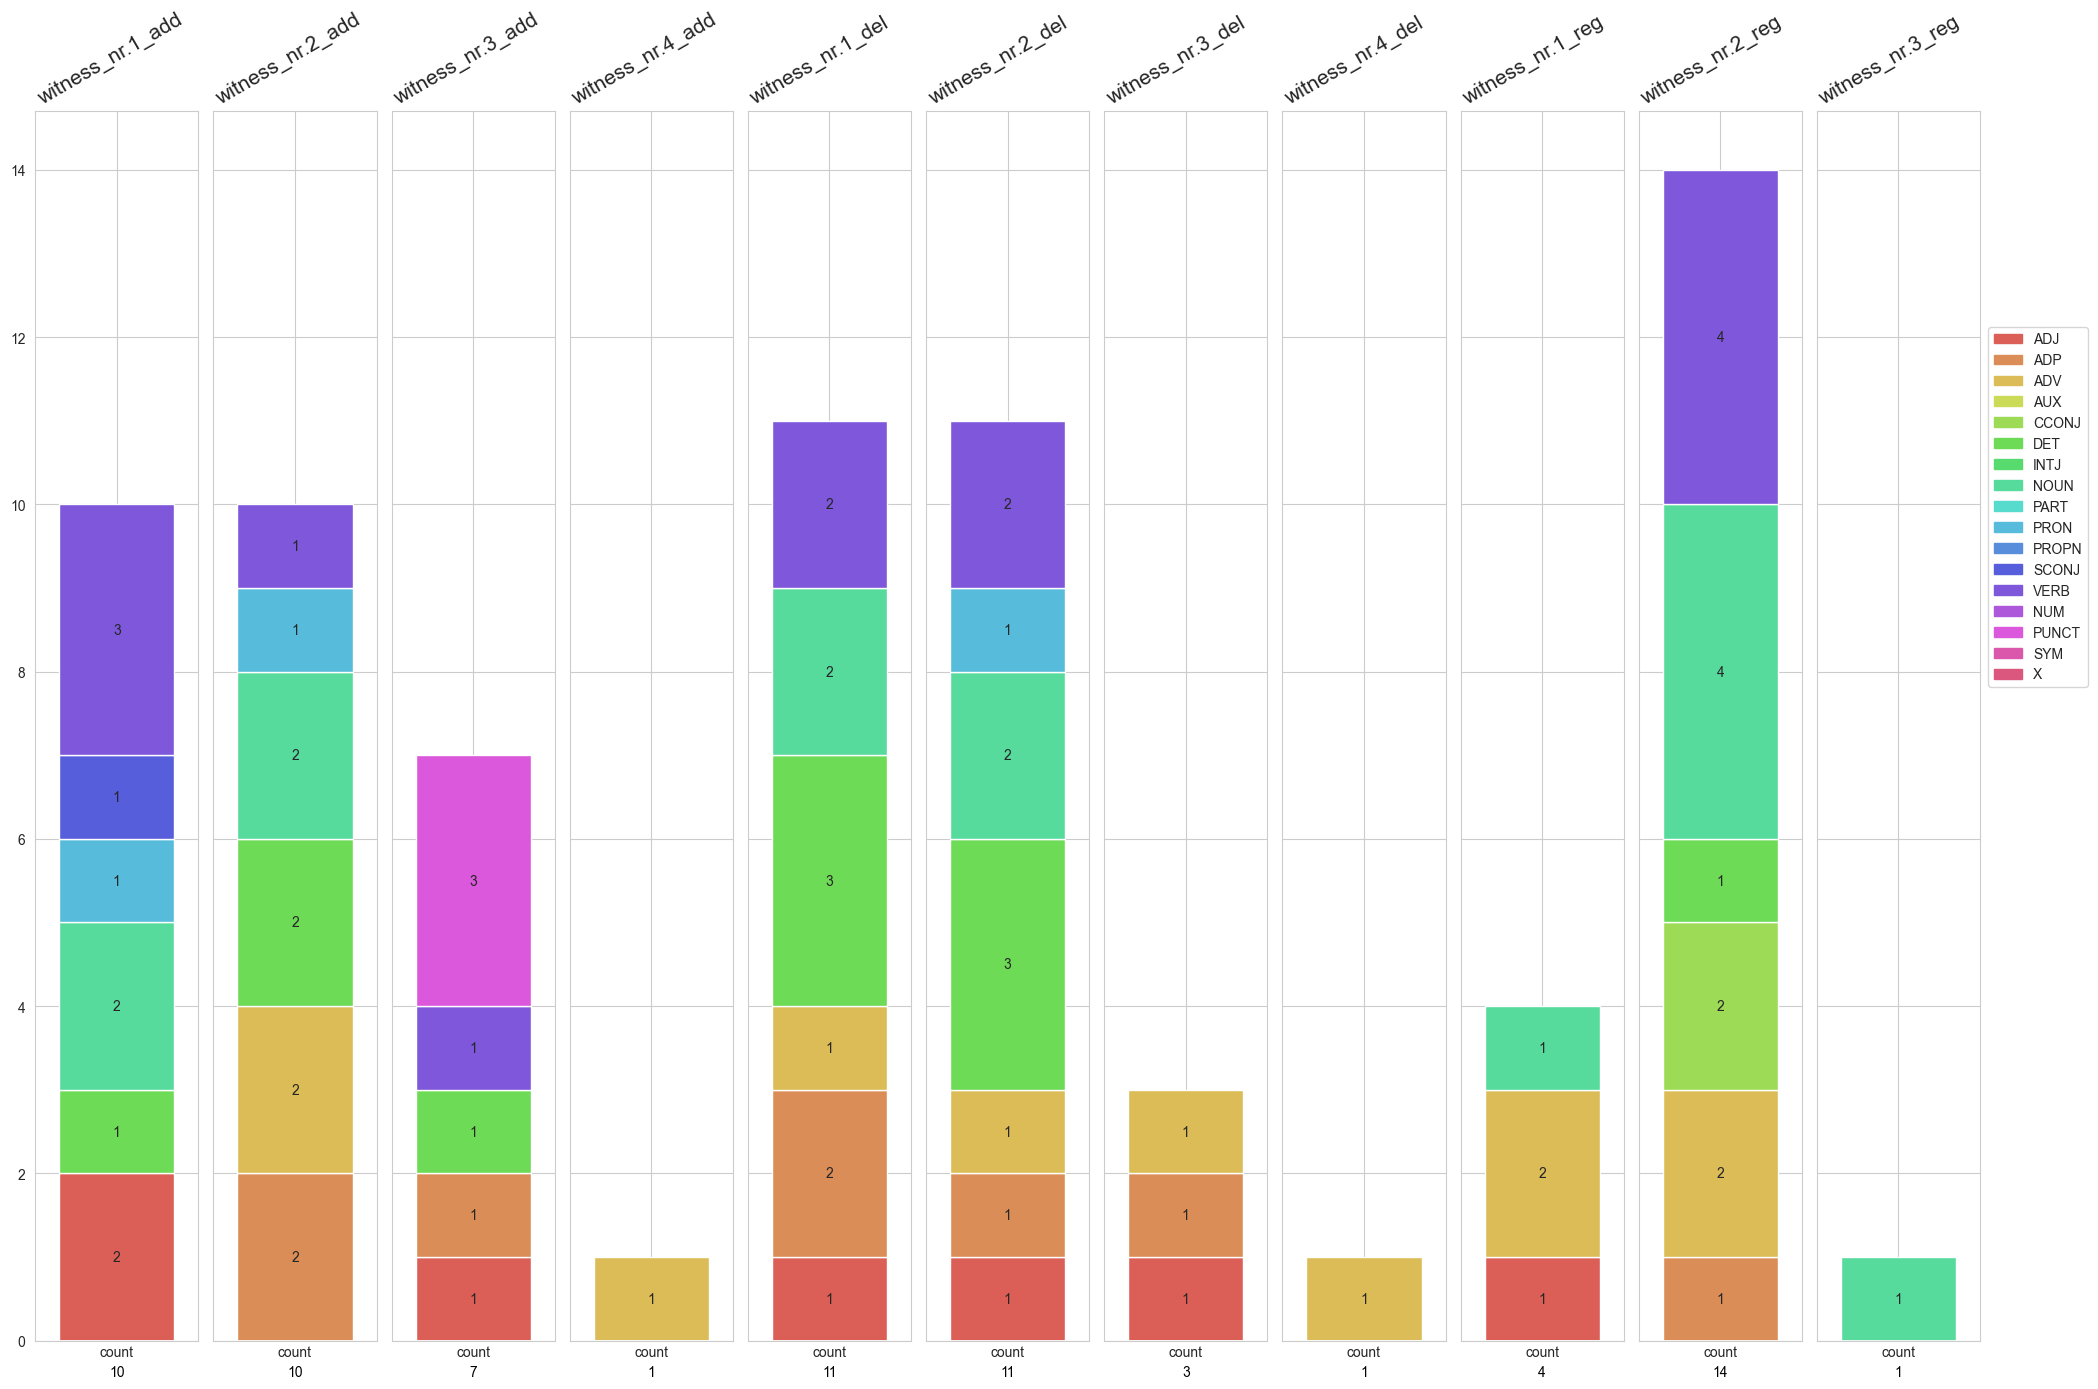

In [19]:
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Kombination_Eingriffe_Token-POS_csvs'

# Filtern
csv_files = [filename for filename in os.listdir(directory) if filename.startswith('abs_counts_') and filename.endswith('.csv')]
dfs = {}

for csv_file in csv_files:
    # Name aus dem Dateiname rausnehmen 
    witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
        
    interfer_type = csv_file.split('abs_counts_')[-1].split('_POS_')[0]

    df = pd.read_csv(os.path.join(directory, csv_file))
    df_name = f"{witness}_{interfer_type}"
    dfs[df_name] = df

#visualisation
# Kategorien
all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')

#Palette
palette = sns.color_palette("hls", n_colors=len(all_categories))

# Kategorien + Palette
category_color_map = dict(zip(all_categories, palette))

# Kategorien = Labels
label_map = {category: category.split("-")[0] for category in all_categories}

# 1 Plot, 1 Reihe, num_dfs Spalten
num_dfs = len(dfs)
fig, axes = plt.subplots(1, num_dfs, figsize=(20, 14), sharey=True)


legend_handles = []
legend_labels = set()

# Threshold 
threshold = 0

# Stacked bar charts
for idx, (df_name, df) in enumerate(dfs.items()):
    ax = axes[idx] if num_dfs > 1 else axes  
    total = df['count'].sum()
    stacked_df = df.set_index('pos').T

    # fehlende values = 0
    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0  

    # Reordern 
    stacked_df = stacked_df.reindex(columns=all_categories)
    
    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)

    ax.set_xlabel(total, fontsize=10, rotation=0)
    ax.xaxis.label.set_color('black')
    ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
    ax.tick_params(axis='x', rotation=0, size=0, color='white')

    # Labels
    for container in ax.containers:
        labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues] 
        ax.bar_label(container, labels=labels, label_type='center')
    
    for category in all_categories:
        if category not in legend_labels: 
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category) 

# Legende
fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')

plt.tight_layout()

plt.savefig(f'{foldername}/VisVergleich_absolut_alle_Eingriffe_pos_{poem}.png')

plt.show() 
        

alle POS und Textstufen / relative Counts

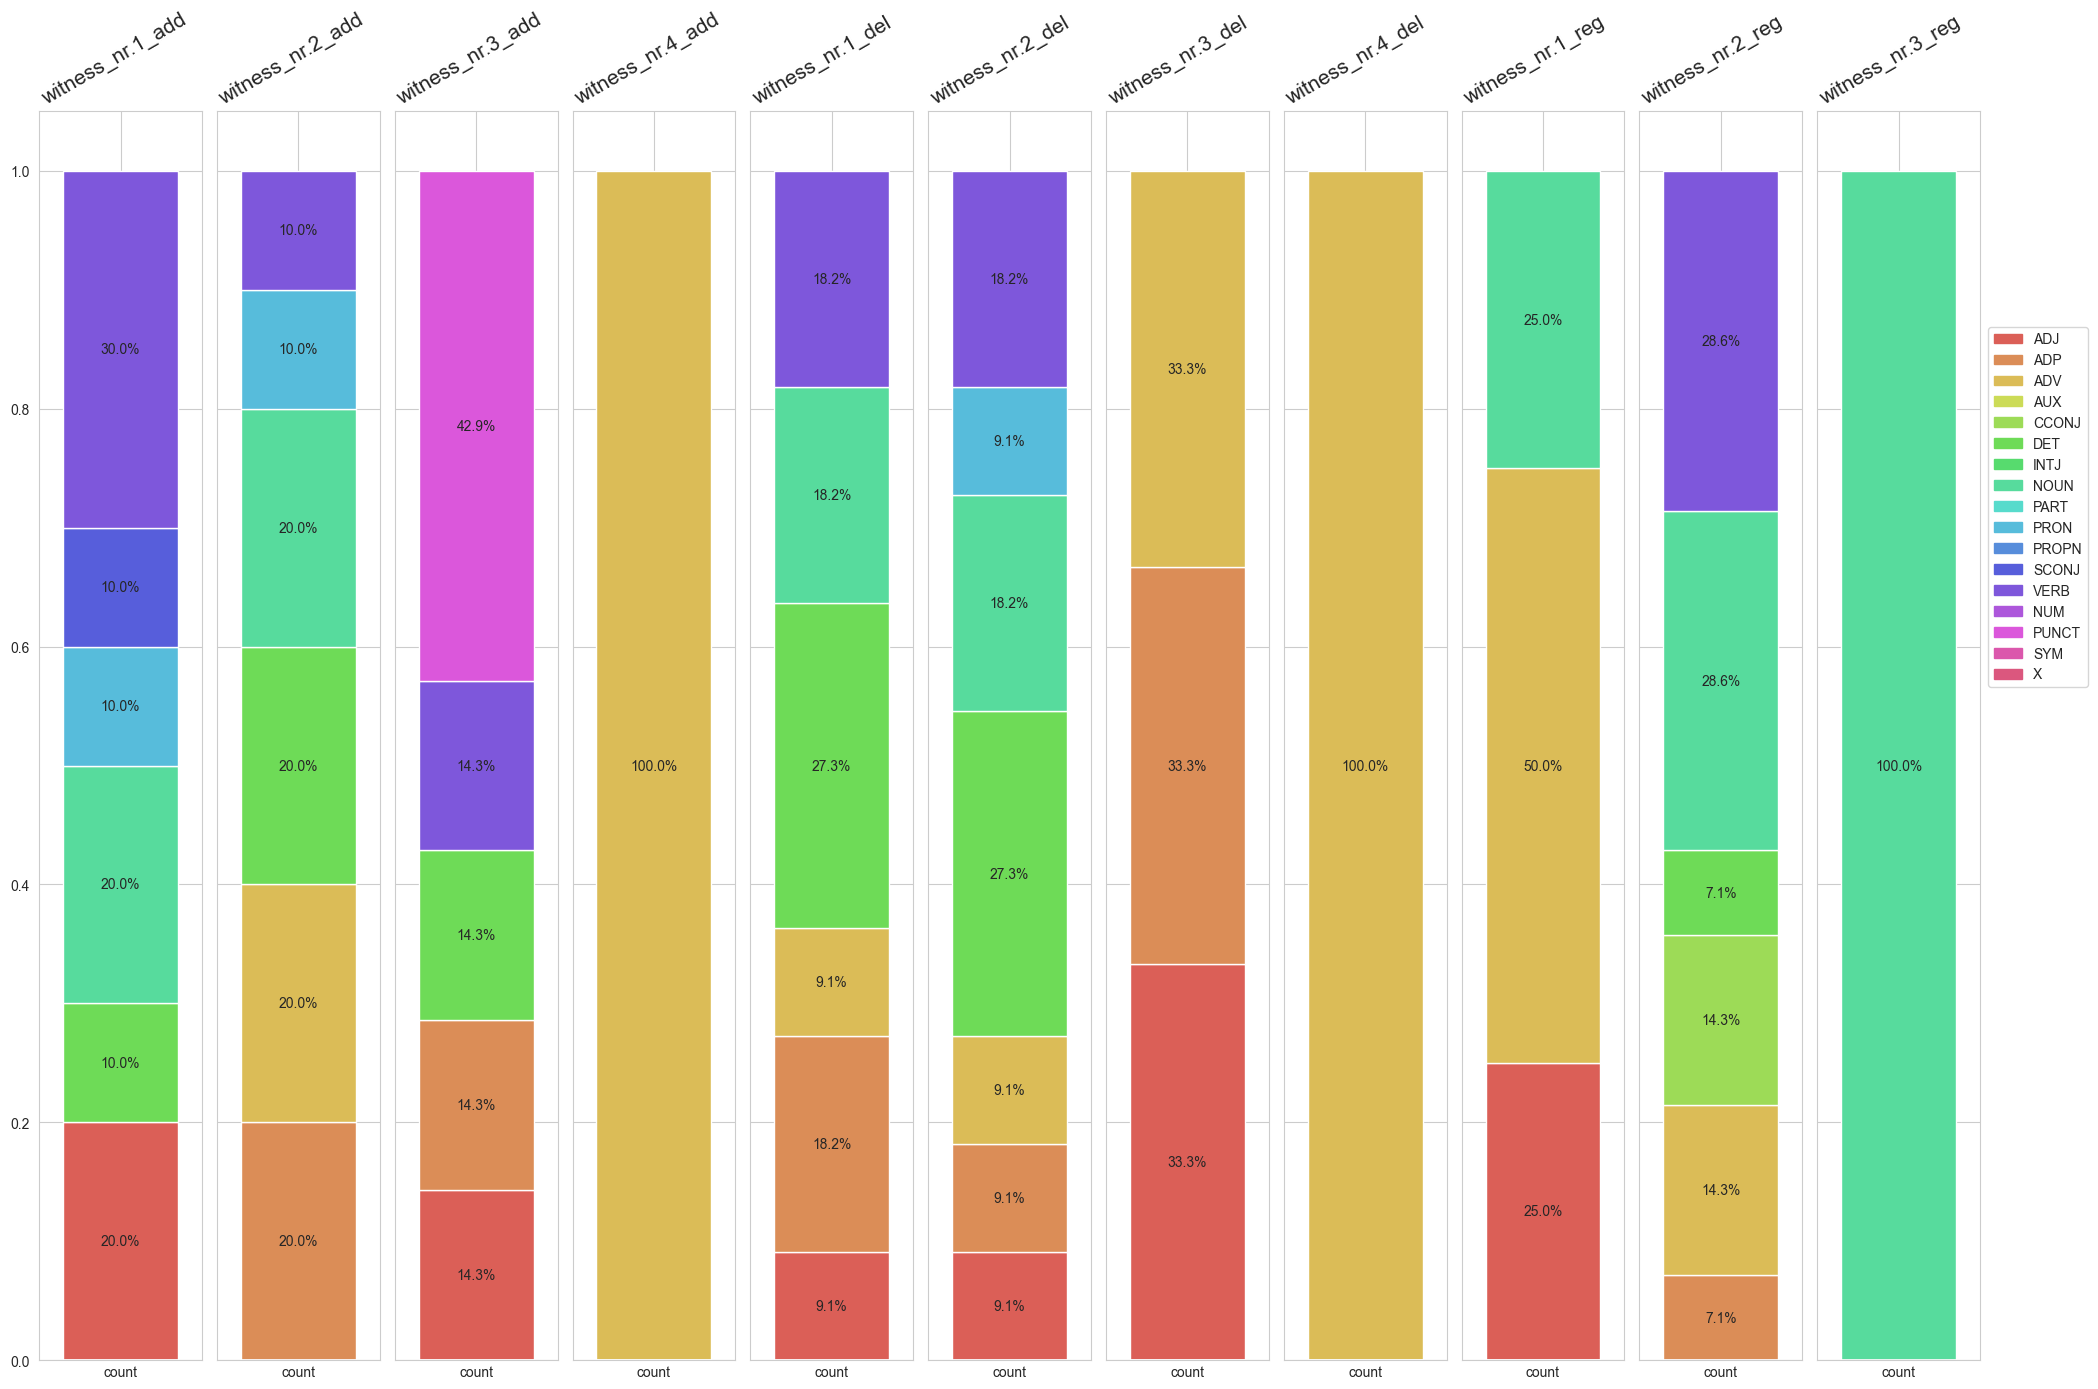

In [20]:
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Kombination_Eingriffe_Token-POS_csvs'

# Filtern
csv_files = [filename for filename in os.listdir(directory) if filename.startswith('rel_counts_') and filename.endswith('.csv')]
dfs = {}

for csv_file in csv_files:
    # Name aus dem Dateiname rausnehmen 
    witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
        
    interfer_type = csv_file.split('rel_counts_')[-1].split('_POS_')[0]

    df = pd.read_csv(os.path.join(directory, csv_file))
    df_name = f"{witness}_{interfer_type}"
    dfs[df_name] = df

#visualisation
all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')

palette = sns.color_palette("hls", n_colors=len(all_categories))

category_color_map = dict(zip(all_categories, palette))

label_map = {category: category.split("-")[0] for category in all_categories}

num_dfs = len(dfs)
fig, axes = plt.subplots(1, num_dfs, figsize=(20, 14), sharey=True)

legend_handles = []
legend_labels = set()

threshold = 0

# Stacked bar charts
for idx, (df_name, df) in enumerate(dfs.items()):
    ax = axes[idx] if num_dfs > 1 else axes  
    stacked_df = df.set_index('pos').T

    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0  
    stacked_df = stacked_df.reindex(columns=all_categories)
    
    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)

    ax.set_xlabel(f'',fontsize=10, rotation=45)
    ax.xaxis.label.set_color('black')
    ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
    ax.tick_params(axis='x', rotation=0, size=0, color='white')

    for container in ax.containers:
        labels = [f"{val:.1%}" if val > threshold else "" for val in container.datavalues] 
        ax.bar_label(container, labels=labels, label_type='center')

    for category in all_categories:
        if category not in legend_labels: 
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category)  

fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')

plt.tight_layout()

plt.savefig(f'{foldername}/VisVergleich_relativ_alle_Eingriffe_pos_{poem}.png')

plt.show()

#### nach Textzeuge visualisiert & sortiert / absolute Counts:

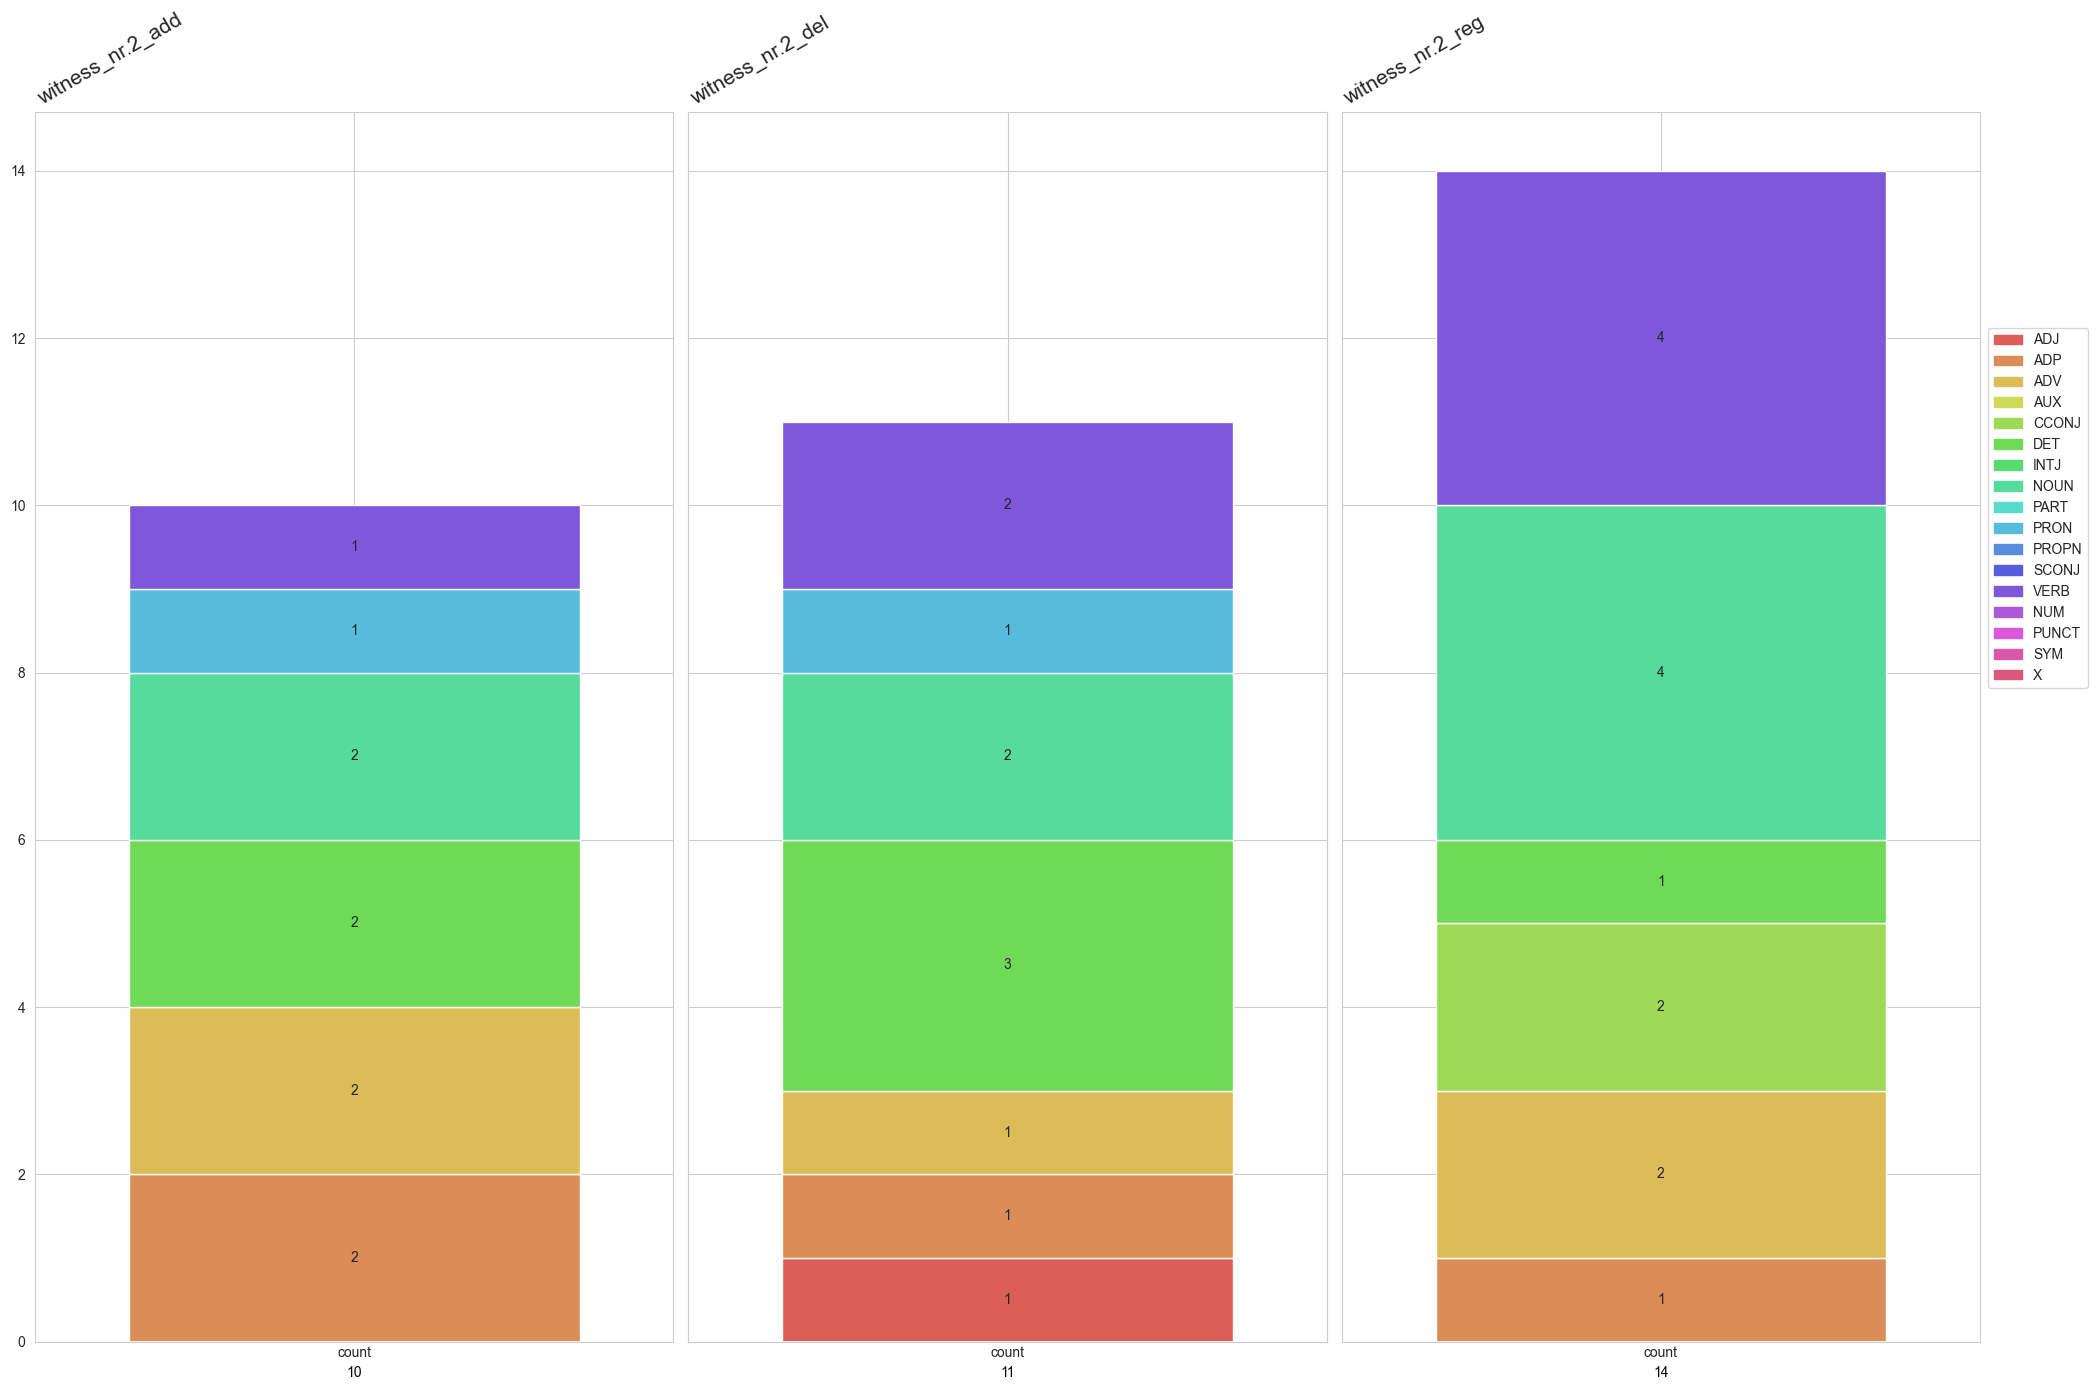

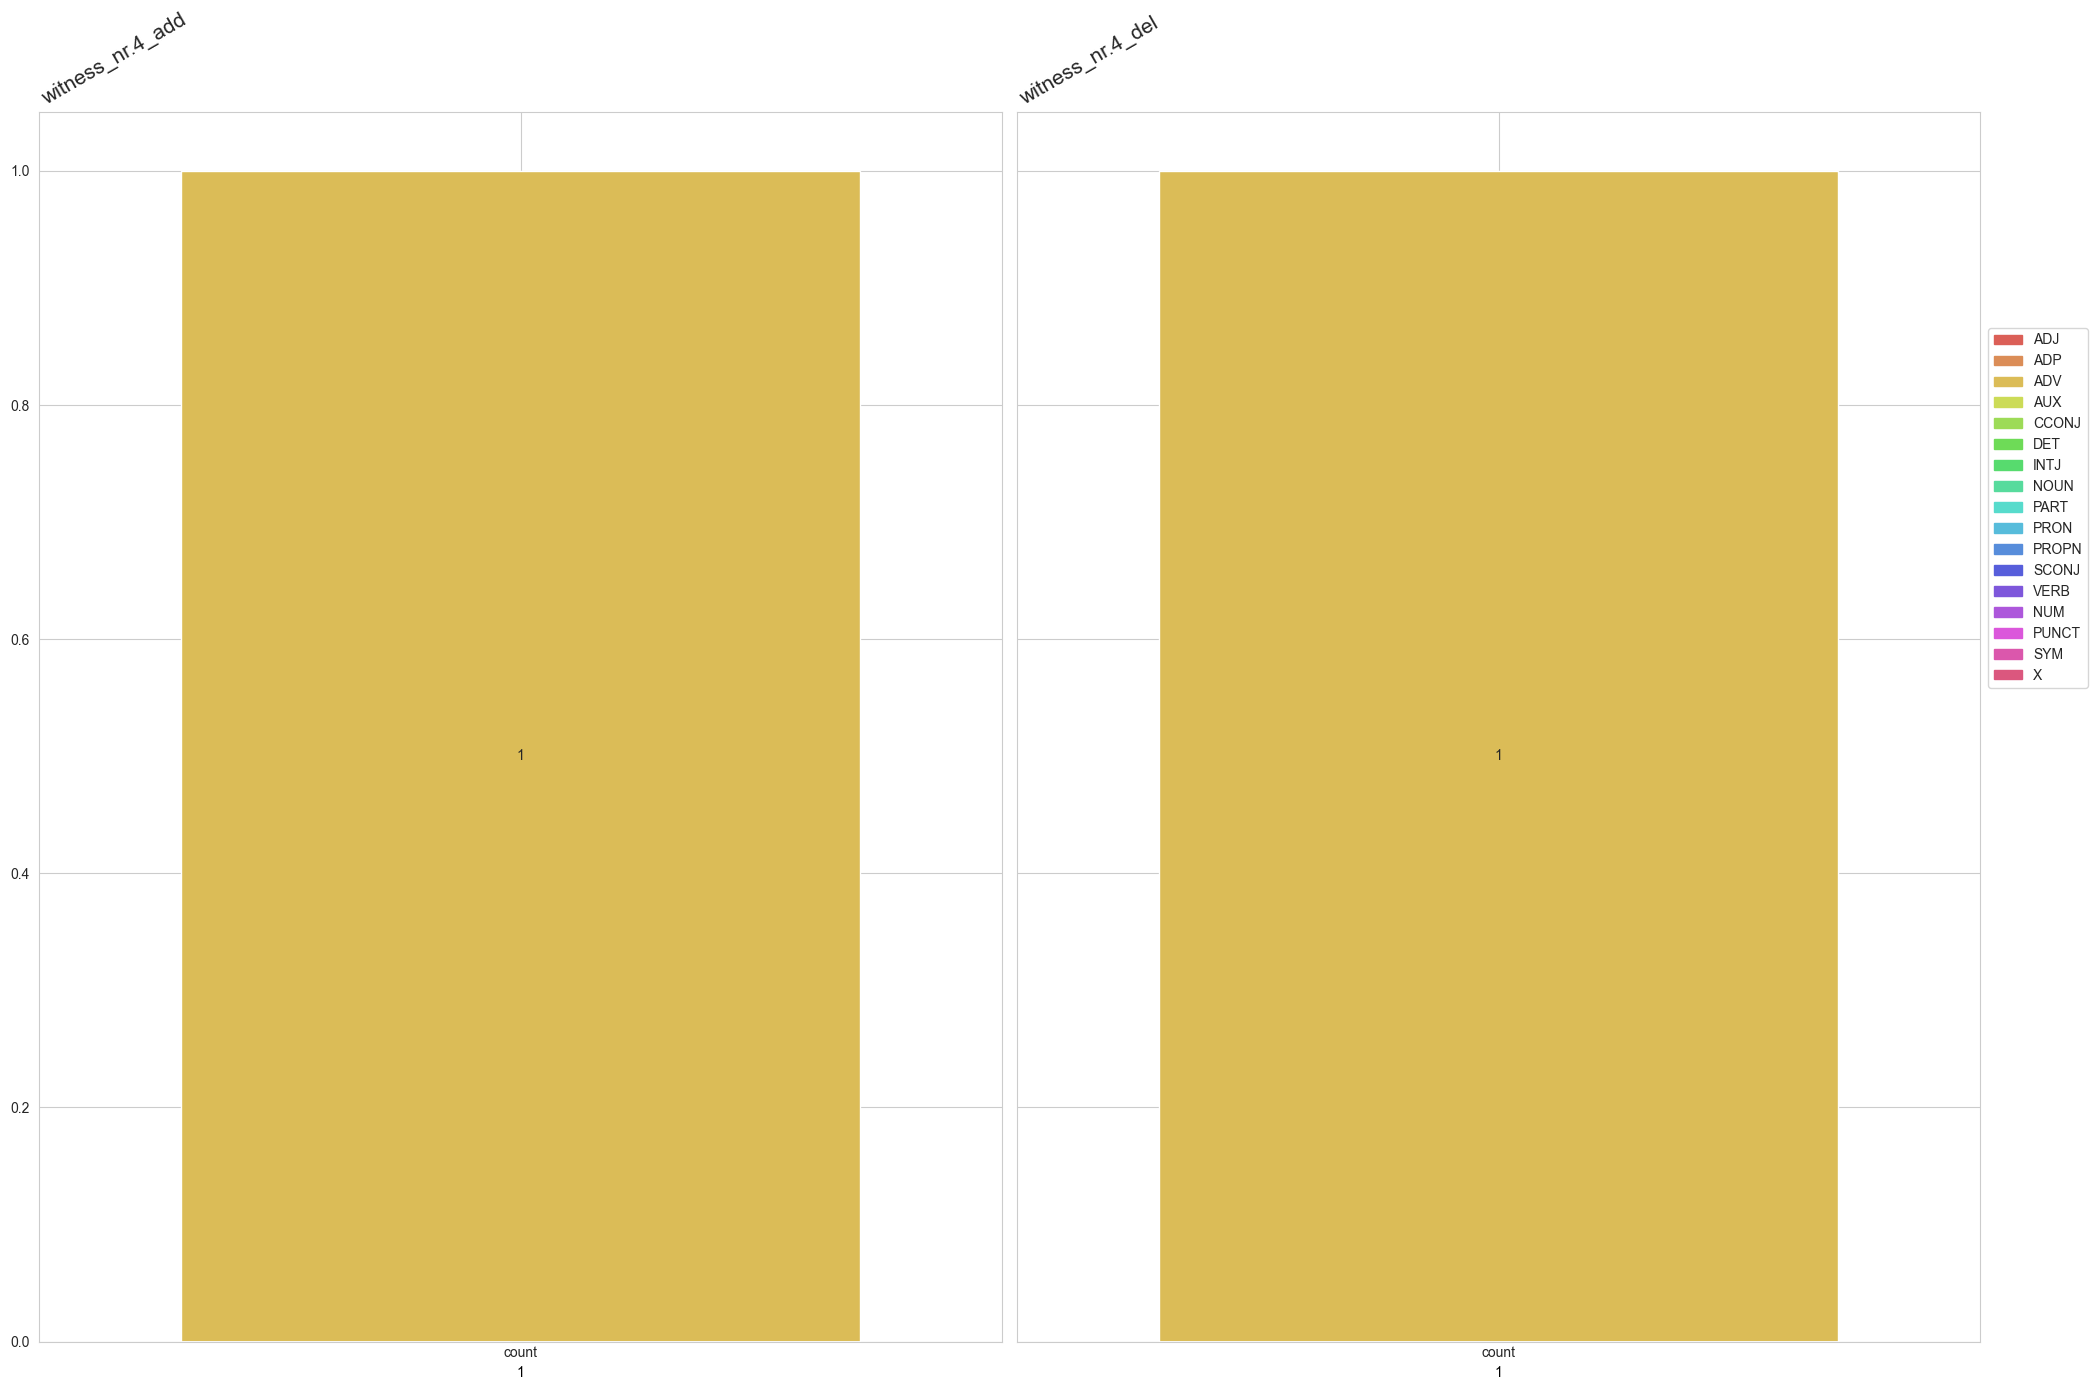

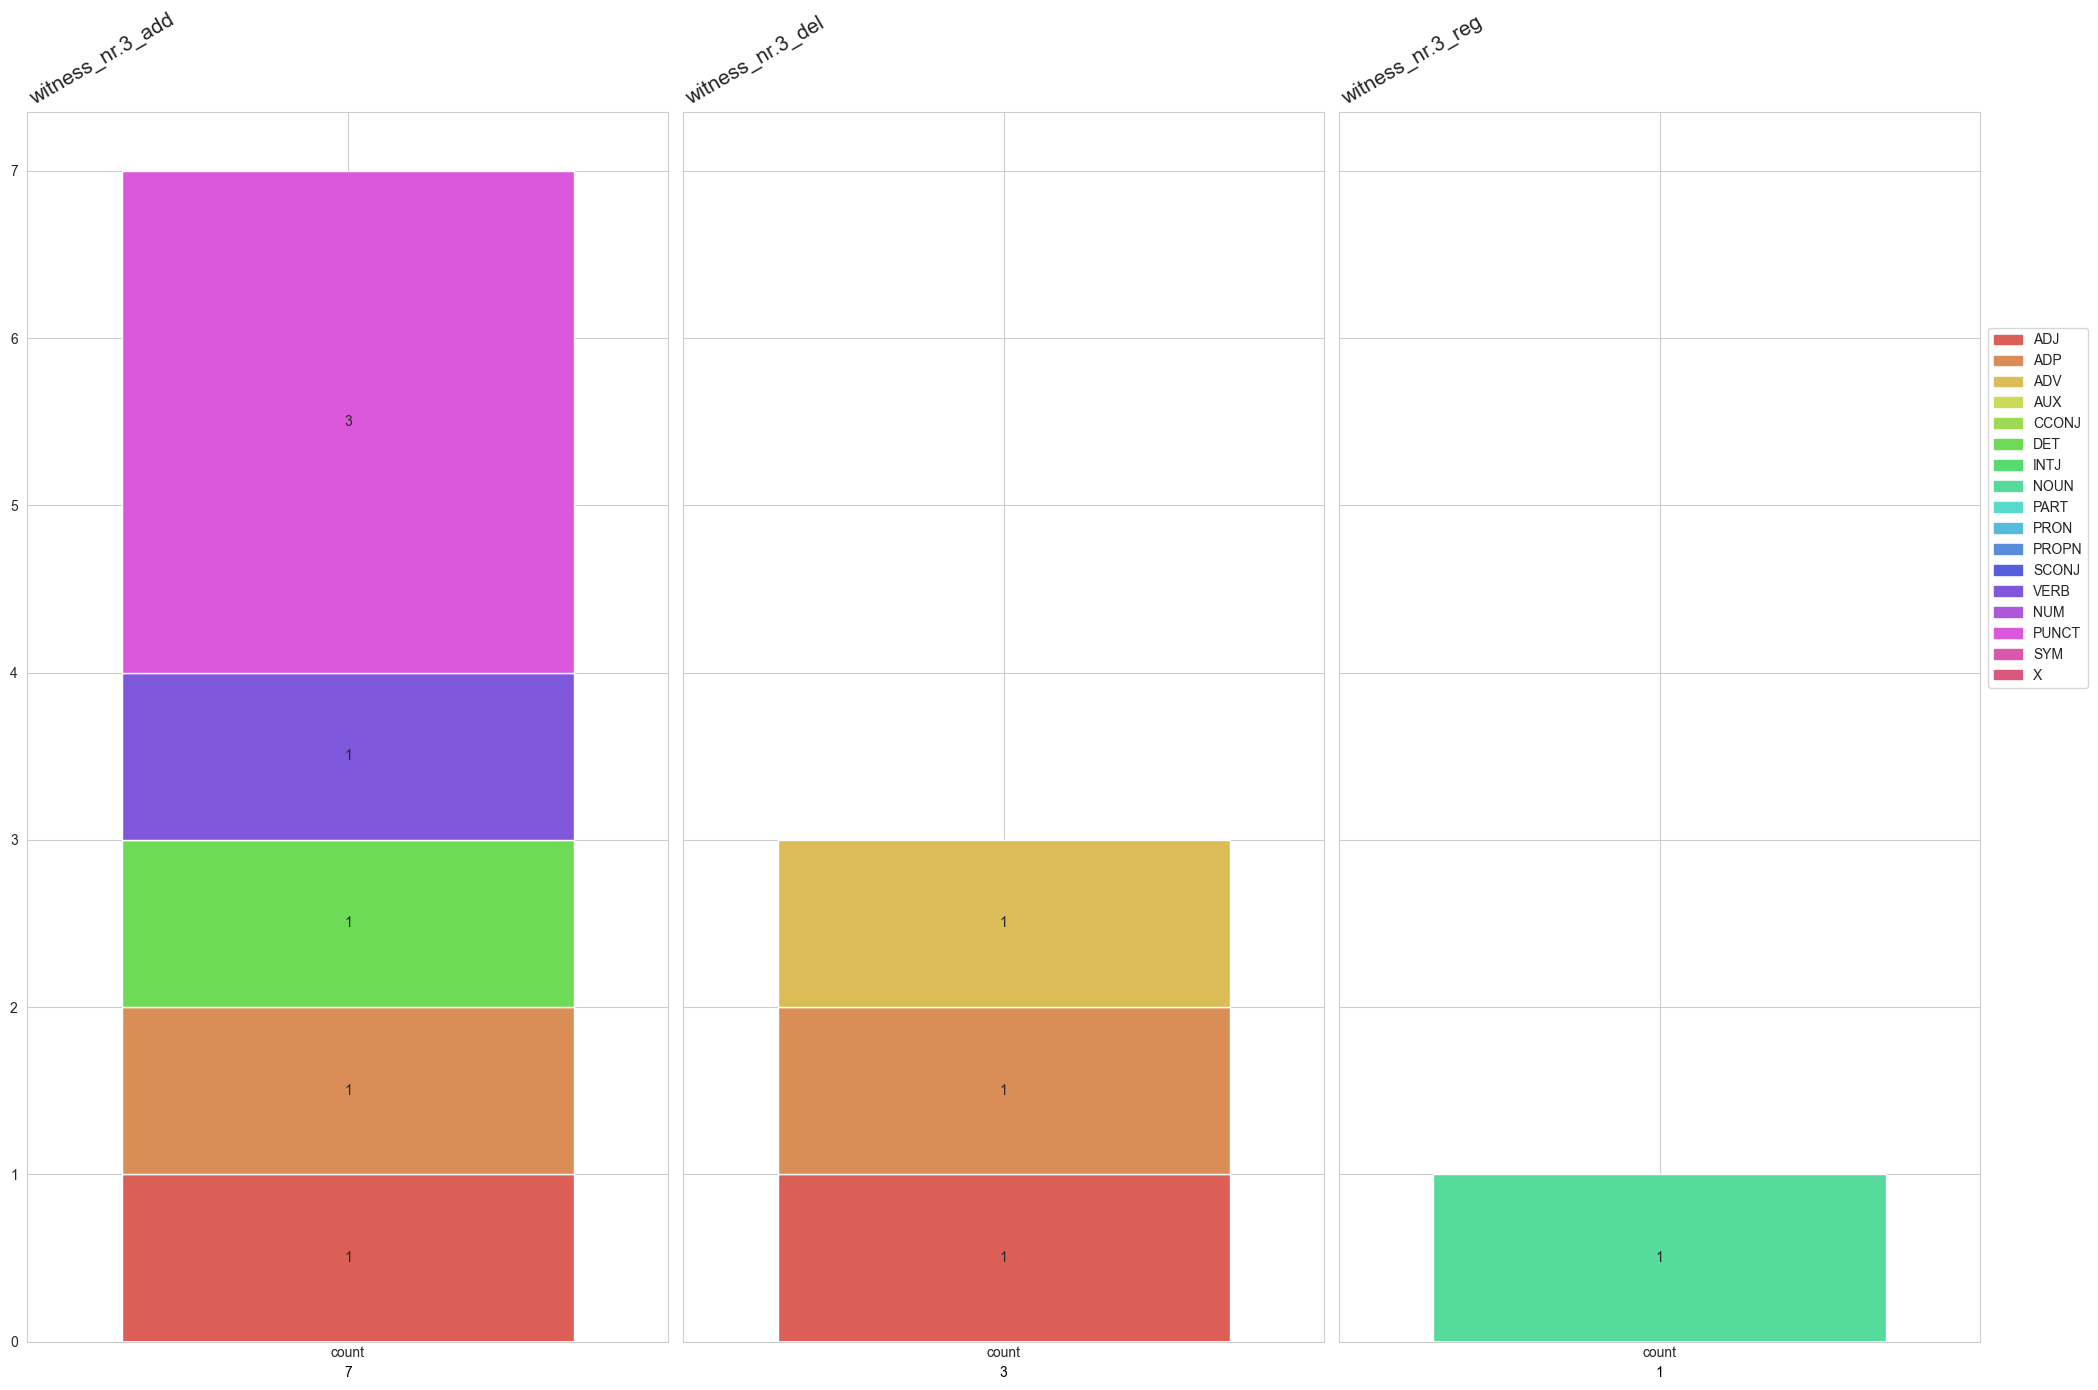

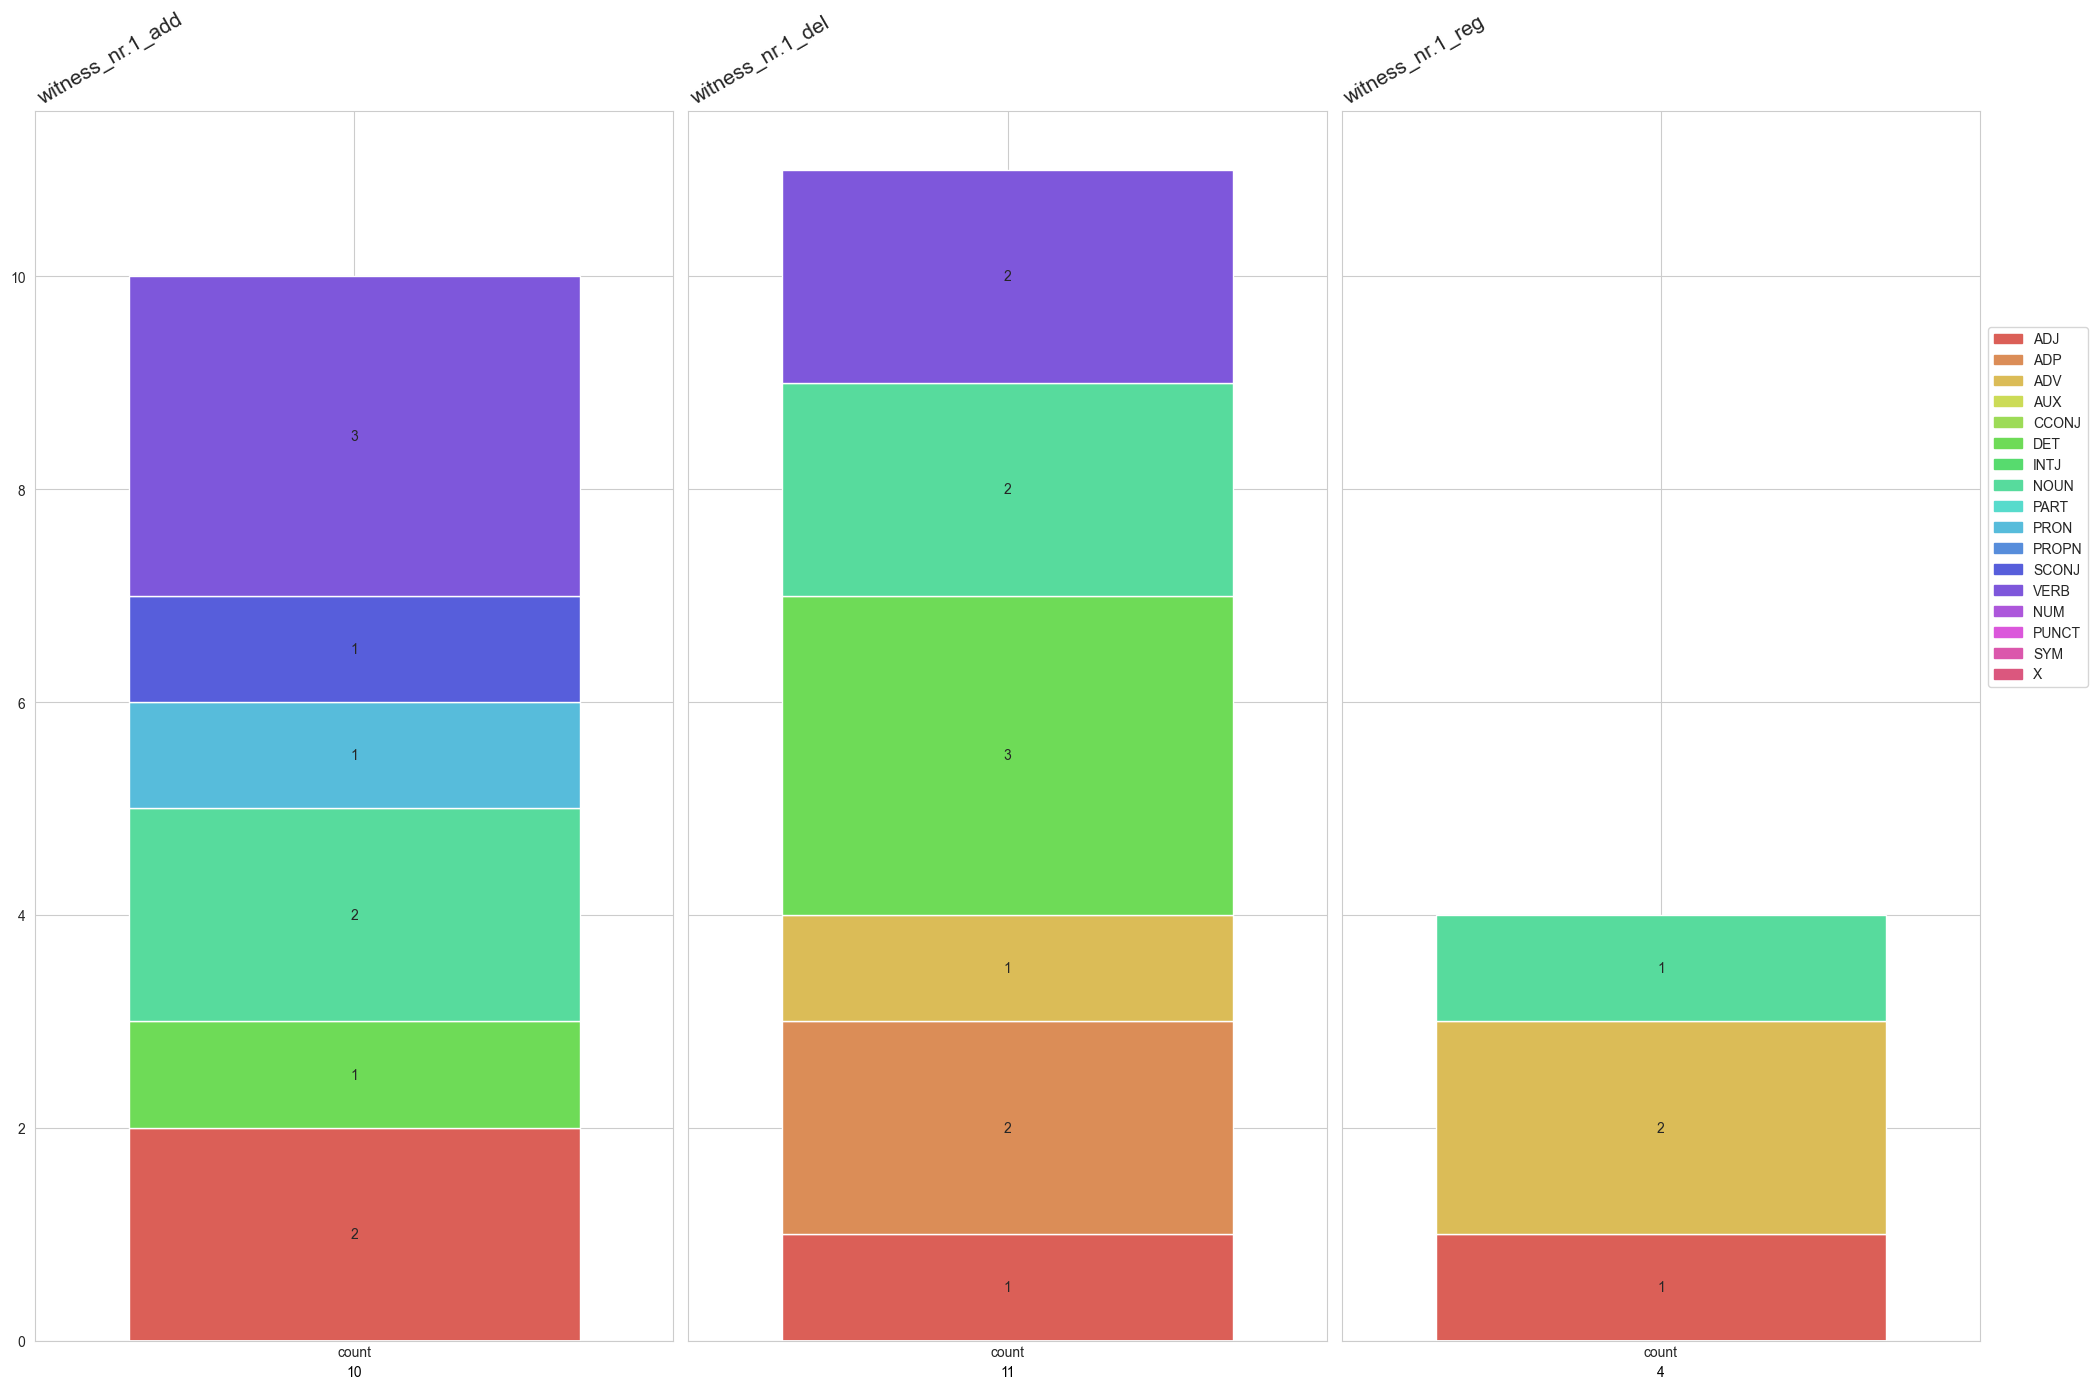

In [21]:
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Kombination_Eingriffe_Token-POS_csvs'

csv_files = [filename for filename in os.listdir(directory) if filename.startswith('abs_counts_') and filename.endswith('.csv')]
witnesses = set()

for csv_file in csv_files:
    witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
    if witness not in witnesses: 
        witnesses.add(witness)
        
    interfer_type = csv_file.split('abs_counts_')[-1].split('_POS_')[0]


for witness in witnesses: 
    abs_dfs = {}
    for csv_file in csv_files: 
        if witness in csv_file.split('_POS_')[-1].split('_df.csv')[0]: 
     # dann jede csv-Datei als Dataframe laden
            df = pd.read_csv(os.path.join(directory, csv_file))
            interfer_type = csv_file.split('abs_counts_')[-1].split('_POS_')[0]
            df_name = f"{witness}_{interfer_type}"
            abs_dfs[df_name] = df

    # categories
    all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')
    

    palette = sns.color_palette("hls", n_colors=len(all_categories))

    category_color_map = dict(zip(all_categories, palette))

    label_map = {category: category.split("-")[0] for category in all_categories}

    num_dfs = len(abs_dfs)
    fig, axes = plt.subplots(1, num_dfs, figsize=(20, 14), sharey=True)

    legend_handles = []
    legend_labels = set() 

    threshold = 0
    
    for idx, (df_name, df) in enumerate(abs_dfs.items()):
        ax = axes[idx] if num_dfs > 1 else axes  
        totals = df['count'].sum()
        stacked_df = df.set_index('pos').T
    
        for category in all_categories:
            if category not in stacked_df.columns:
                stacked_df[category] = 0  
                
        stacked_df = stacked_df.reindex(columns=all_categories)

        stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)
    
        ax.set_xlabel(totals,fontsize=10, rotation=0)
        ax.xaxis.label.set_color('black')
        ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
        ax.tick_params(axis='x', rotation=0, size=0, color='white')

        for container in ax.containers:
            labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues]  
            ax.bar_label(container, labels=labels, label_type='center')

        for category in all_categories:
            if category not in legend_labels:  
                legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
                legend_labels.add(category) 

    fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')

    plt.tight_layout()

    plt.savefig(f'{foldername}/VisVergleich_absolut_{witness}_Eingriffe_pos_{poem}.png')

    plt.show()
        
        

#### relative Counts

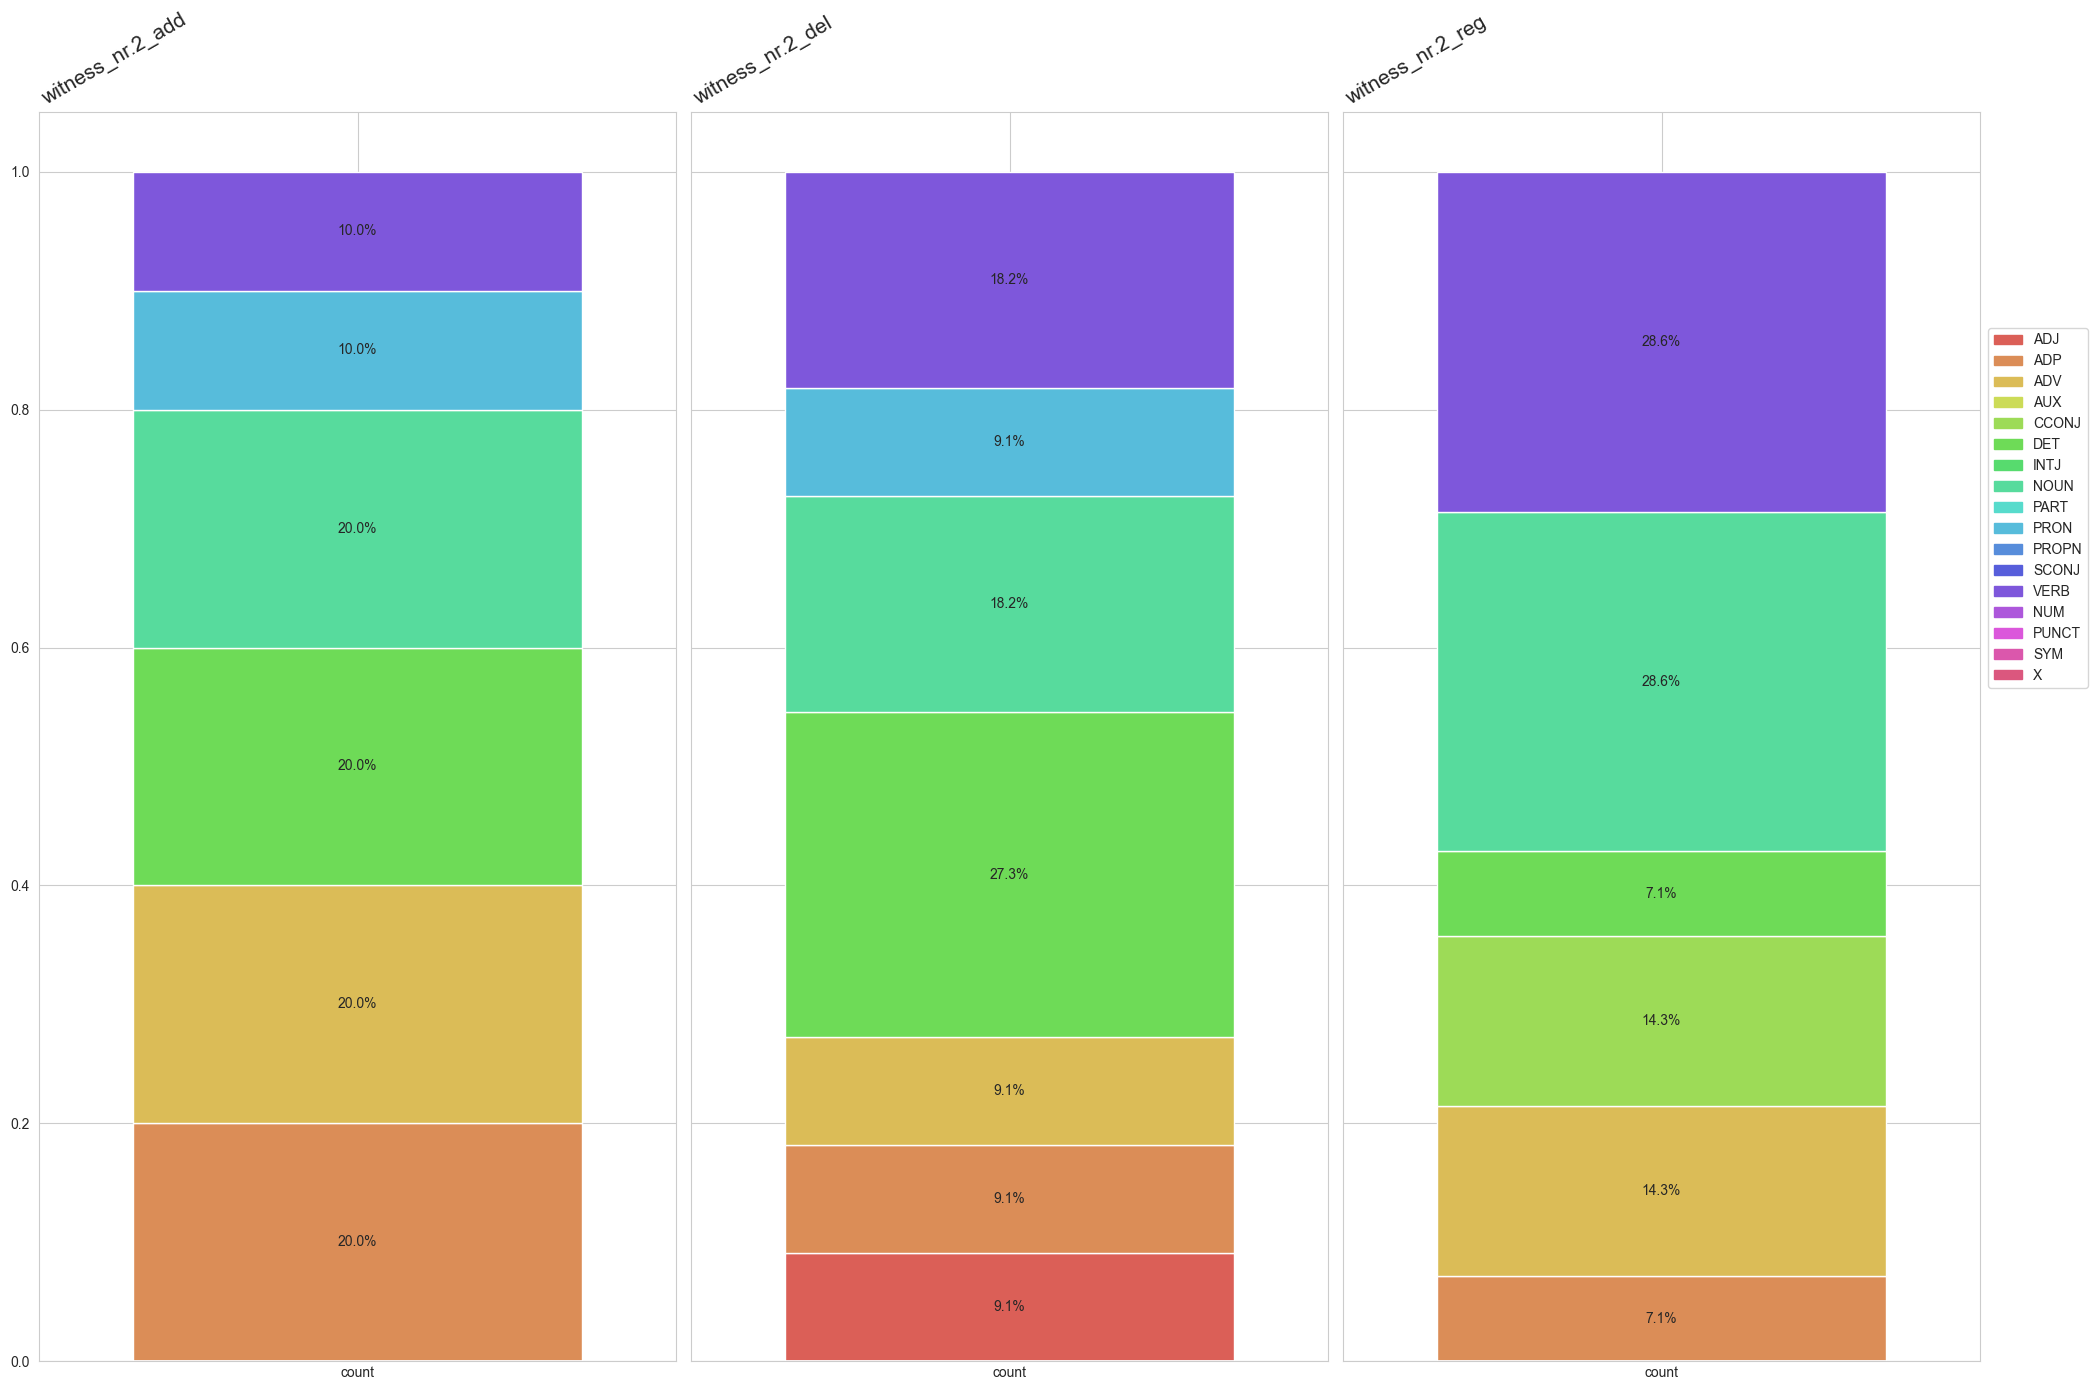

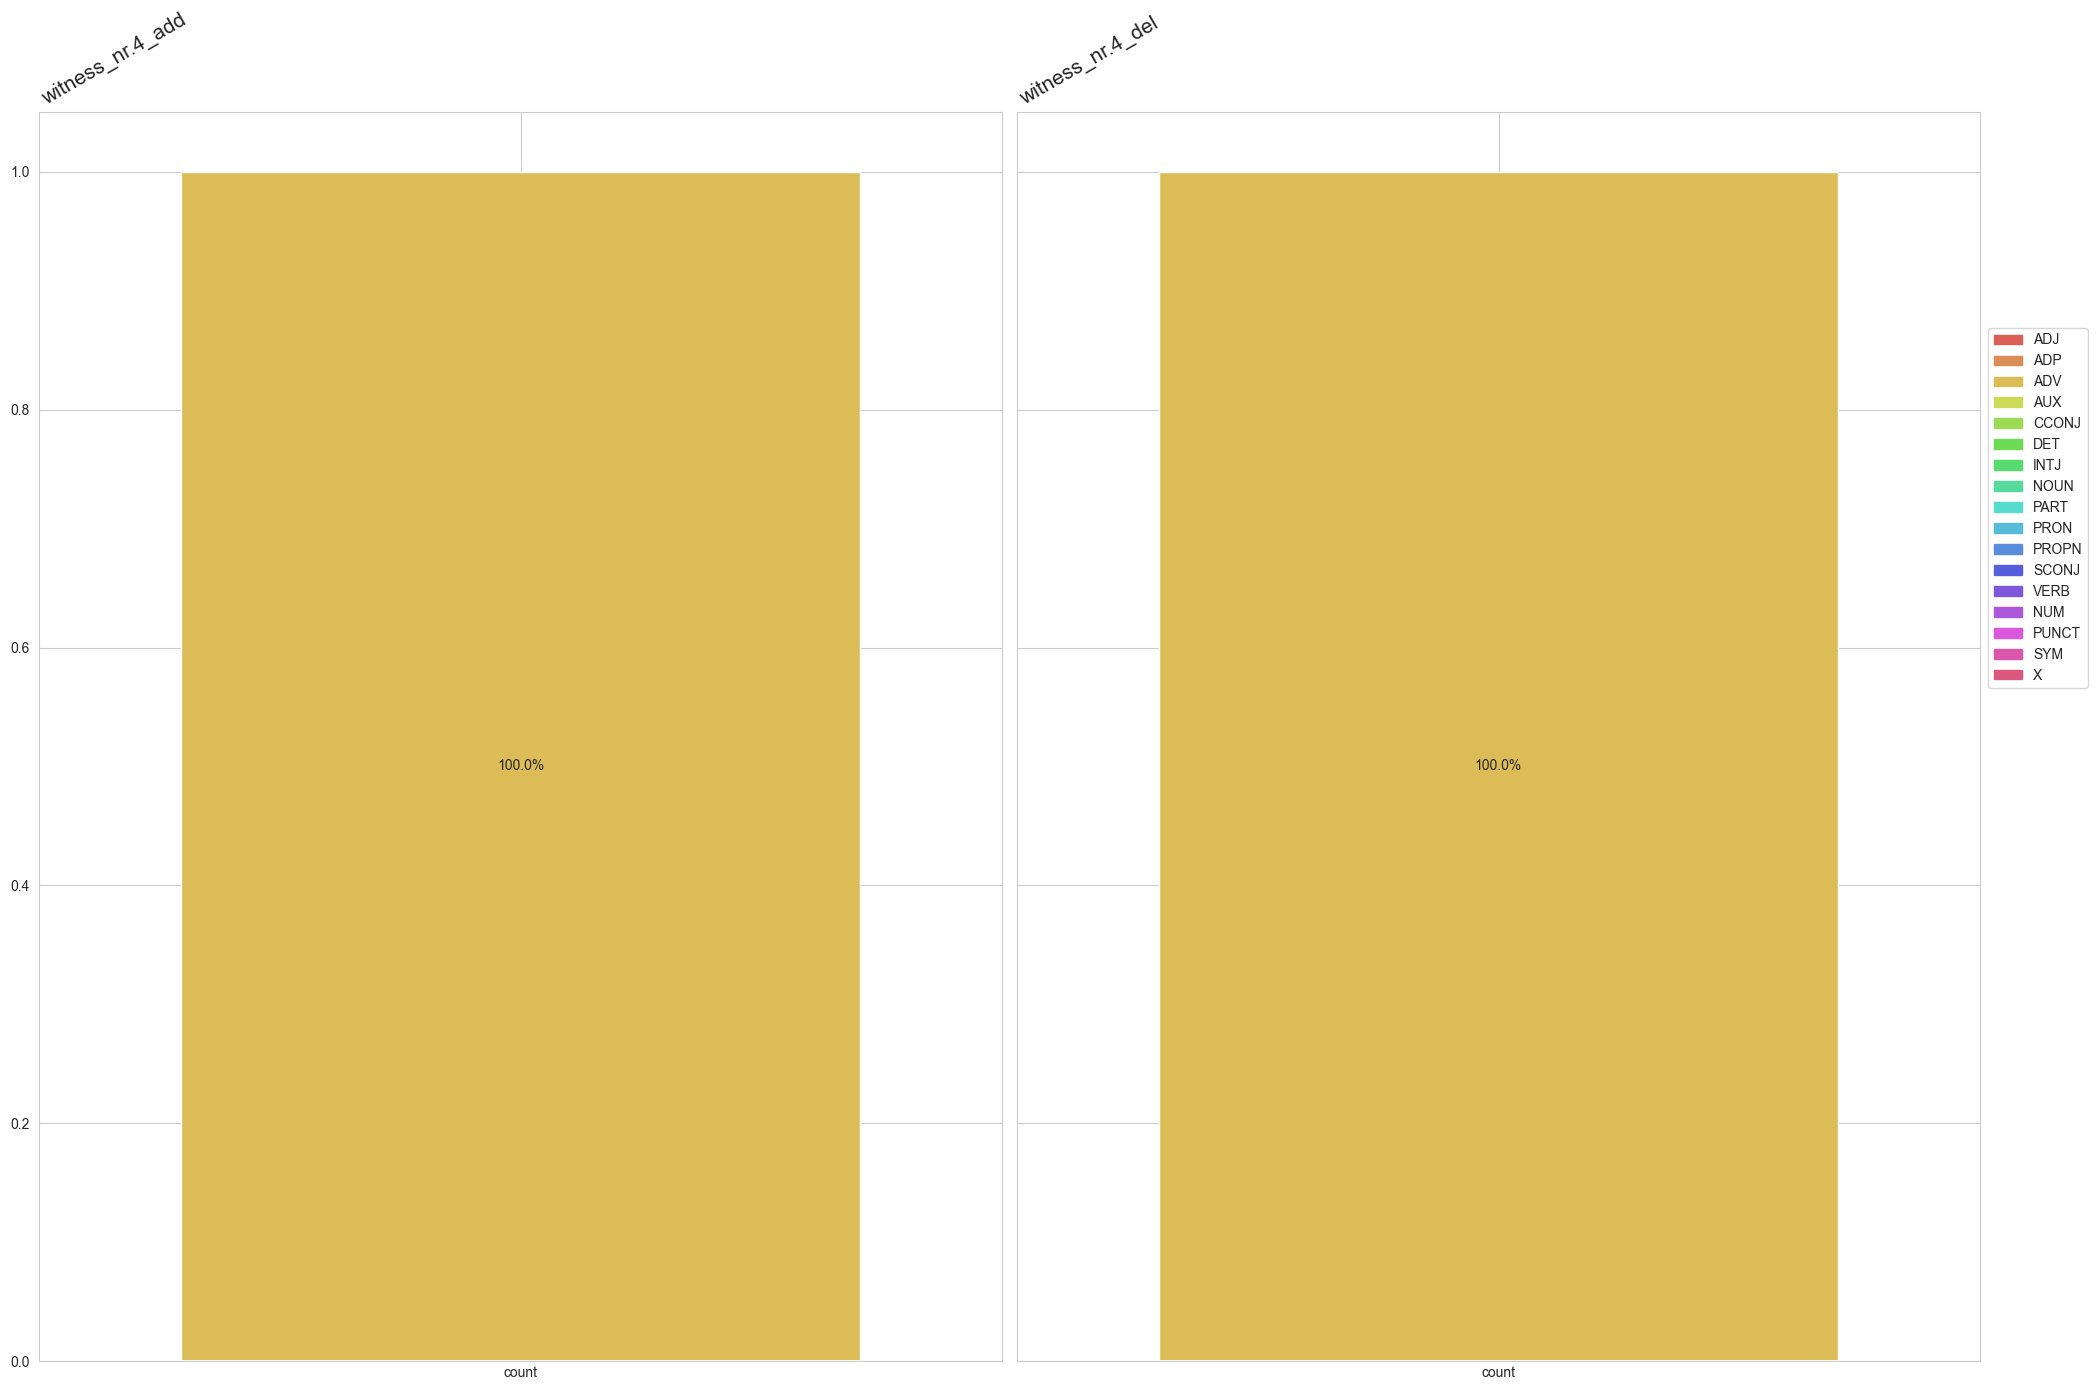

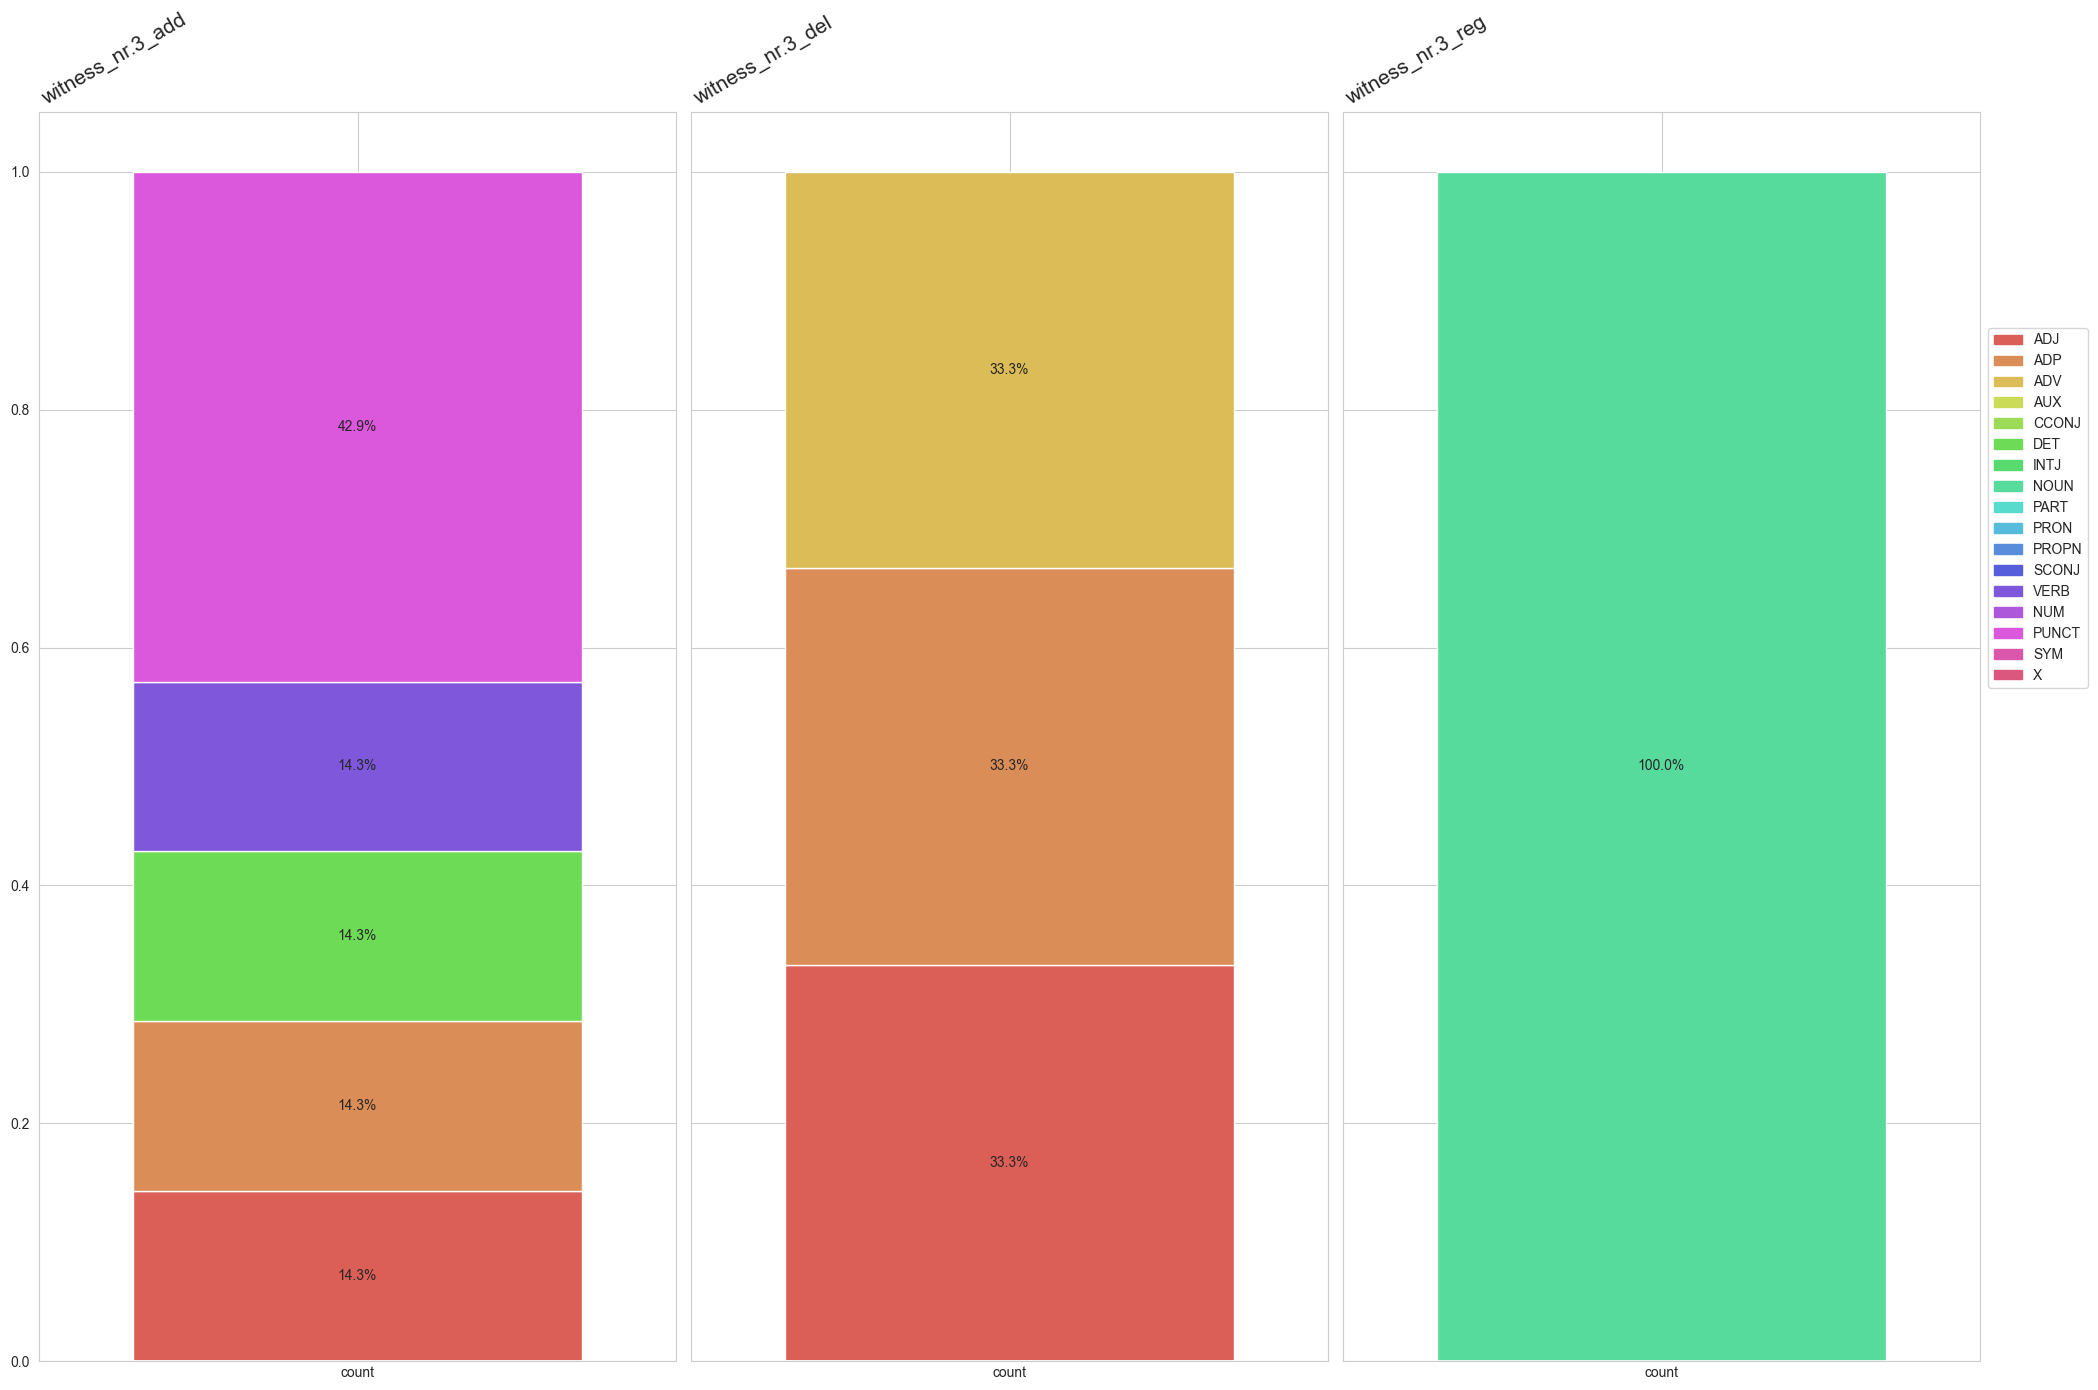

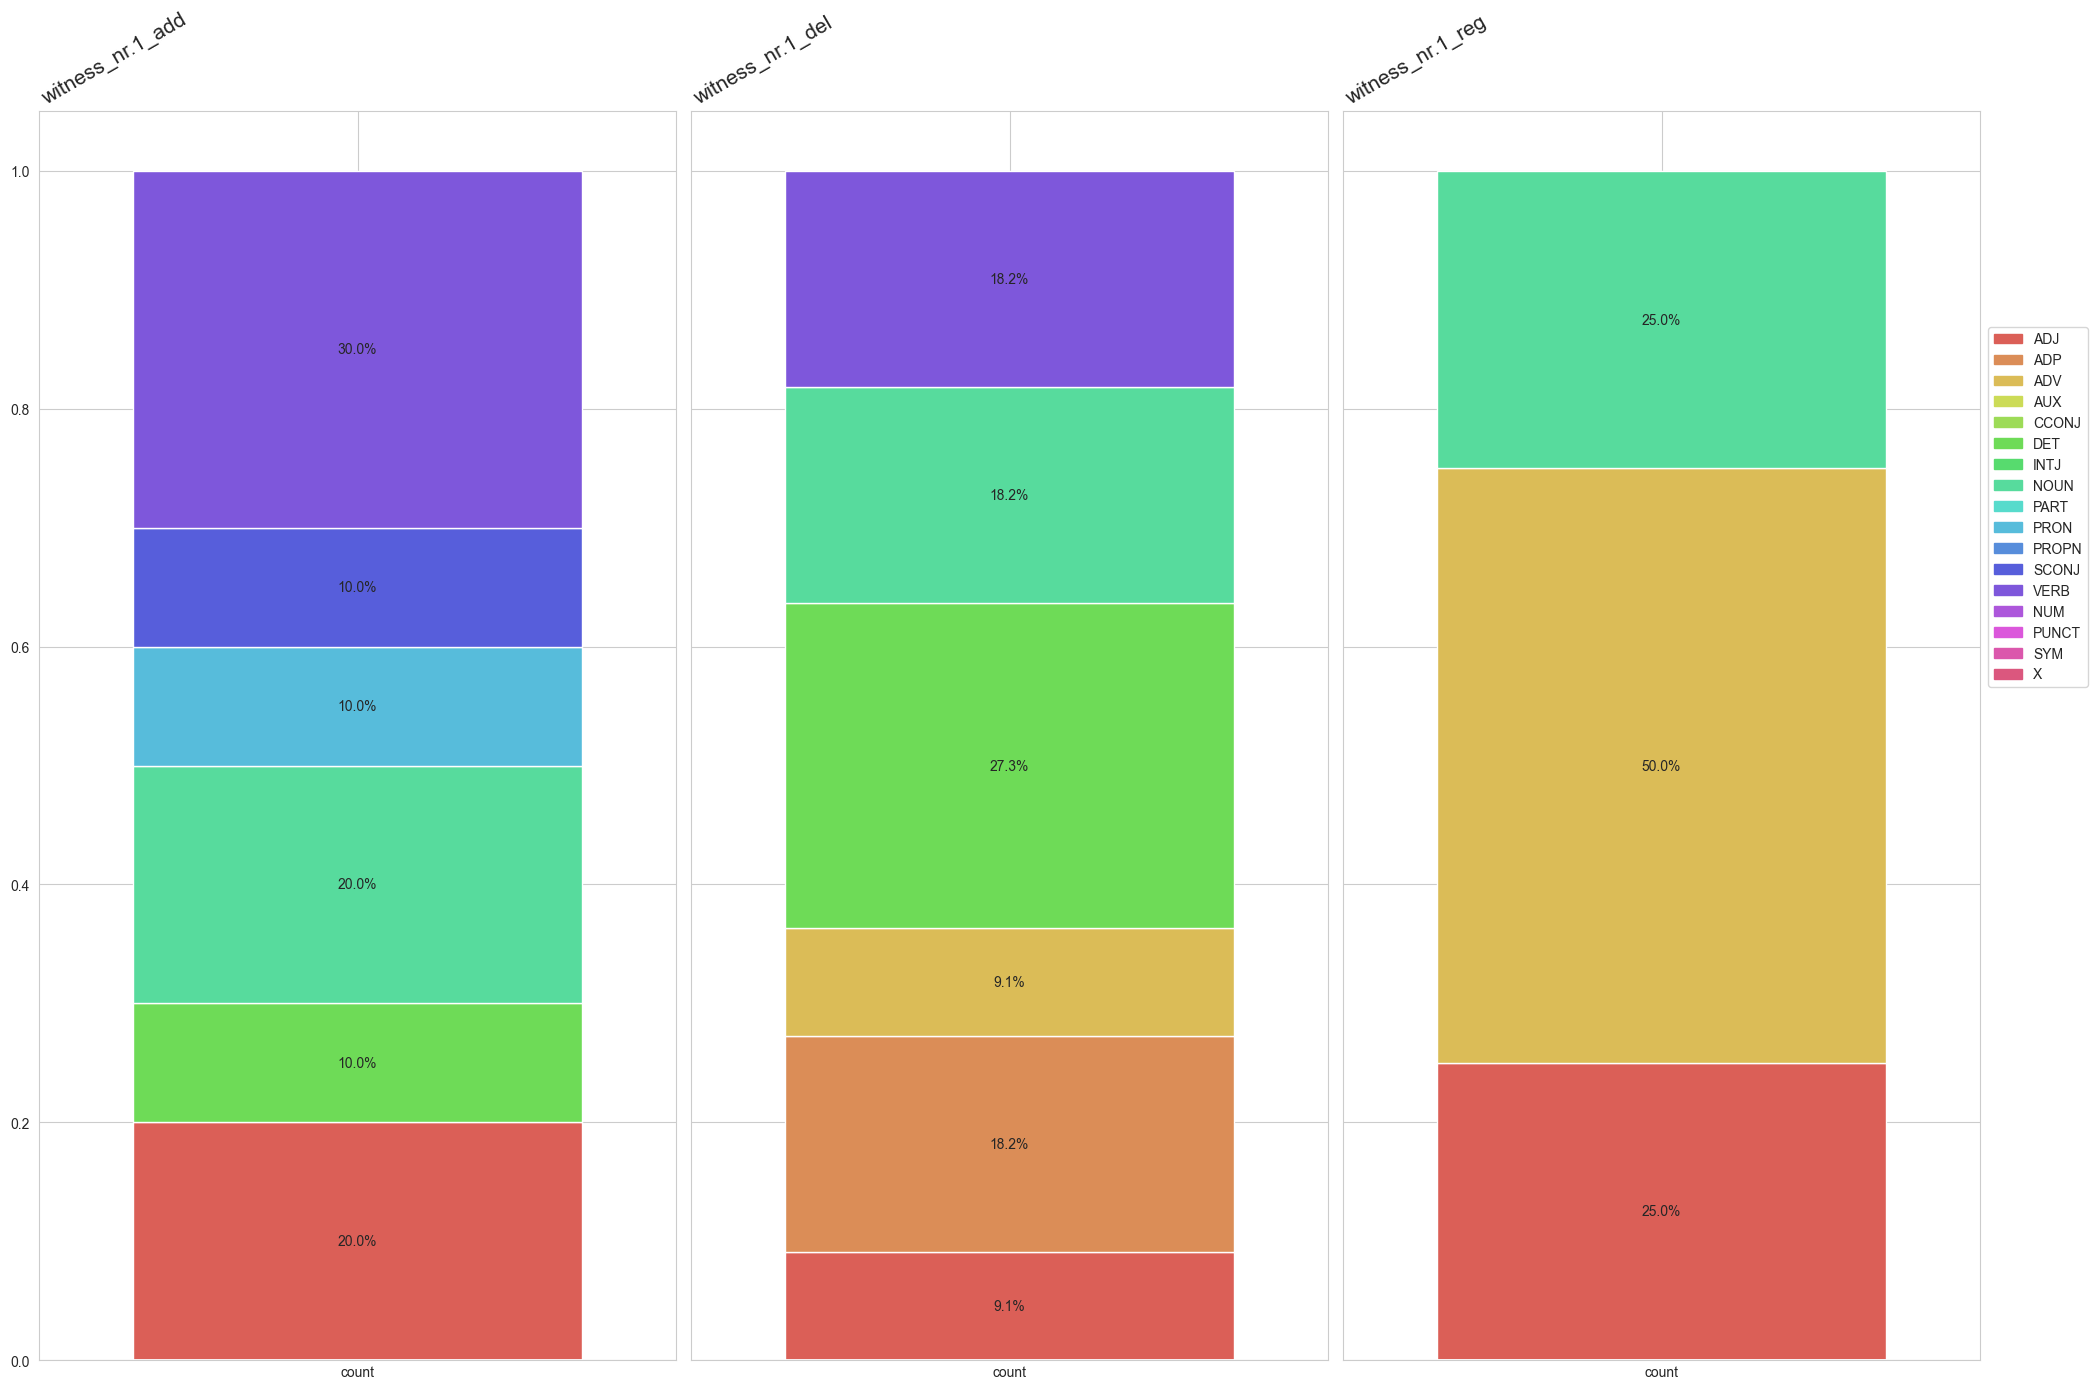

In [22]:
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Kombination_Eingriffe_Token-POS_csvs'

csv_files = [filename for filename in os.listdir(directory) if filename.startswith('rel_counts_') and filename.endswith('.csv')]
witnesses = set()

for csv_file in csv_files:
    witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
    if witness not in witnesses: 
        witnesses.add(witness)
        
    interfer_type = csv_file.split('rel_counts_')[-1].split('_POS_')[0]


for witness in witnesses: 
    abs_dfs = {}
    for csv_file in csv_files: 
        if witness in csv_file.split('_POS_')[-1].split('_df.csv')[0]: 
            df = pd.read_csv(os.path.join(directory, csv_file))
            interfer_type = csv_file.split('rel_counts_')[-1].split('_POS_')[0]
            df_name = f"{witness}_{interfer_type}"
            abs_dfs[df_name] = df
            
    all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')

    palette = sns.color_palette("hls", n_colors=len(all_categories))

    category_color_map = dict(zip(all_categories, palette))

    label_map = {category: category.split("-")[0] for category in all_categories}

    num_dfs = len(abs_dfs)
    fig, axes = plt.subplots(1, num_dfs, figsize=(20, 14), sharey=True)

    legend_handles = []
    legend_labels = set()

    threshold = 0

    for idx, (df_name, df) in enumerate(abs_dfs.items()):
        ax = axes[idx] if num_dfs > 1 else axes  
        stacked_df = df.set_index('pos').T
    
        for category in all_categories:
            if category not in stacked_df.columns:
                stacked_df[category] = 0  
        stacked_df = stacked_df.reindex(columns=all_categories)
        
        stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)

        ax.set_xlabel(f'',fontsize=10, rotation=45)
        ax.xaxis.label.set_color('black')
        ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
        ax.tick_params(axis='x', rotation=0, size=0, color='white')

        for container in ax.containers:
            labels = [f"{val:.1%}" if val > threshold else "" for val in container.datavalues]  
            ax.bar_label(container, labels=labels, label_type='center')
        
        for category in all_categories:
            if category not in legend_labels: 
                legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
                legend_labels.add(category)  
                
    fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')

    plt.tight_layout()

    plt.savefig(f'{foldername}/VisVergleich_relativ_{witness}_Eingriffe_pos_{poem}.png')

    plt.show()
        
        

#### nach Eingriff (add, del, reg) / absolute Counts: 

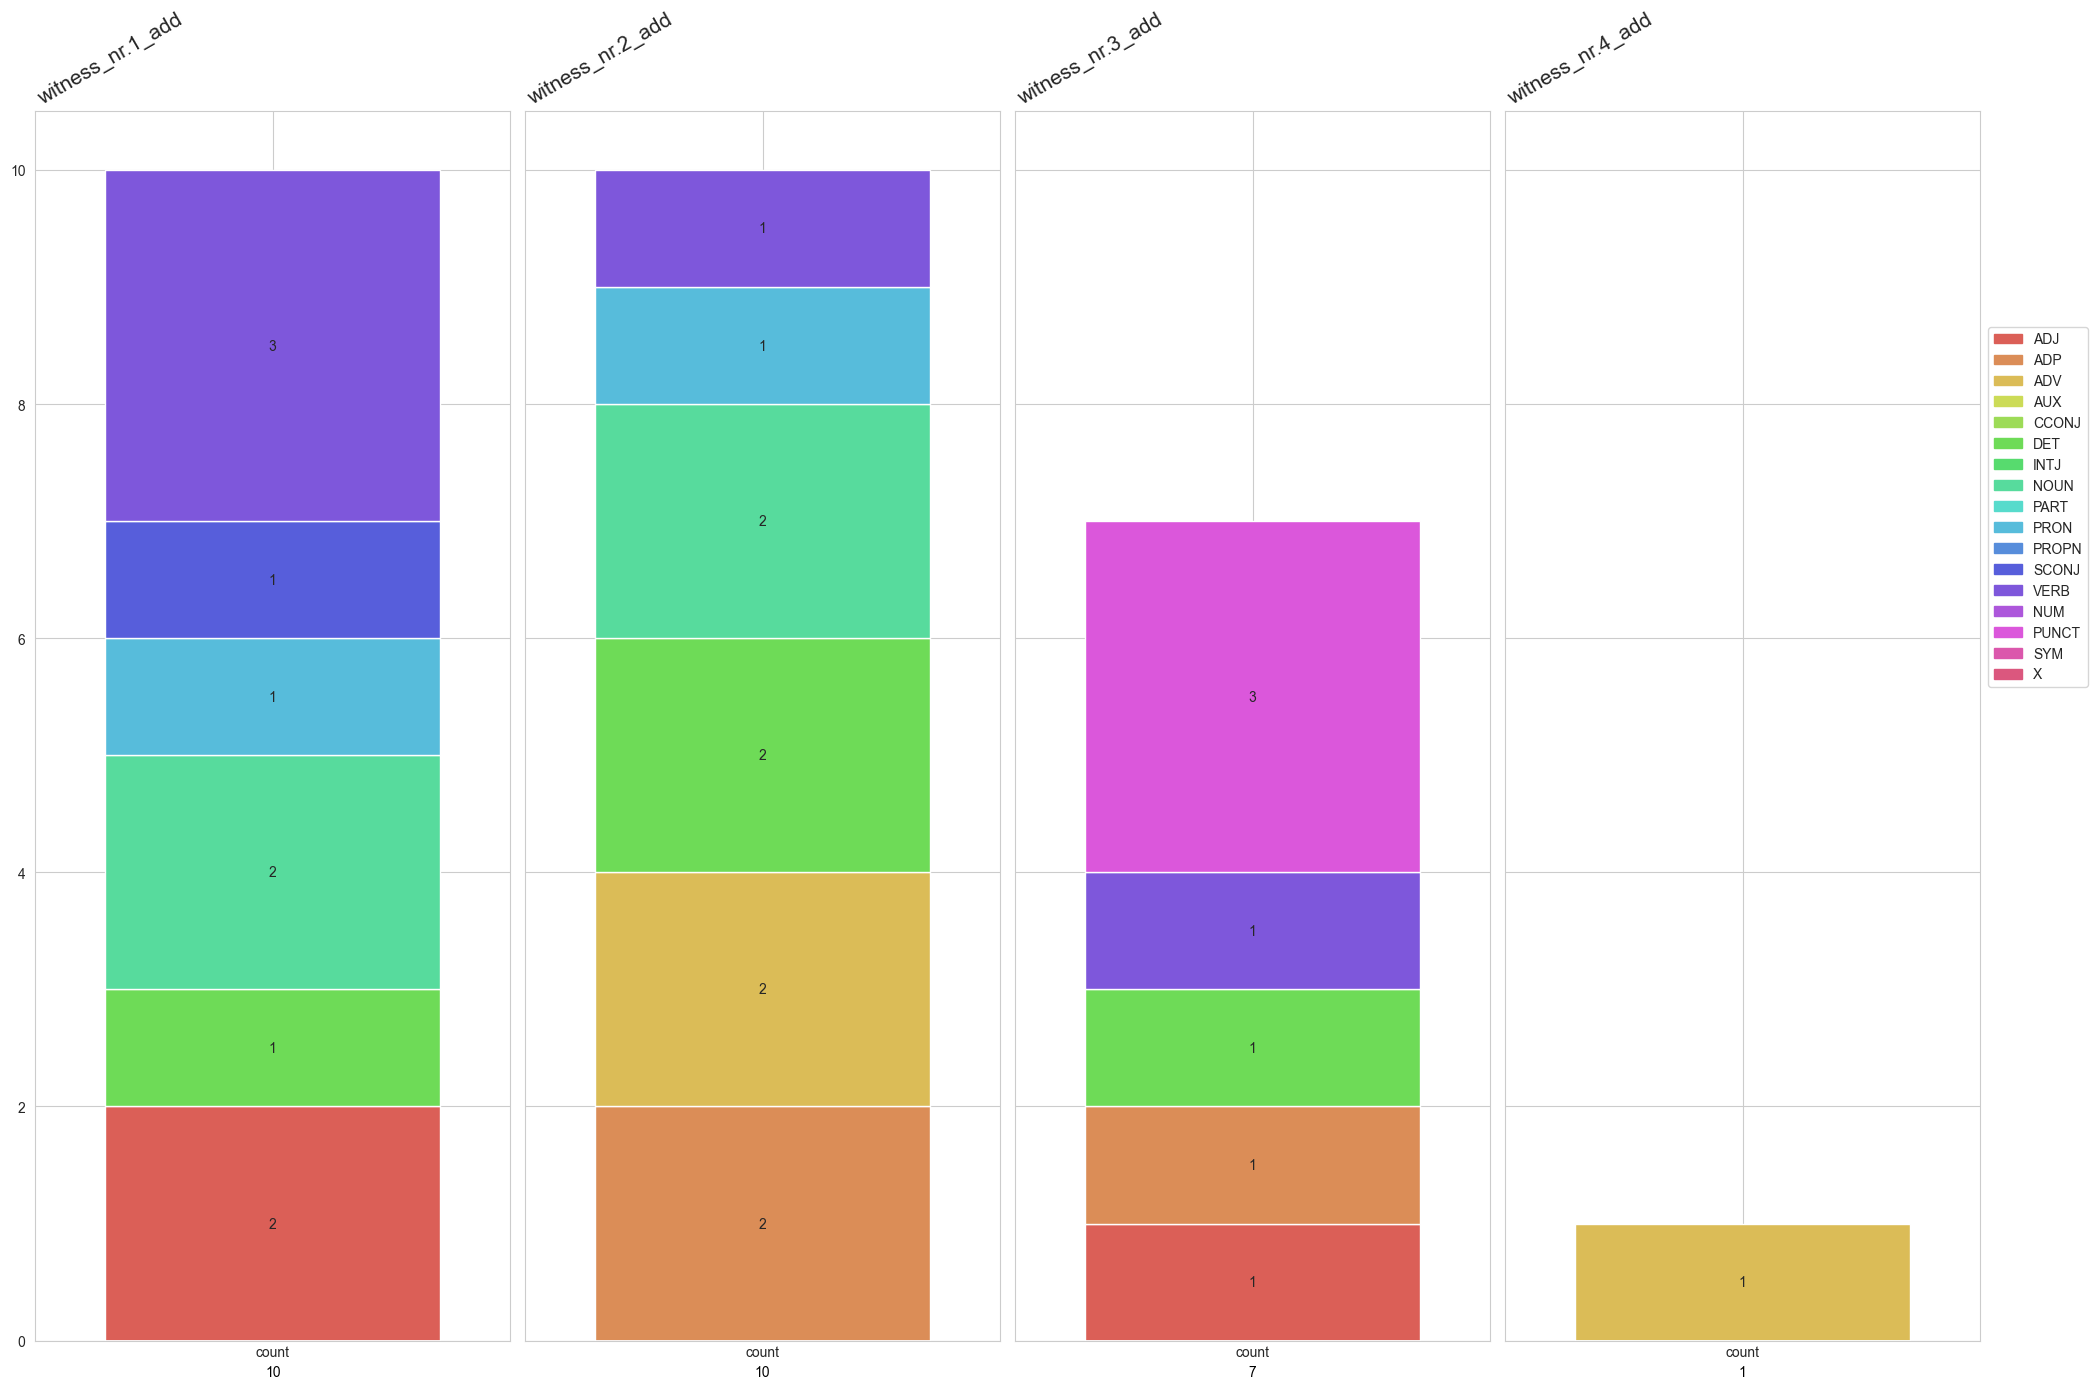

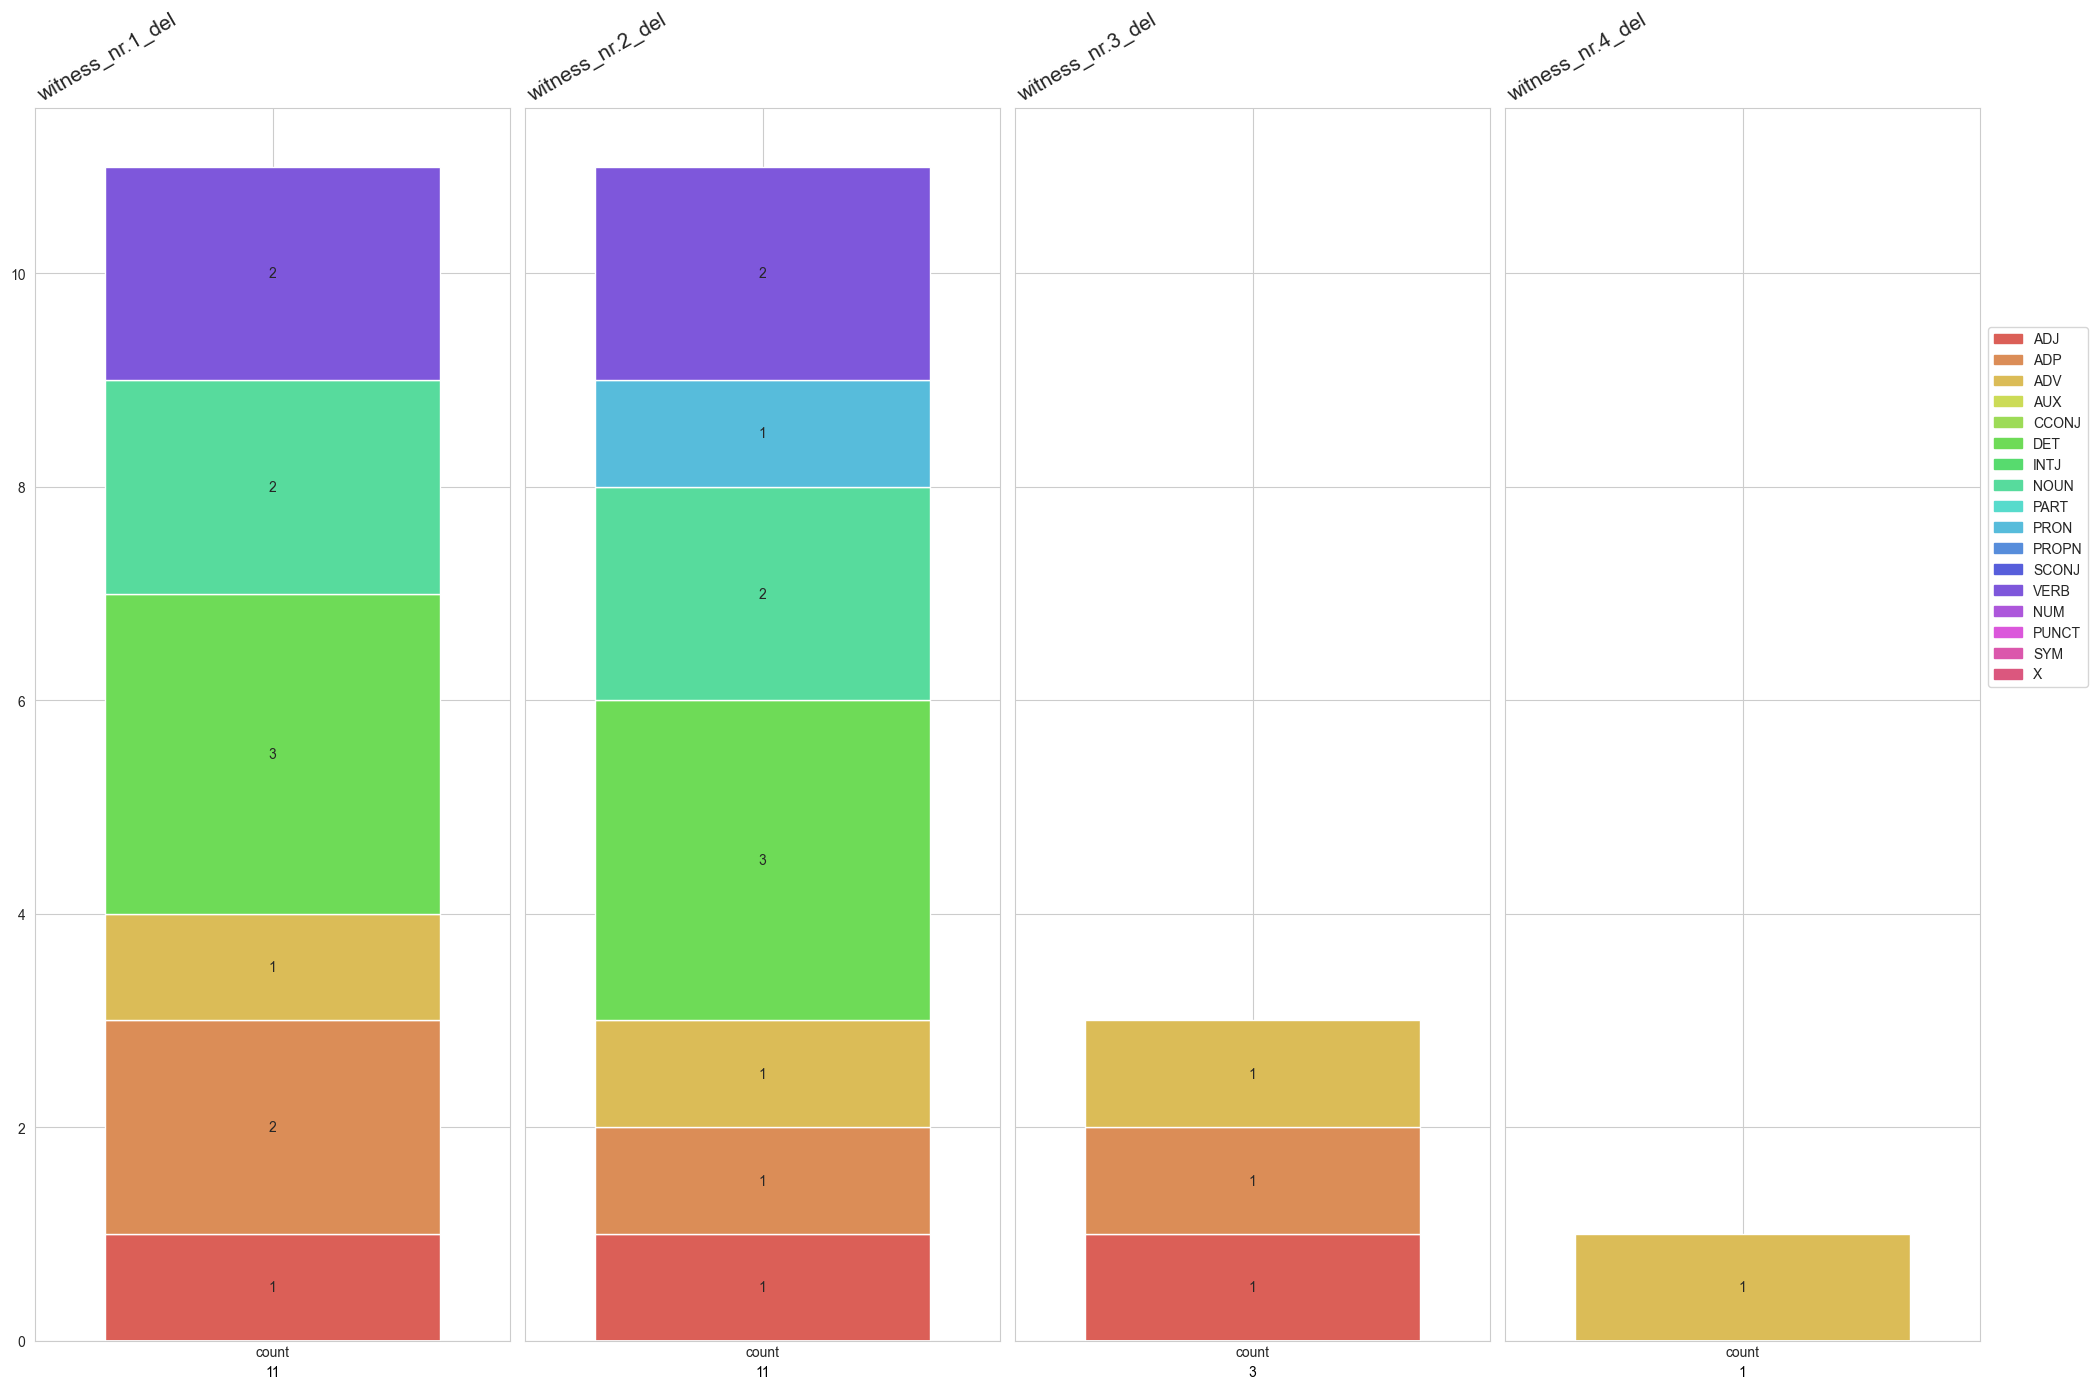

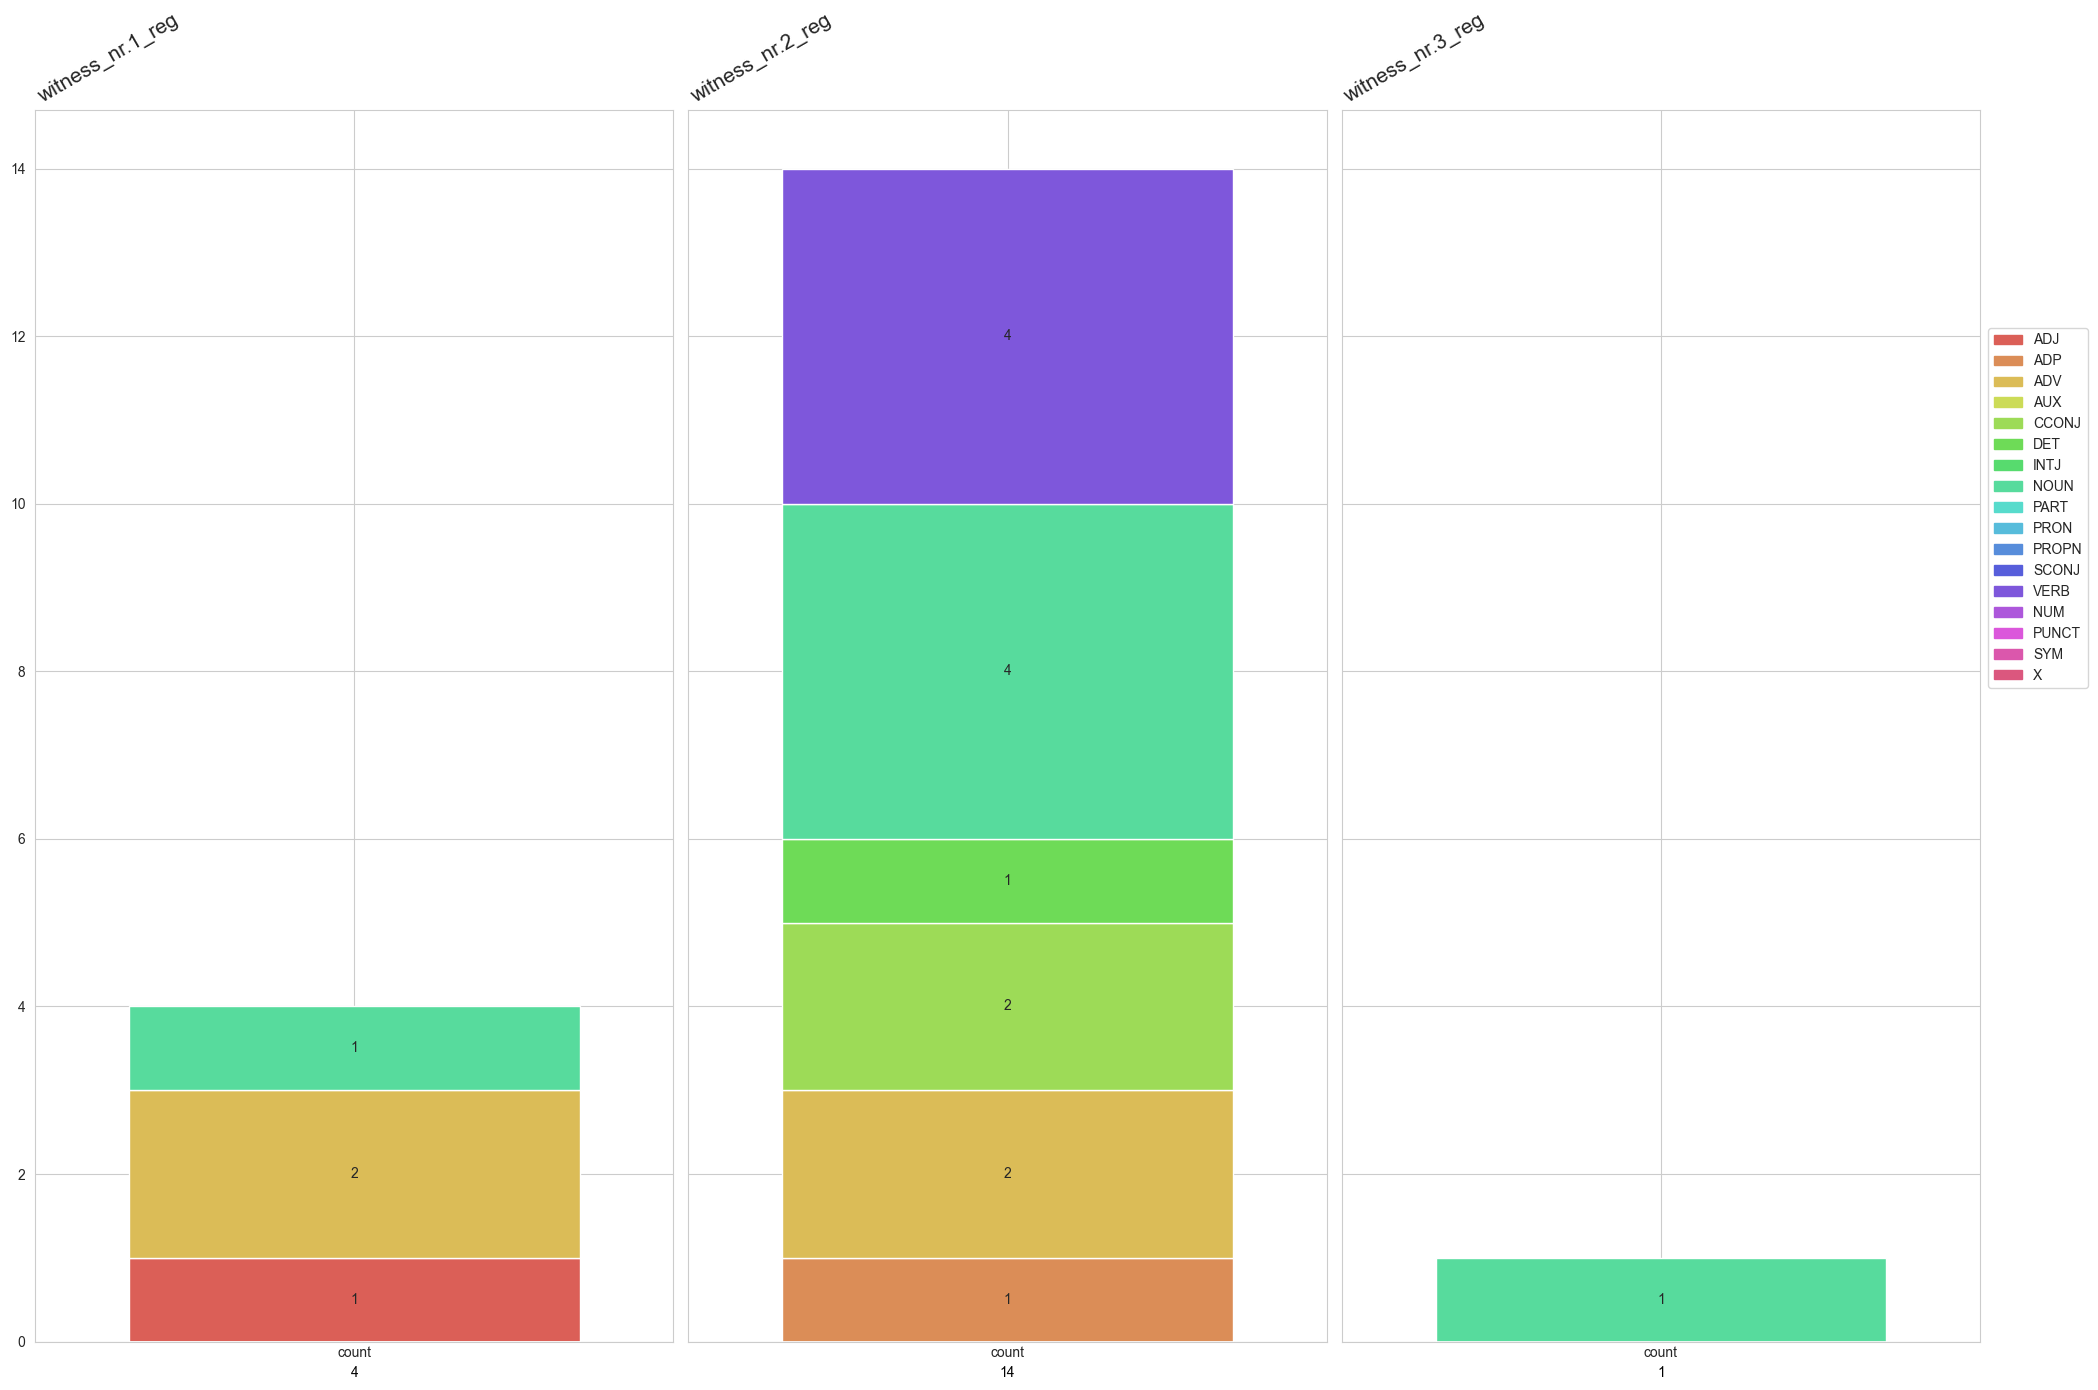

In [23]:
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Kombination_Eingriffe_Token-POS_csvs'

csv_files = [filename for filename in os.listdir(directory) if filename.startswith('abs_counts_') and filename.endswith('.csv')]
interferences = set()

for csv_file in csv_files:

    witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
        
    interfer_type = csv_file.split('abs_counts_')[-1].split('_POS_')[0]
    if interfer_type not in interferences: 
        interferences.add(interfer_type)

for interfer_type in interferences: 
    abs_dfs = {}
    for csv_file in csv_files: 
        if interfer_type in csv_file.split('abs_counts_')[-1].split('_POS_')[0]: 
            df = pd.read_csv(os.path.join(directory, csv_file))
            witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
            df_name = f"{witness}_{interfer_type}"
            abs_dfs[df_name] = df
            all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')
    
    palette = sns.color_palette("hls", n_colors=len(all_categories))
    
    category_color_map = dict(zip(all_categories, palette))
    
    label_map = {category: category.split("-")[0] for category in all_categories}
    
    num_dfs = len(abs_dfs)
    fig, axes = plt.subplots(1, num_dfs, figsize=(20, 14), sharey=True)
    
    legend_handles = []
    legend_labels = set()  
    threshold = 0
    
    for idx, (df_name, df) in enumerate(abs_dfs.items()):
        ax = axes[idx] if num_dfs > 1 else axes  
        totals = df['count'].sum()
        stacked_df = df.set_index('pos').T
    
        for category in all_categories:
            if category not in stacked_df.columns:
                stacked_df[category] = 0  
        stacked_df = stacked_df.reindex(columns=all_categories)
        
        stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)
    
        ax.set_xlabel(totals,fontsize=10, rotation=0)
        ax.xaxis.label.set_color('black')
        ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
        ax.tick_params(axis='x', rotation=0, size=0, color='white')
    
        for container in ax.containers:
            labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues]  
            ax.bar_label(container, labels=labels, label_type='center')
        
        for category in all_categories:
            if category not in legend_labels:  
                legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
                legend_labels.add(category)  
                
    fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')
    
    plt.tight_layout()

    plt.savefig(f'{foldername}/VisVergleich_absolut_{interfer_type}_Eingriffe_pos_{poem}.png')

    plt.show()
        
        

##### relative Counts

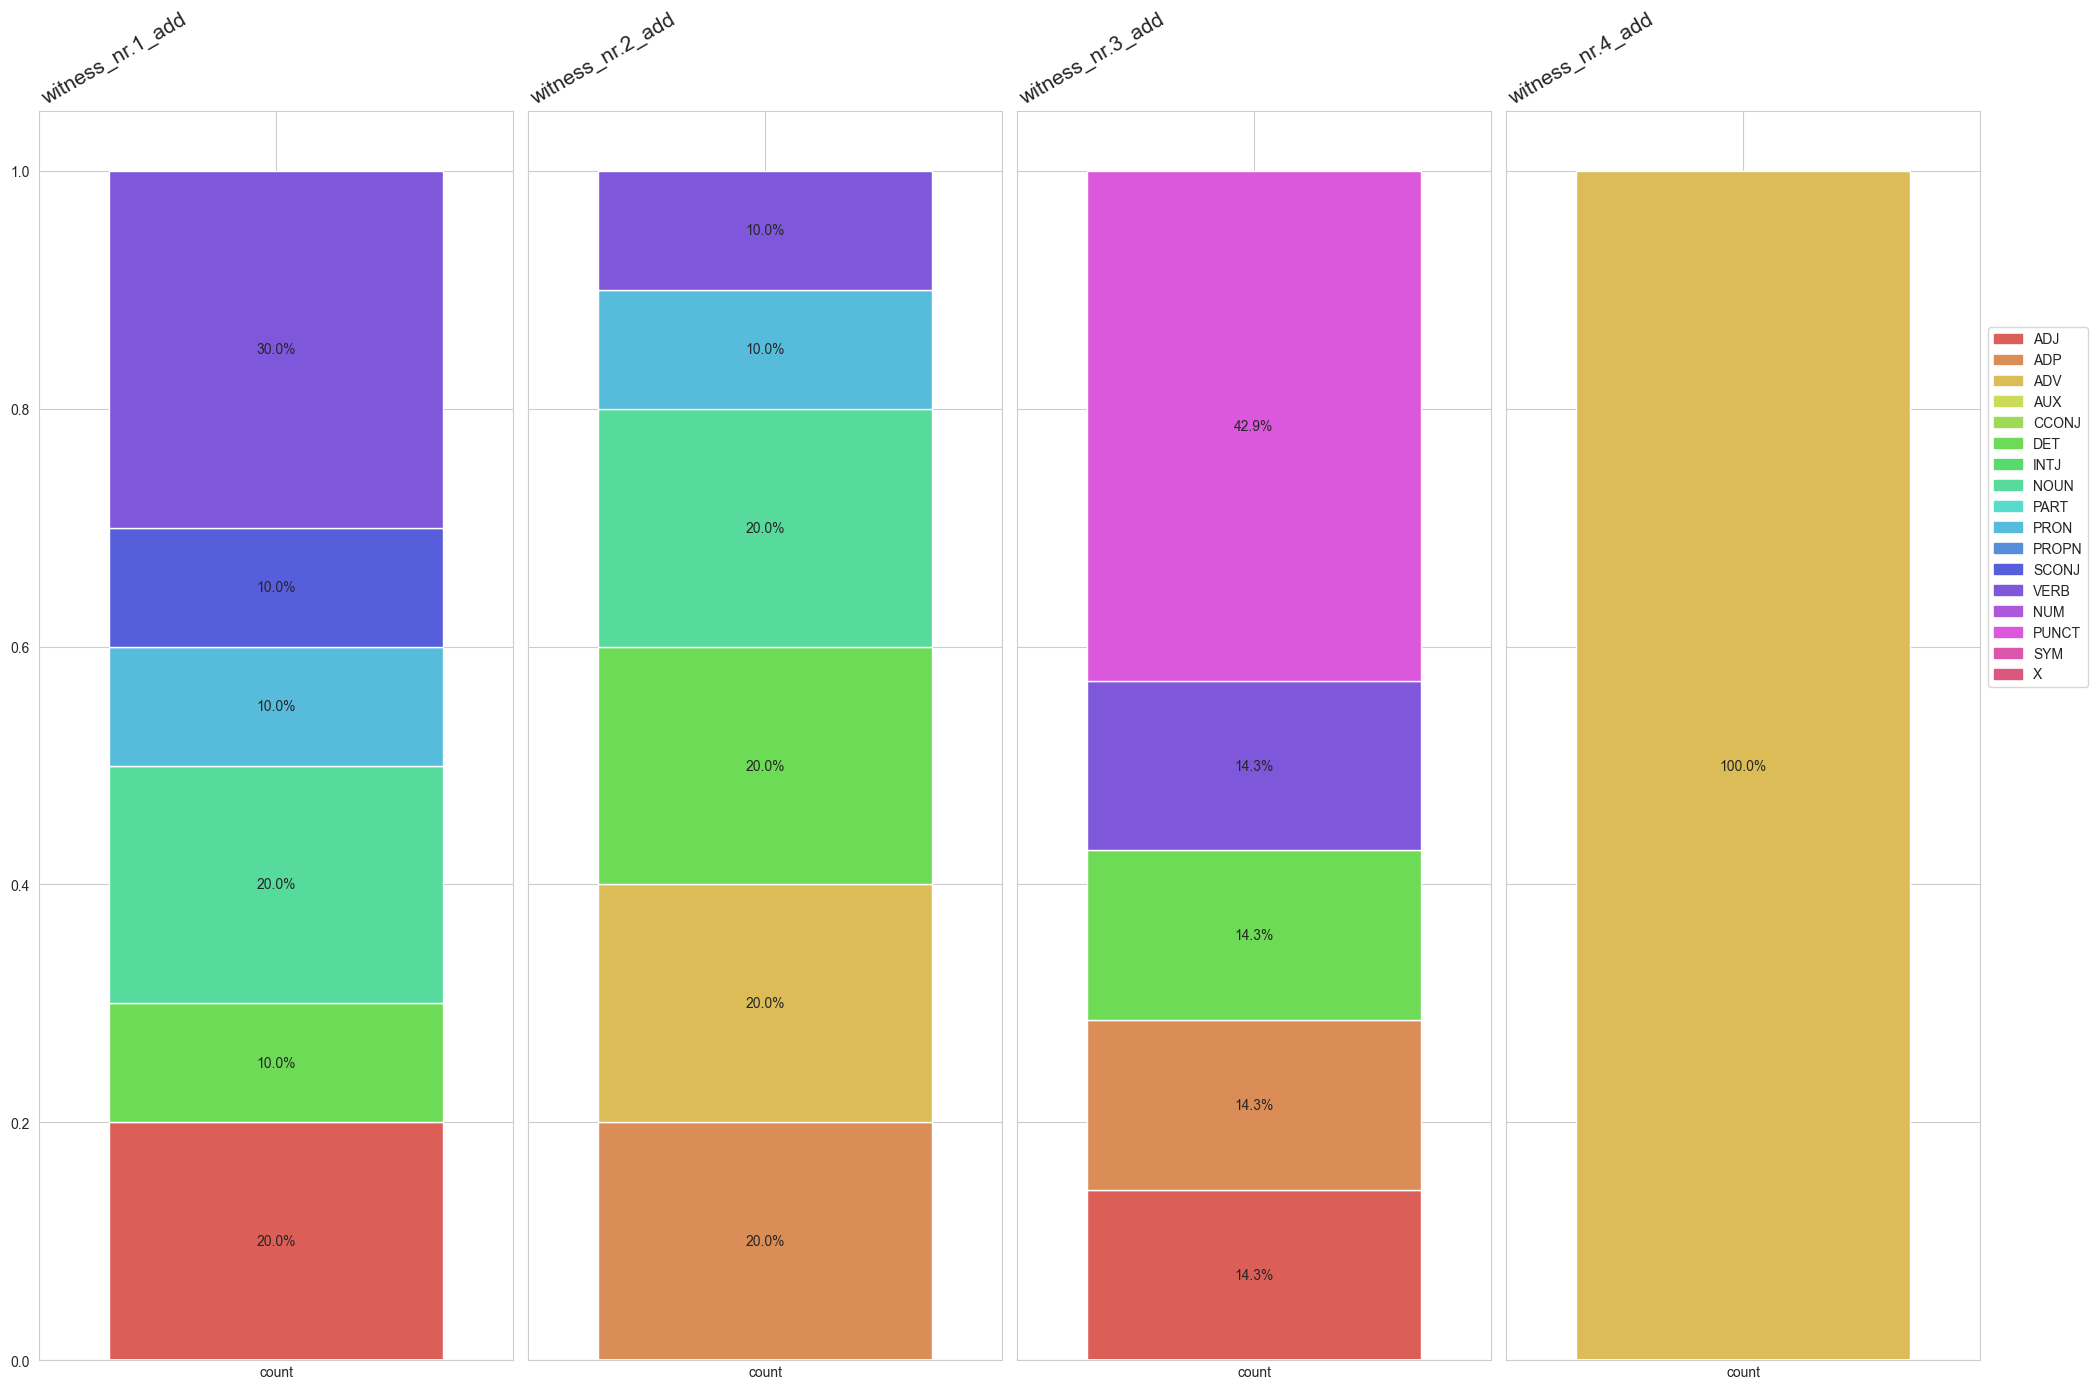

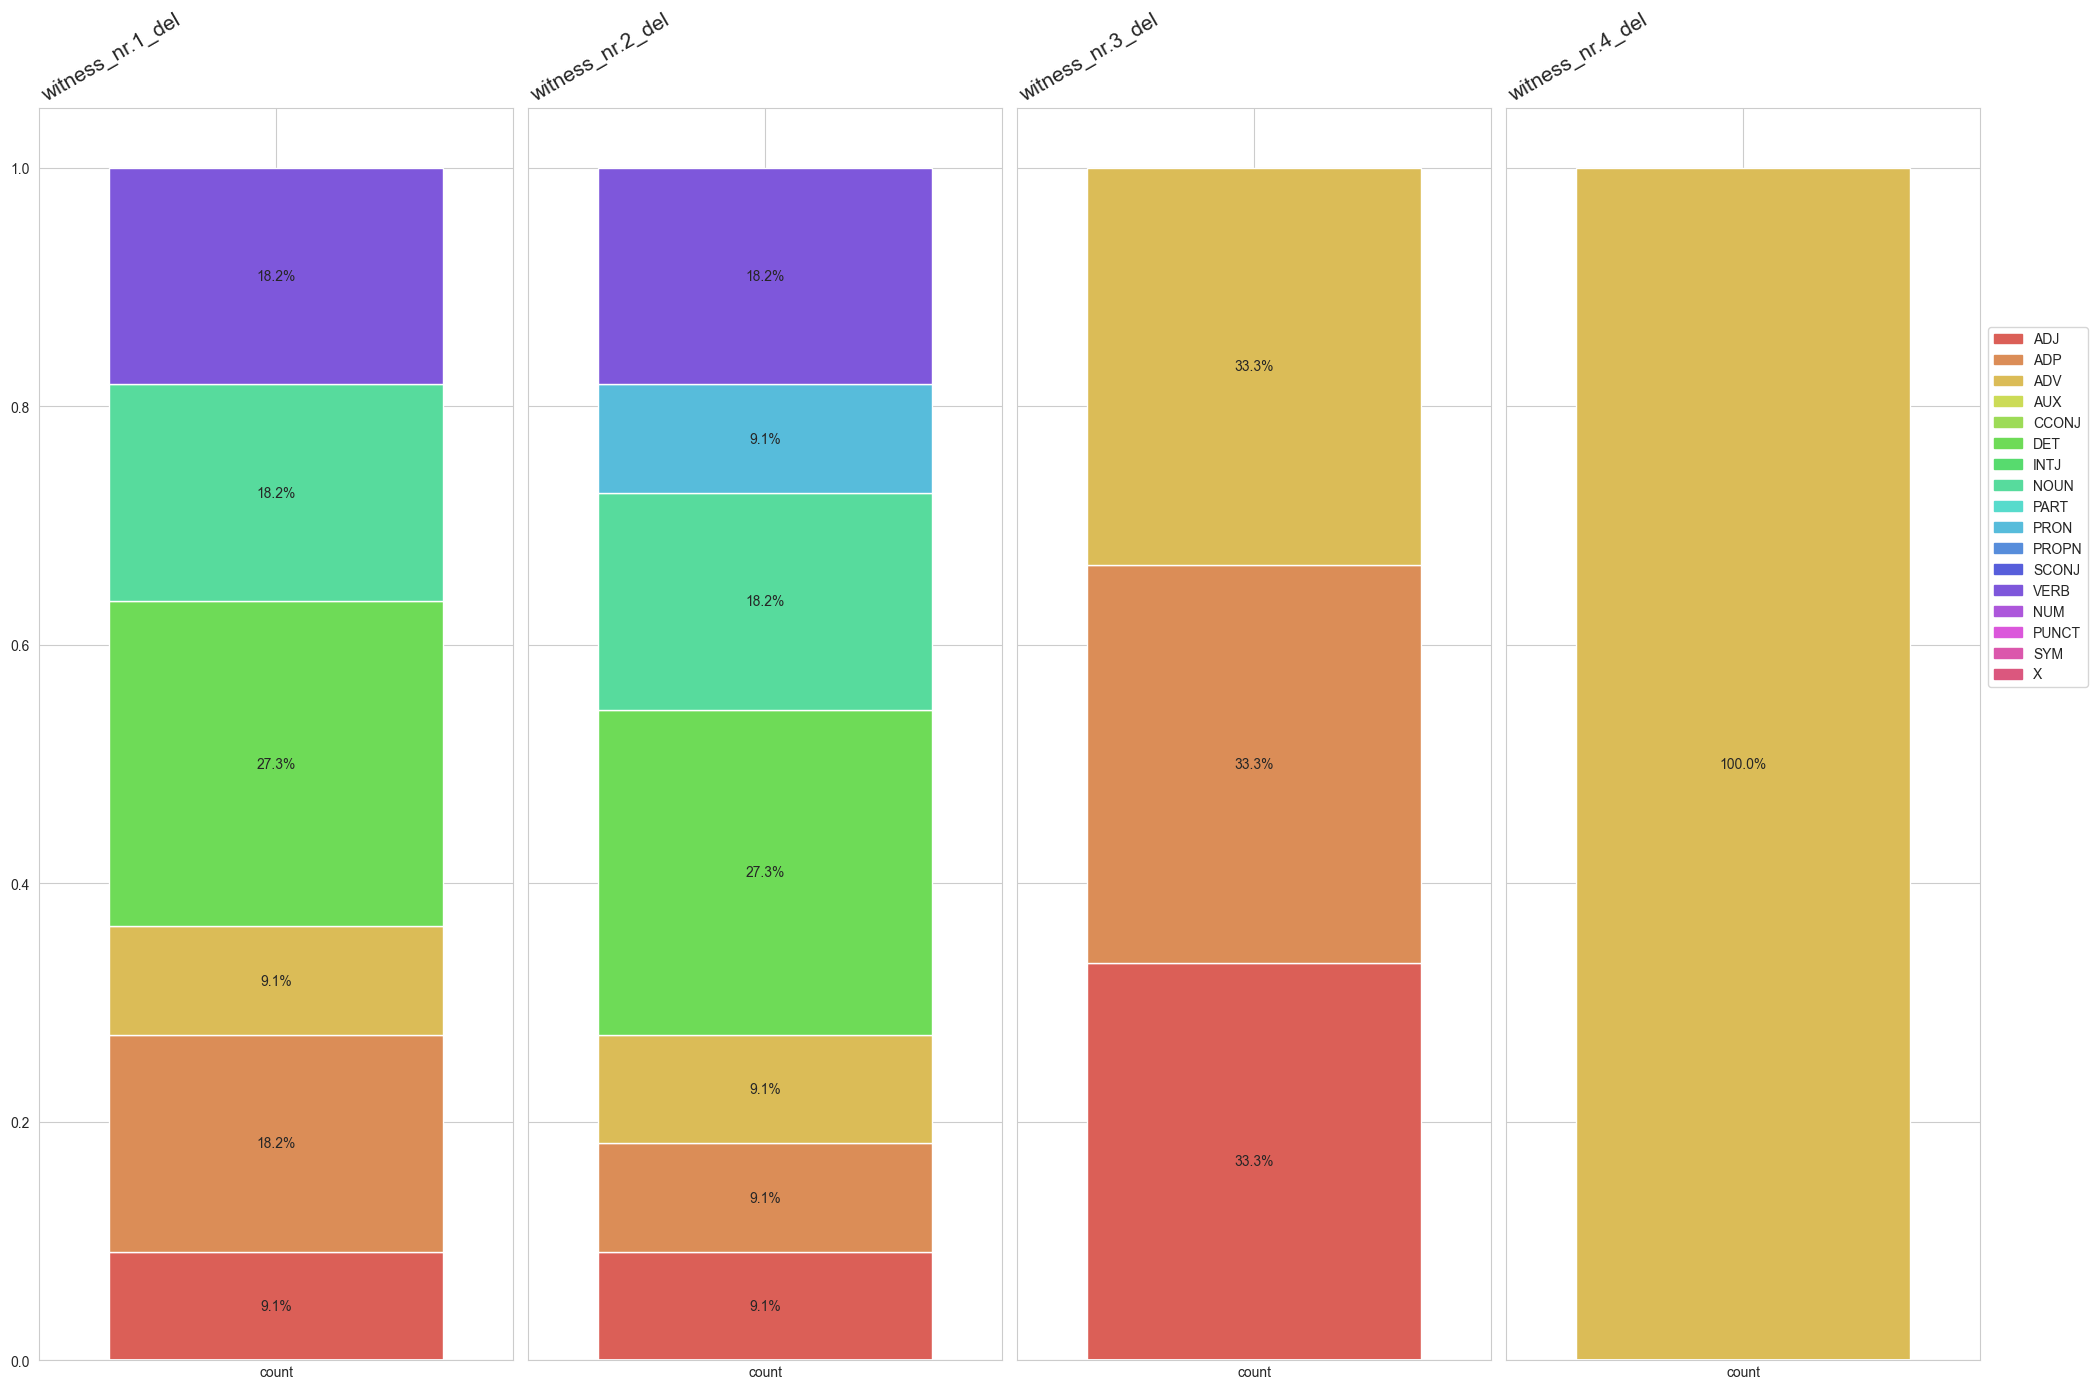

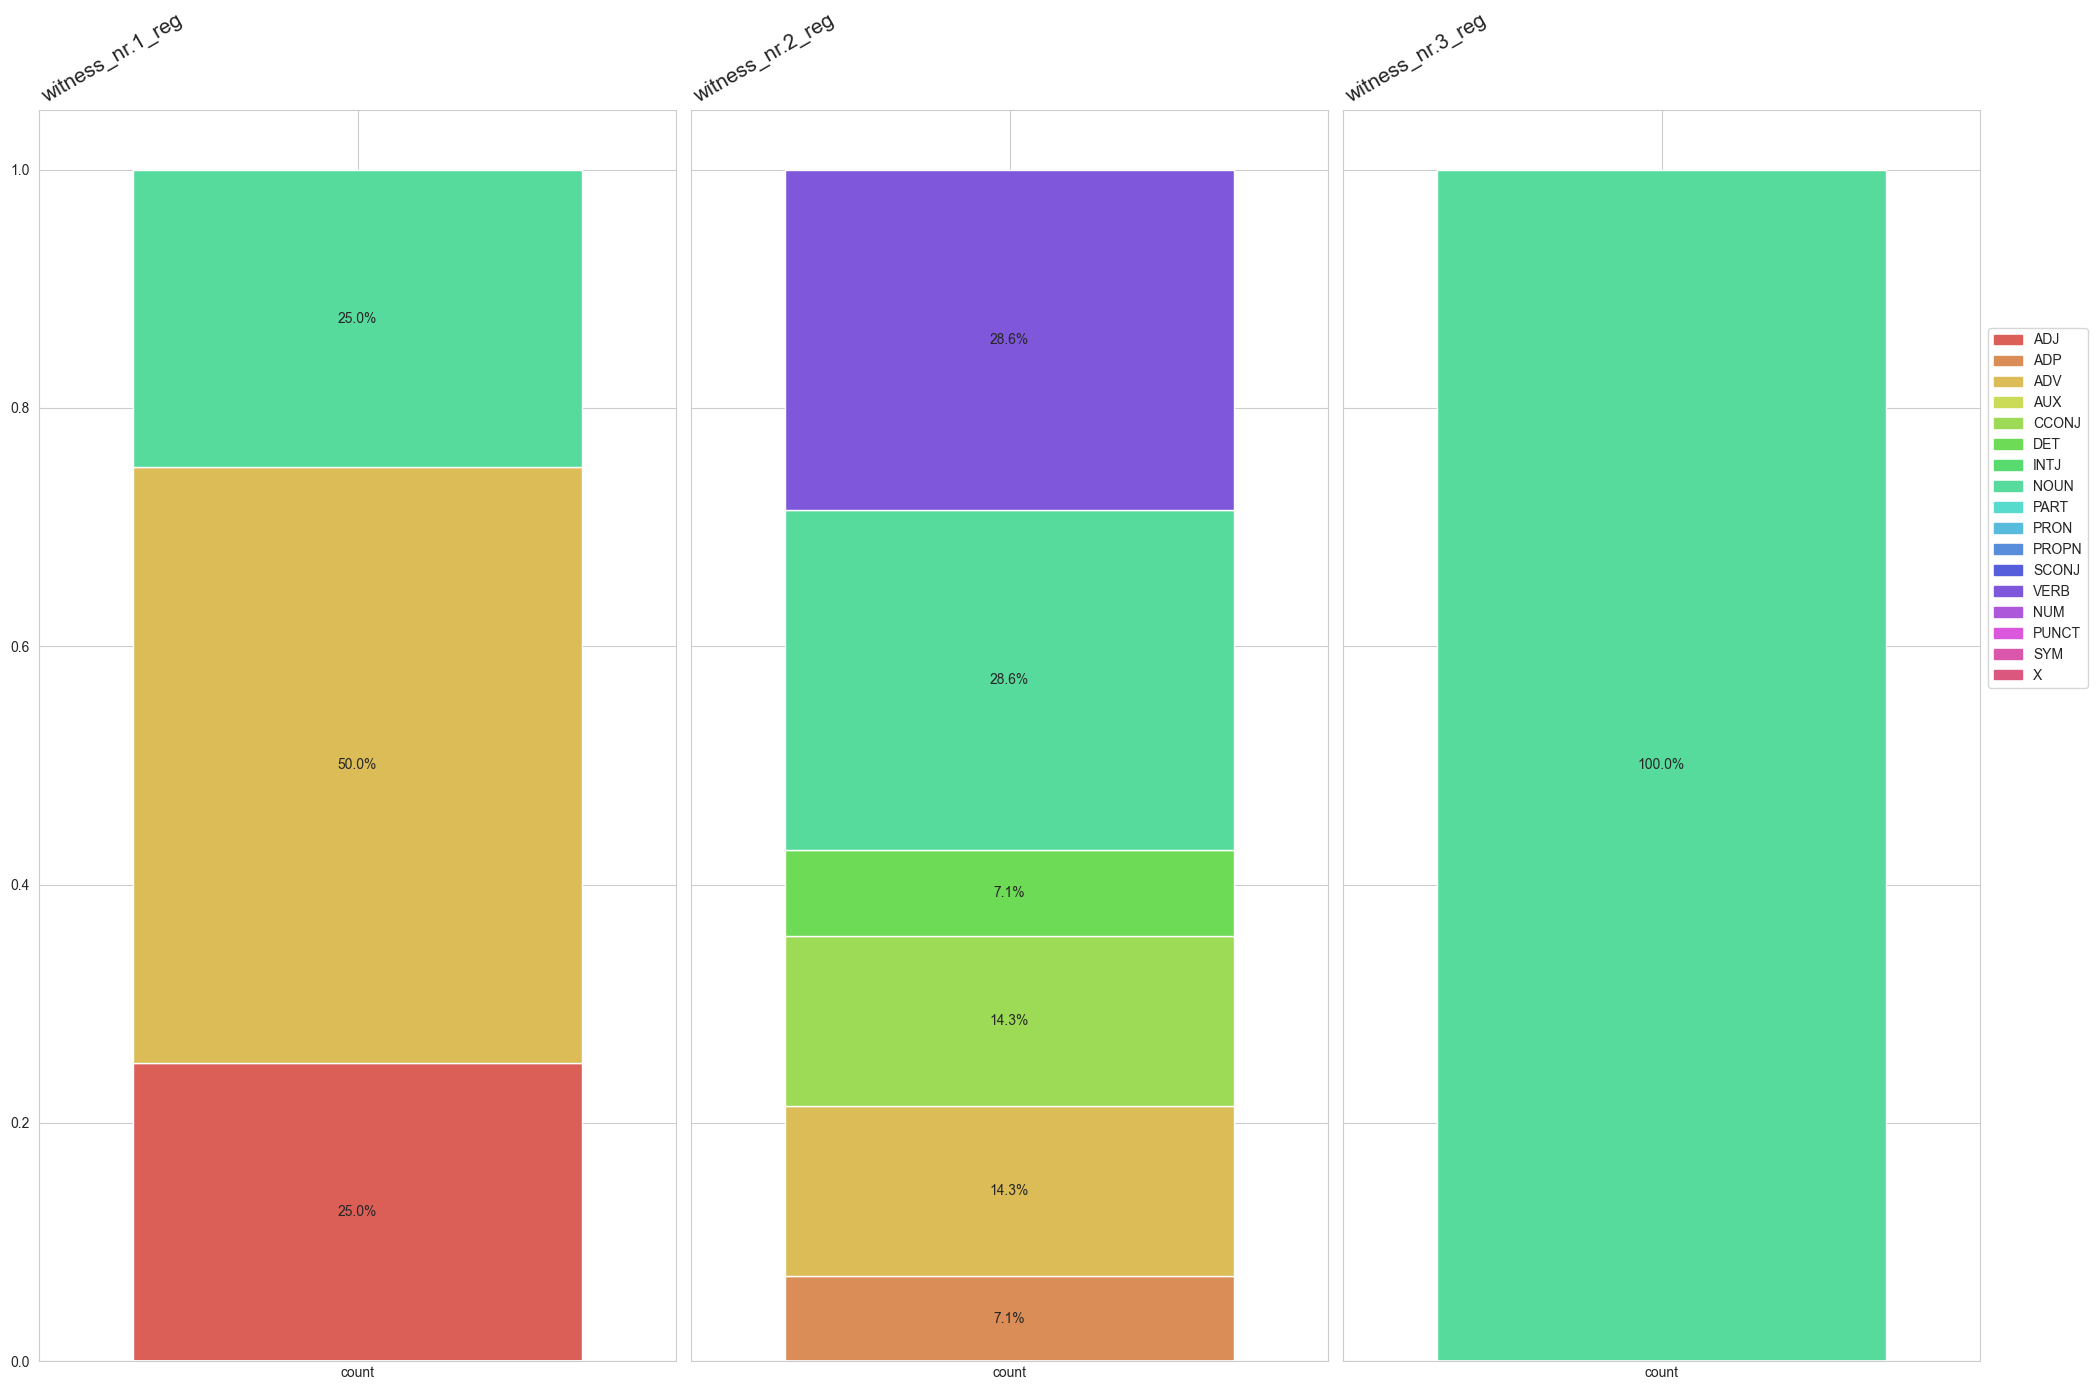

In [24]:
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Kombination_Eingriffe_Token-POS_csvs'

csv_files = [filename for filename in os.listdir(directory) if filename.startswith('rel_counts_') and filename.endswith('.csv')]
interferences = set()

for csv_file in csv_files:
    witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
        
    interfer_type = csv_file.split('rel_counts_')[-1].split('_POS_')[0]
    if interfer_type not in interferences: 
        interferences.add(interfer_type)

for interfer_type in interferences: 
    abs_dfs = {}
    for csv_file in csv_files: 
        if interfer_type in csv_file.split('rel_counts_')[-1].split('_POS_')[0]: 
            df = pd.read_csv(os.path.join(directory, csv_file))
            witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
            df_name = f"{witness}_{interfer_type}"
            abs_dfs[df_name] = df

    all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')
    
    palette = sns.color_palette("hls", n_colors=len(all_categories))

    category_color_map = dict(zip(all_categories, palette))

    label_map = {category: category.split("-")[0] for category in all_categories}

    num_dfs = len(abs_dfs)
    fig, axes = plt.subplots(1, num_dfs, figsize=(20, 14), sharey=True)

    legend_handles = []
    legend_labels = set() 
    threshold = 0

    for idx, (df_name, df) in enumerate(abs_dfs.items()):
        ax = axes[idx] if num_dfs > 1 else axes  
        stacked_df = df.set_index('pos').T
    
        for category in all_categories:
            if category not in stacked_df.columns:
                stacked_df[category] = 0 
        stacked_df = stacked_df.reindex(columns=all_categories)

        stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)

        ax.set_xlabel(f'',fontsize=10, rotation=45)
        ax.xaxis.label.set_color('black')
        ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
        ax.tick_params(axis='x', rotation=0, size=0, color='white')
    
        for container in ax.containers:
            labels = [f"{val:.1%}" if val > threshold else "" for val in container.datavalues]  
            ax.bar_label(container, labels=labels, label_type='center')
        
        for category in all_categories:
            if category not in legend_labels: 
                legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
                legend_labels.add(category)  
                
    fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')
    
    plt.tight_layout()
    
    plt.savefig(f'{foldername}/VisVergleich_relativ_{interfer_type}_Eingriffe_pos_{poem}.png')
    
    plt.show()
        
        

### POS insgesamt, die in add/del/reg vorhanden sind

CSV-Files einlesen, nach Eingriffs-Tags sortiern und verbunden für Overall-Counts (absolut und relativ).

In [25]:
directory = f'C:/Users/jO/Desktop/DH_MA_Arbeit/coding/{poem}/{poem}_Kombination_Eingriffe_Token-POS_csvs'

csv_files = [filename for filename in os.listdir(directory) if filename.startswith('abs_counts_') and filename.endswith('.csv')]
interferences = set()

for csv_file in csv_files:
    witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
        
    interfer_type = csv_file.split('abs_counts_')[-1].split('_POS_')[0]
    if interfer_type not in interferences: 
        interferences.add(interfer_type)

all_counts = {}
rel_all_counts = {}

for interfer_type in interferences: 
    print(interfer_type)
    abs_dfs = {}
    for csv_file in csv_files: 
        if interfer_type in csv_file.split('abs_counts_')[-1].split('_POS_')[0]: 
            df = pd.read_csv(os.path.join(directory, csv_file))
            witness = csv_file.split('_POS_')[-1].split('_df.csv')[0]
            df_name = f"{witness}_{interfer_type}"
            abs_dfs[df_name] = df
    concatenated_df = pd.concat(abs_dfs.values())

# Nach Kategorie groupieren und die Summe der Counts erstellen
    overall_counts = concatenated_df.groupby('pos').sum().reset_index()
    overall_counts.to_csv(f'{foldername}/OVERALL_ABS_counts_{interfer_type}_POS_df.csv', index=False)
    all_counts[interfer_type] = overall_counts
    print(overall_counts)

    rel_overall_counts = overall_counts.copy()
    total_count = overall_counts['count'].sum()
    rel_overall_counts['count'] = rel_overall_counts['count'] / total_count
    rel_all_counts[interfer_type] = rel_overall_counts
    rel_overall_counts.to_csv(f'{foldername}/OVERALL_REL_counts_{interfer_type}_POS_df.csv', index=False)        
    print(rel_overall_counts)

add
     pos  count
0    ADJ      3
1    ADP      3
2    ADV      3
3    DET      4
4   NOUN      4
5   PRON      2
6  PUNCT      3
7  SCONJ      1
8   VERB      5
     pos     count
0    ADJ  0.107143
1    ADP  0.107143
2    ADV  0.107143
3    DET  0.142857
4   NOUN  0.142857
5   PRON  0.071429
6  PUNCT  0.107143
7  SCONJ  0.035714
8   VERB  0.178571
del
    pos  count
0   ADJ      3
1   ADP      4
2   ADV      4
3   DET      6
4  NOUN      4
5  PRON      1
6  VERB      4
    pos     count
0   ADJ  0.115385
1   ADP  0.153846
2   ADV  0.153846
3   DET  0.230769
4  NOUN  0.153846
5  PRON  0.038462
6  VERB  0.153846
reg
     pos  count
0    ADJ      1
1    ADP      1
2    ADV      4
3  CCONJ      2
4    DET      1
5   NOUN      6
6   VERB      4
     pos     count
0    ADJ  0.052632
1    ADP  0.052632
2    ADV  0.210526
3  CCONJ  0.105263
4    DET  0.052632
5   NOUN  0.315789
6   VERB  0.210526


#### Visualisierung / absolut:

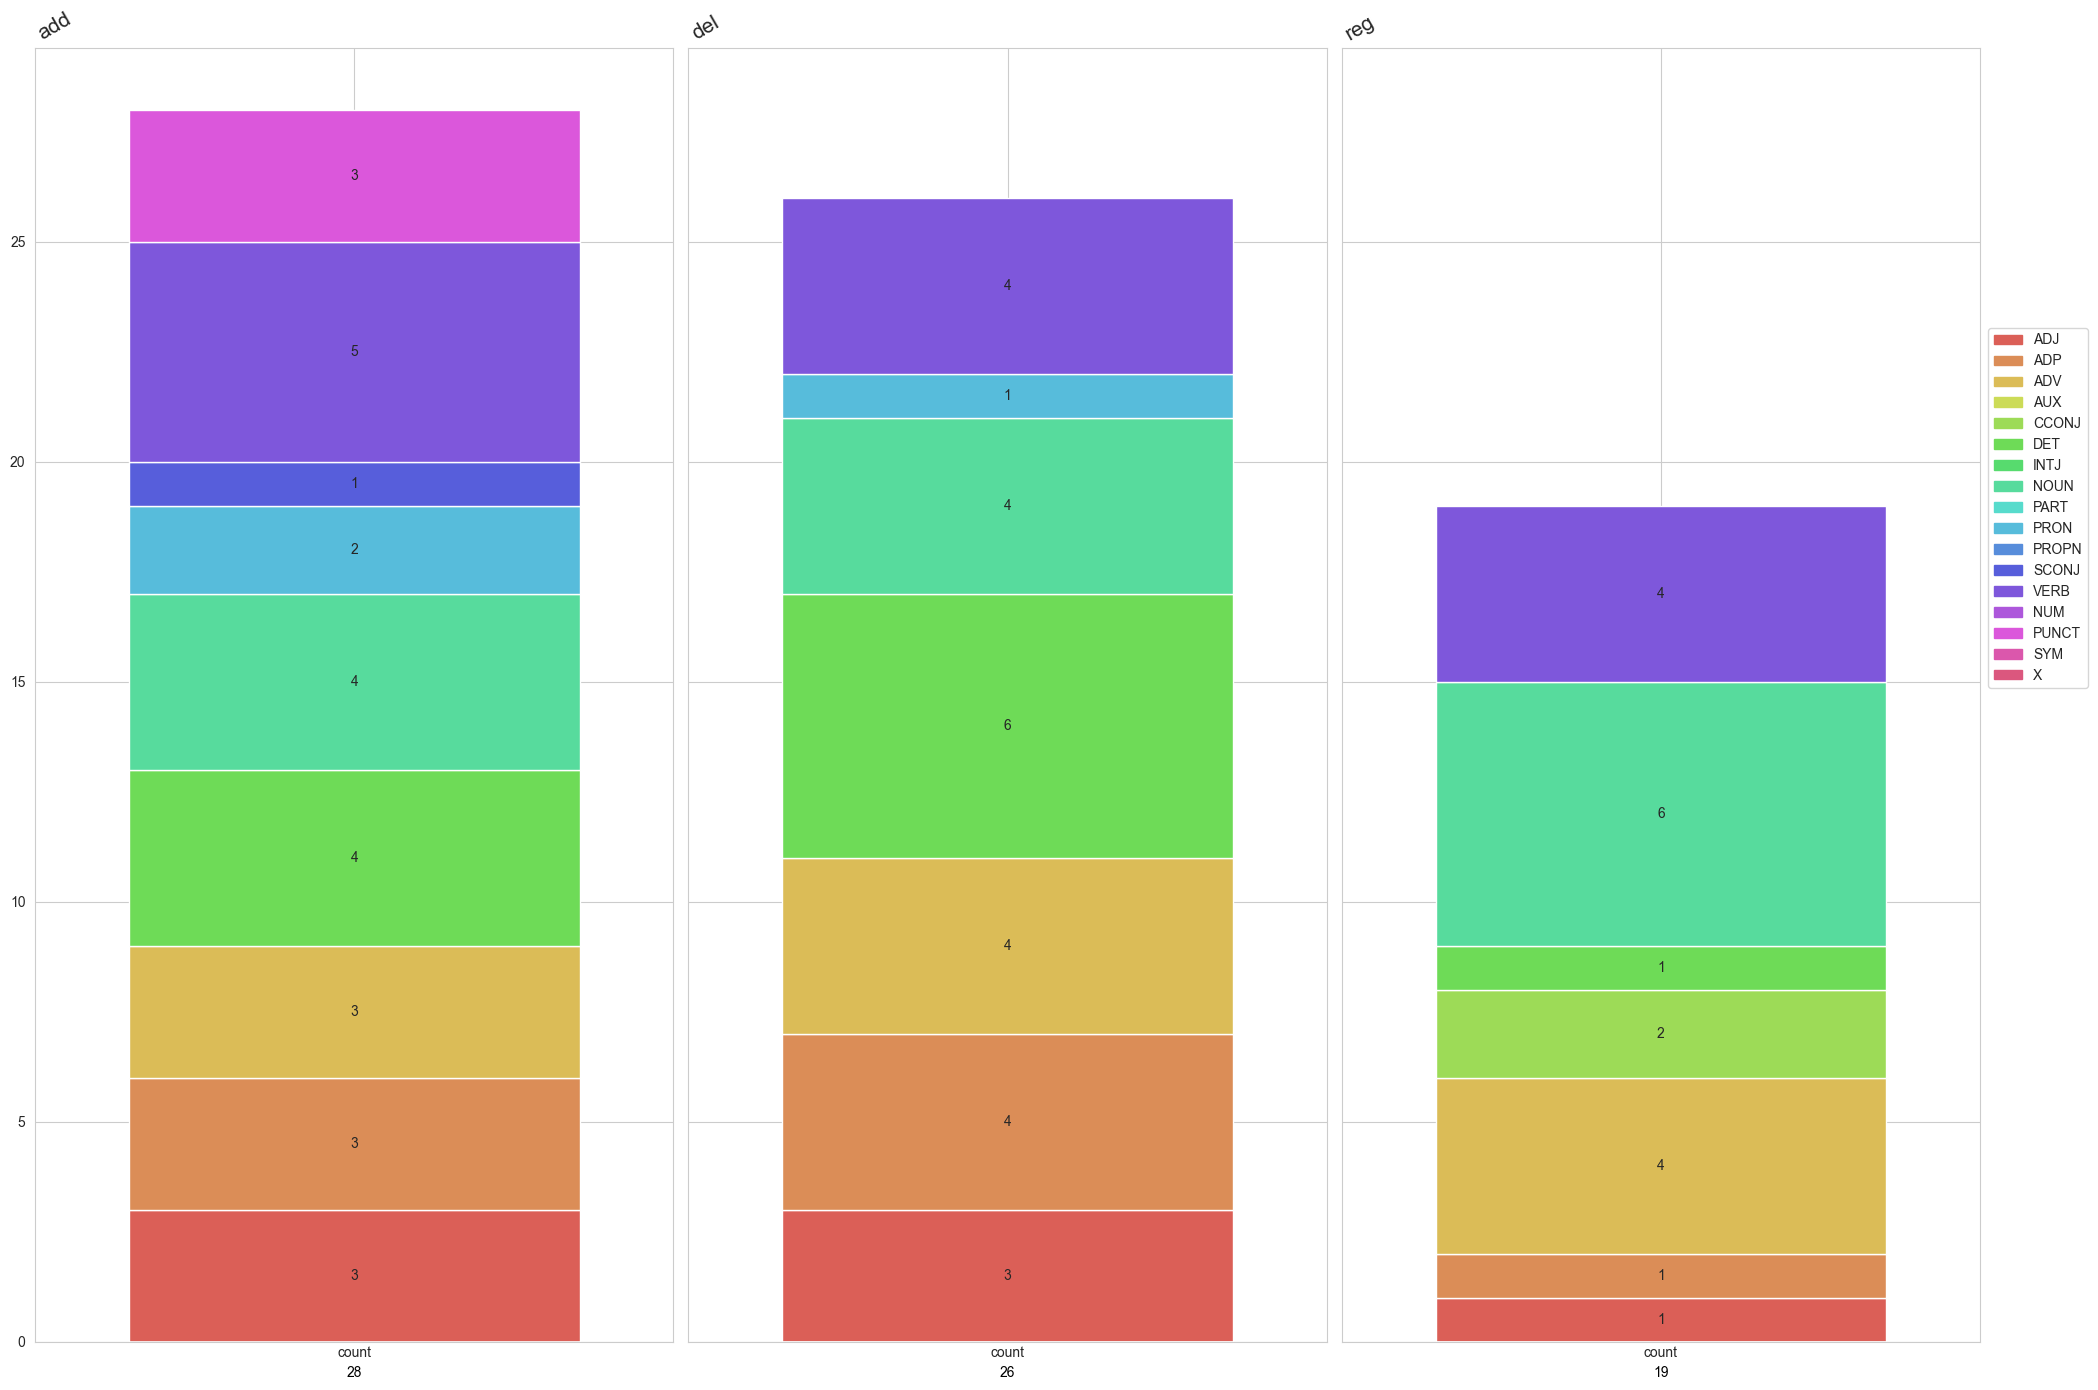

In [26]:
#visualisation

all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')

palette = sns.color_palette("hls", n_colors=len(all_categories))

category_color_map = dict(zip(all_categories, palette))

label_map = {category: category.split("-")[0] for category in all_categories}

num_dfs = len(all_counts)
fig, axes = plt.subplots(1, num_dfs, figsize=(20, 14), sharey=True)

legend_handles = []
legend_labels = set()  
threshold = 0

for idx, (df_name, df) in enumerate(all_counts.items()):
    ax = axes[idx] if num_dfs > 1 else axes  
    totals = df['count'].sum()
    stacked_df = df.set_index('pos').T

    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0  
    stacked_df = stacked_df.reindex(columns=all_categories)

    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)

    ax.set_xlabel(totals, fontsize=10, rotation=0)
    ax.xaxis.label.set_color('black')
    ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
    ax.tick_params(axis='x', rotation=0, size=0, color='white')

    for container in ax.containers:
        labels = [f"{int(val)}" if val > threshold else "" for val in container.datavalues]  
        ax.bar_label(container, labels=labels, label_type='center')
    
    for category in all_categories:
        if category not in legend_labels:  
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category) 

fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')
plt.tight_layout()

plt.savefig(f'{foldername}/VisVergleich_OVERALL_ABS_Eingriffe_pos_{poem}.png')
plt.show()    

#### relative Counts

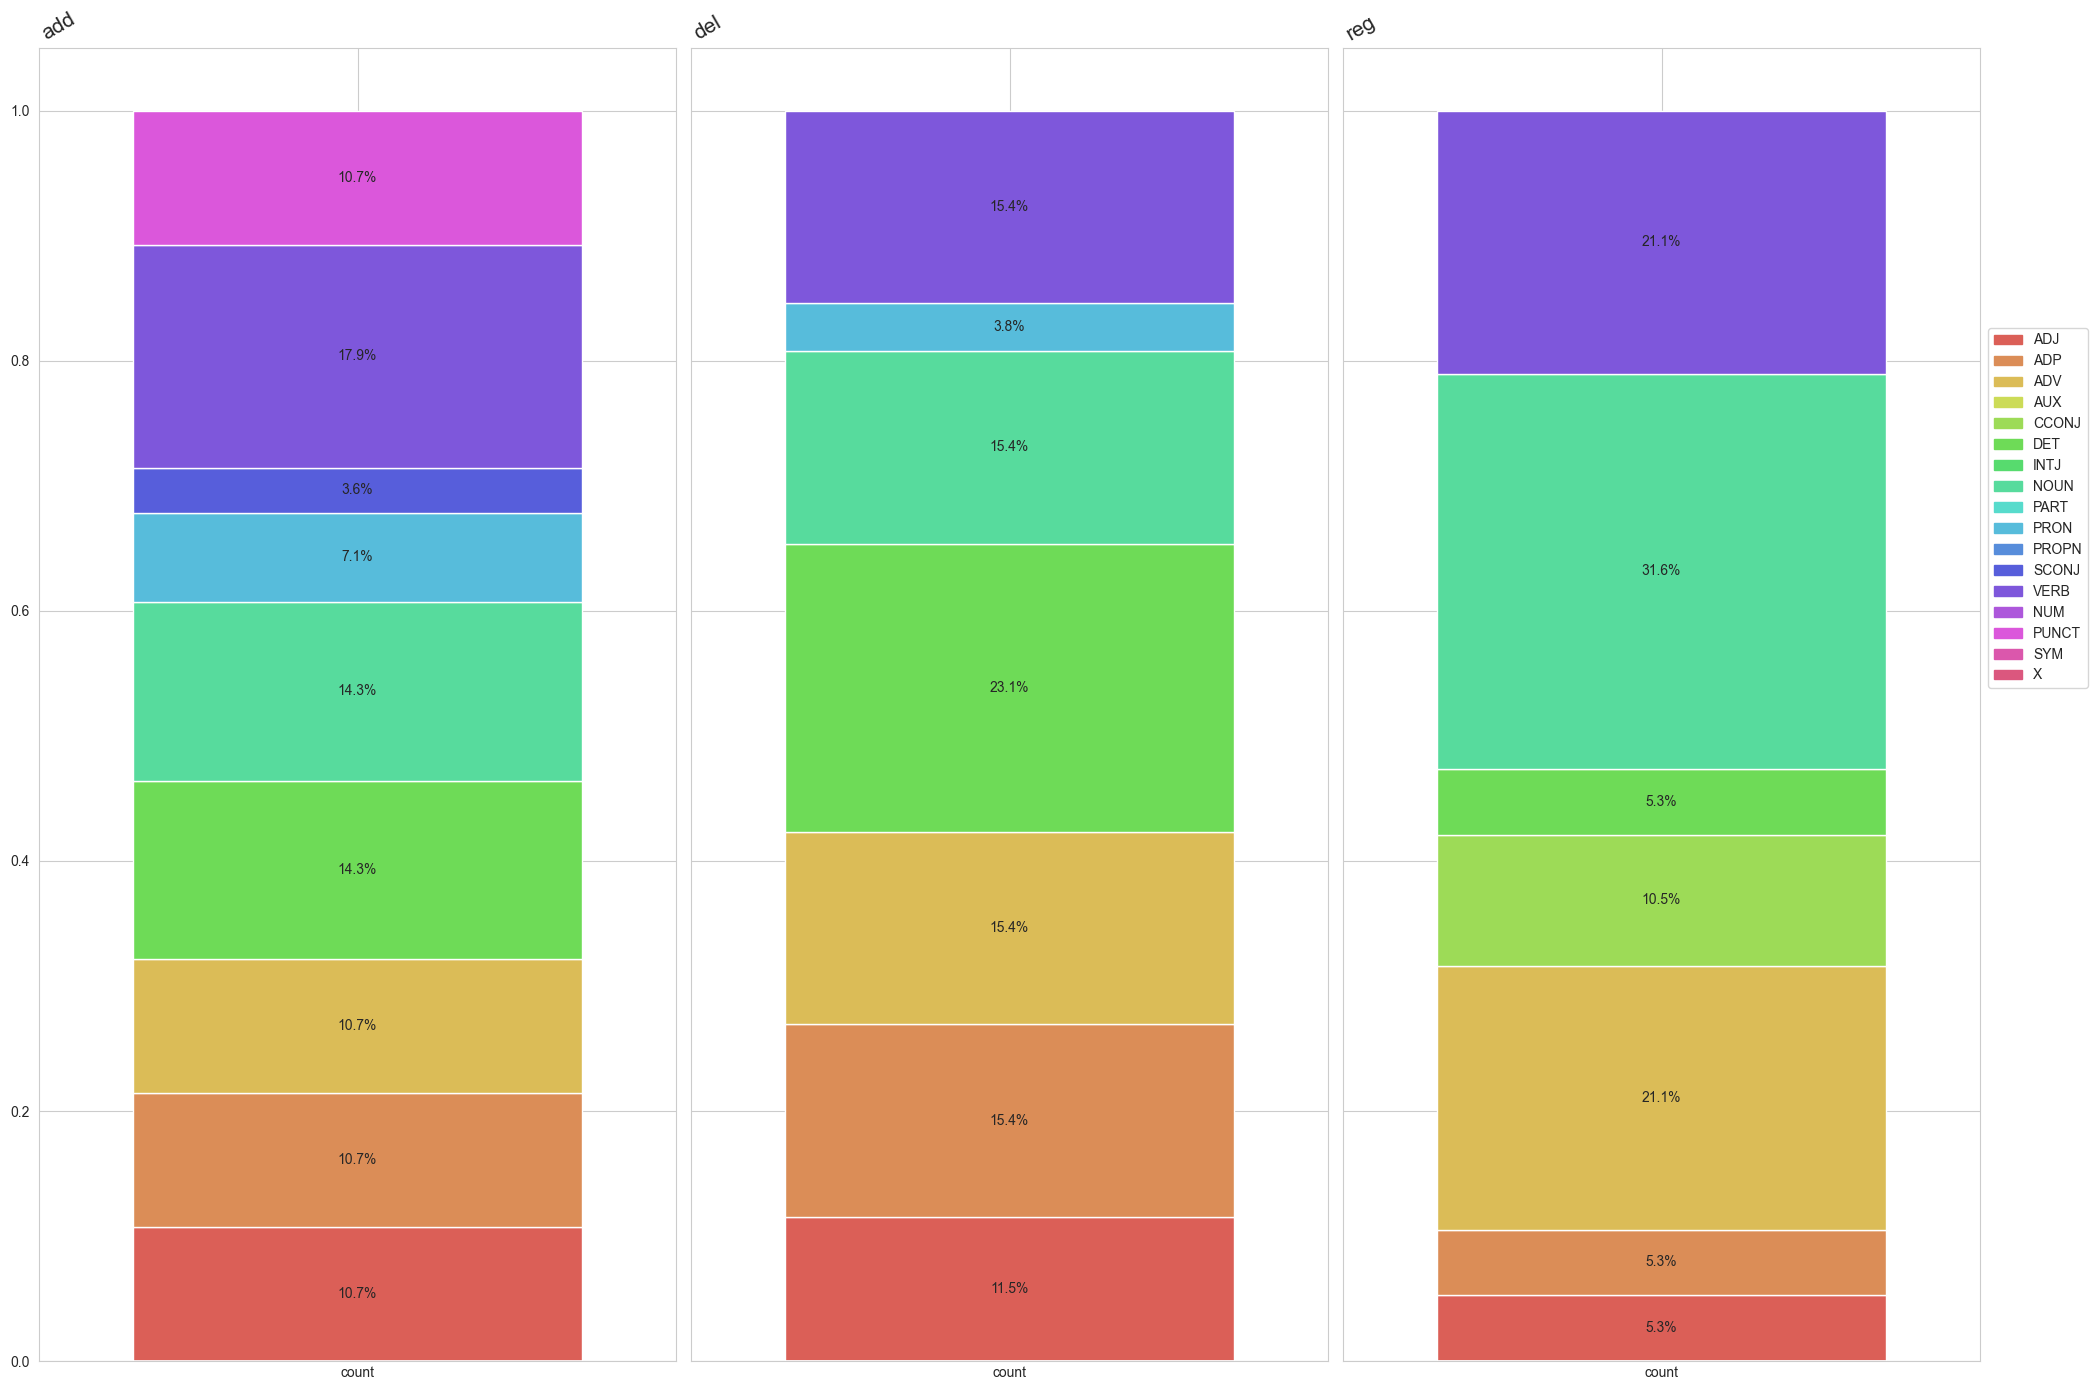

In [27]:
# visualisierung

all_categories = ('ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'PART', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'NUM', 'PUNCT', 'SYM', 'X')

palette = sns.color_palette("hls", n_colors=len(all_categories))

category_color_map = dict(zip(all_categories, palette))

label_map = {category: category.split("-")[0] for category in all_categories}

num_dfs = len(rel_all_counts)
fig, axes = plt.subplots(1, num_dfs, figsize=(20, 14), sharey=True)

legend_handles = []
legend_labels = set()  
threshold = 0

for idx, (df_name, df) in enumerate(rel_all_counts.items()):
    ax = axes[idx] if num_dfs > 1 else axes  
    stacked_df = df.set_index('pos').T
    
    for category in all_categories:
        if category not in stacked_df.columns:
            stacked_df[category] = 0 
    stacked_df = stacked_df.reindex(columns=all_categories)

    stacked_df.plot(kind='bar', stacked=True, color=[category_color_map[cat] for cat in stacked_df.columns], ax=ax, legend=None, width=1.2)

    ax.set_xlabel(f'',fontsize=10, rotation=45)
    ax.xaxis.label.set_color('black')
    ax.set_title(f'{df_name}', fontsize=15, rotation=30, loc='left')
    ax.tick_params(axis='x', rotation=0, size=0, color='white')

    for container in ax.containers:
        labels = [f"{val:.1%}" if val > threshold else "" for val in container.datavalues]  
        ax.bar_label(container, labels=labels, label_type='center')

    for category in all_categories:
        if category not in legend_labels:  
            legend_handles.append(mpatches.Patch(color=category_color_map[category], label=label_map[category]))
            legend_labels.add(category)  
            
fig.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='lower right')
plt.tight_layout()

plt.savefig(f'{foldername}/VisVergleich_OVERALL_ABS_Eingriffe_pos_{poem}.png')
plt.show()    